# Figures

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [628]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['BCell', 'TCell']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix,
               modifications=MODIFICATIONS,
               cells=GSE26320_CELLS,
               replicates=GSE26320_REPS):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [377]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


file modification   cell  \
106  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3  HepG2   
50   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3   HSMM   
220  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac   K562   
180  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K4me1   HSMM   
214  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K27me3   NHLF   

    replicate  peaks         tool dataset  
106      rep2      0  MACS2 broad  ENCODE  
50       rep1   5126        MACS2  ENCODE  
220      rep1  26929        SICER  ENCODE  
180      rep1  58438        SICER  ENCODE  
214      rep2  38498        SICER  ENCODE

In [378]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 10


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 10


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 10


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 10


file modification   cell  \
29  /home/jetbrains/data/2023_Immune/sicer/TCell_H...      H3K4me1  TCell   
32  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K27me3  BCell   
14  /home/jetbrains/data/2023_Immune/macs2/BCell_H...     H3K36me3  BCell   
33  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me3  BCell   
9   /home/jetbrains/data/2023_Immune/macs2/BCell_H...     H3K36me3  BCell   

   replicate   peaks         tool  dataset  
29             53056        SICER  Roadmap  
32            102270         SPAN  Roadmap  
14            152502  MACS2 broad  Roadmap  
33             21067         SPAN  Roadmap  
9             177956        MACS2  Roadmap

In [379]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

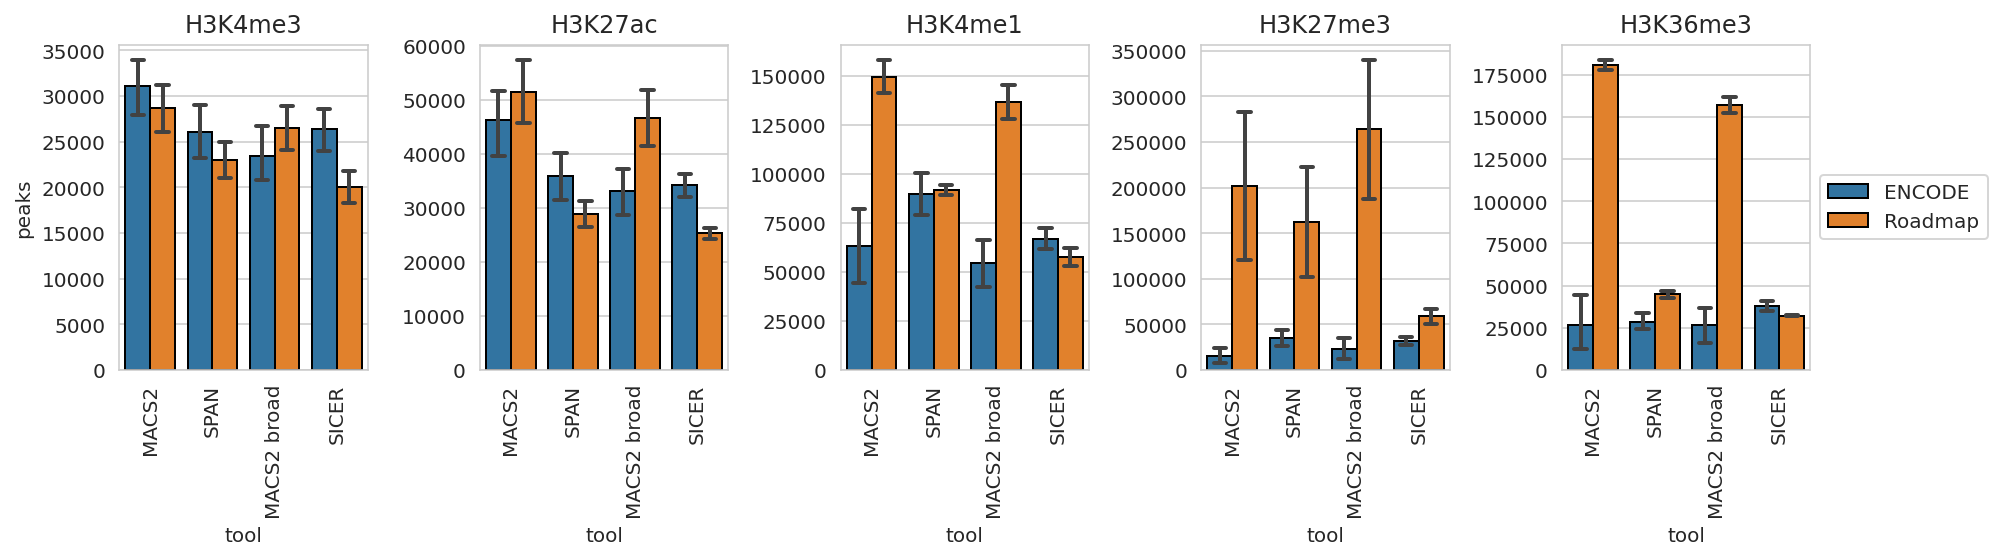

In [10]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'SPAN', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1']) & 
          (df_peaks['replicate'].isin(['rep1', '']))) & 
         ((df_peaks['peaks'] > 100_000) | (df_peaks['peaks'] < 10_000))]

file modification   cell  \
25   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
57   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   K562   
261  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1   NHEK   
340  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1  TCell   
343  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1  BCell   
351  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1  BCell   
359  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1  TCell   

    replicate   peaks         tool  dataset  
25       rep1  110303        MACS2   ENCODE  
57       rep1  119713        MACS2   ENCODE  
261      rep1  107773         SPAN   ENCODE  
340            158205        MACS2  Roadmap  
343            141414        MACS2  Roadmap  
351            127965  MACS2 broad  Roadmap  
359            145437  MACS2 broad  Roadmap

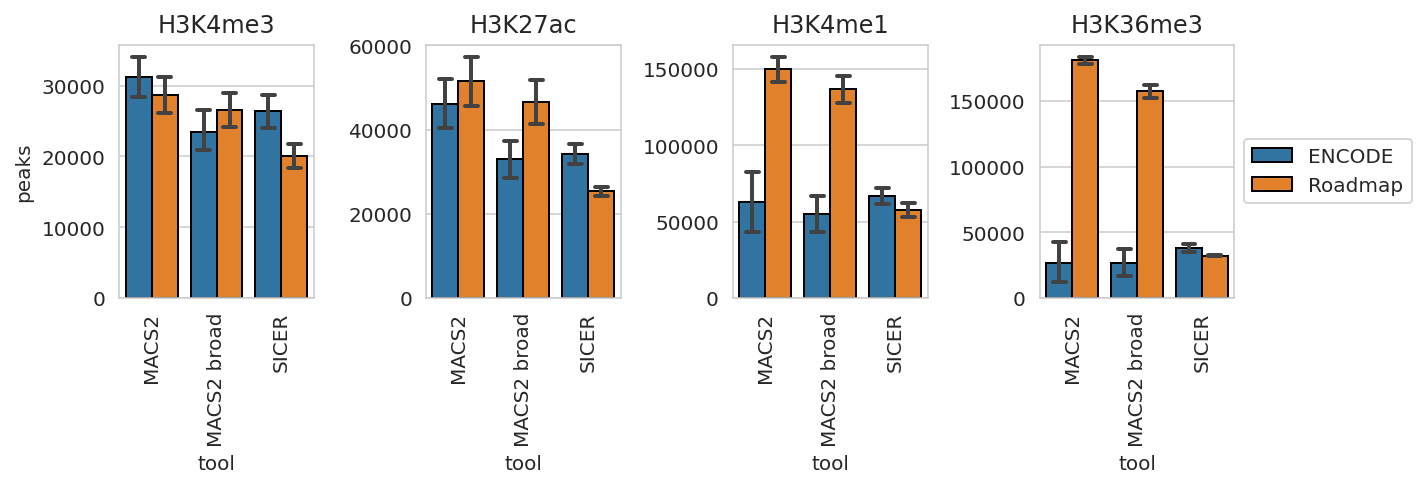

In [12]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

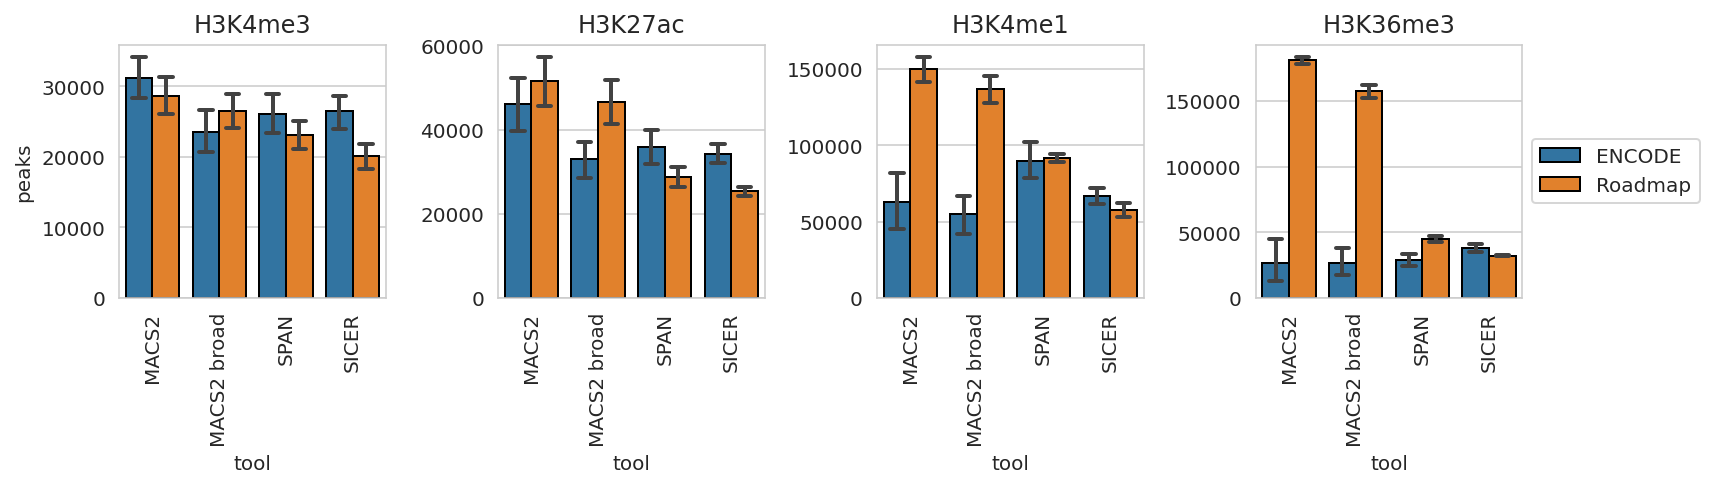

In [13]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification     cell replicate         tool
142920    326.0   ENCODE      H3K4me1     NHLF      rep2        MACS2
3435749  6799.0  Roadmap      H3K27ac    BCell                  SICER
3173432   284.0  Roadmap     H3K27me3    BCell                  MACS2
1447909  1051.0   ENCODE     H3K36me3    HepG2      rep2  MACS2 broad
2885531   640.0   ENCODE     H3K36me3       H1      rep2         SPAN
3261279  1284.0  Roadmap      H3K27ac    TCell            MACS2 broad
1732939  2999.0   ENCODE     H3K36me3       H1      rep2        SICER
298891    404.0   ENCODE     H3K27me3       H1      rep2        MACS2
3037995  1144.0   ENCODE      H3K27ac  GM12878      rep1         SPAN
1724694  3399.0   ENCODE      H3K4me1     K562      rep1        SICER

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


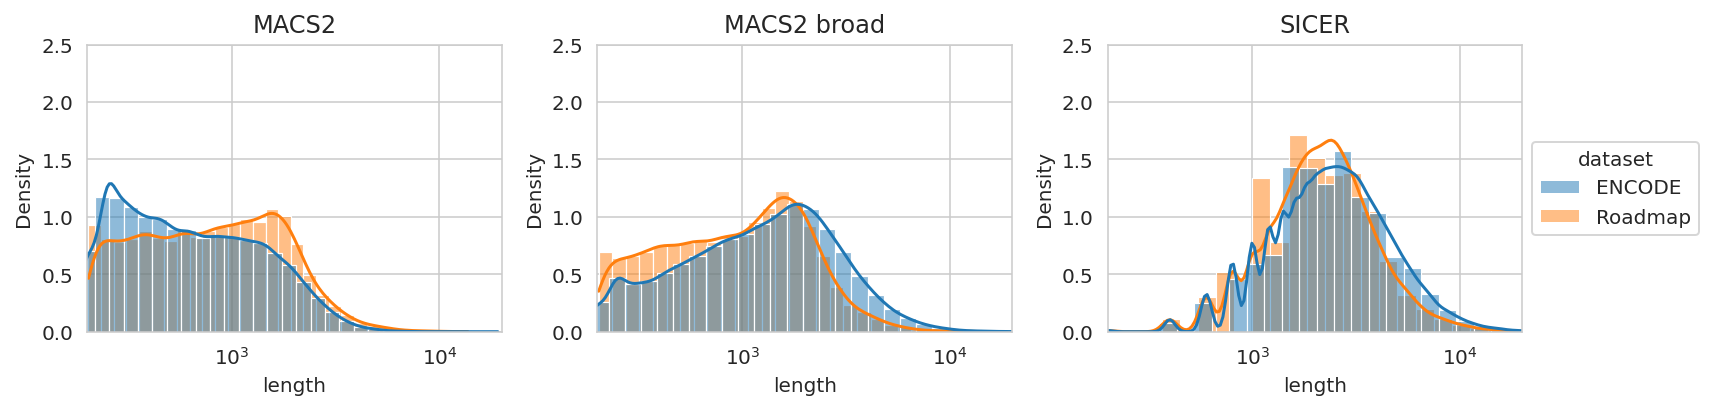

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


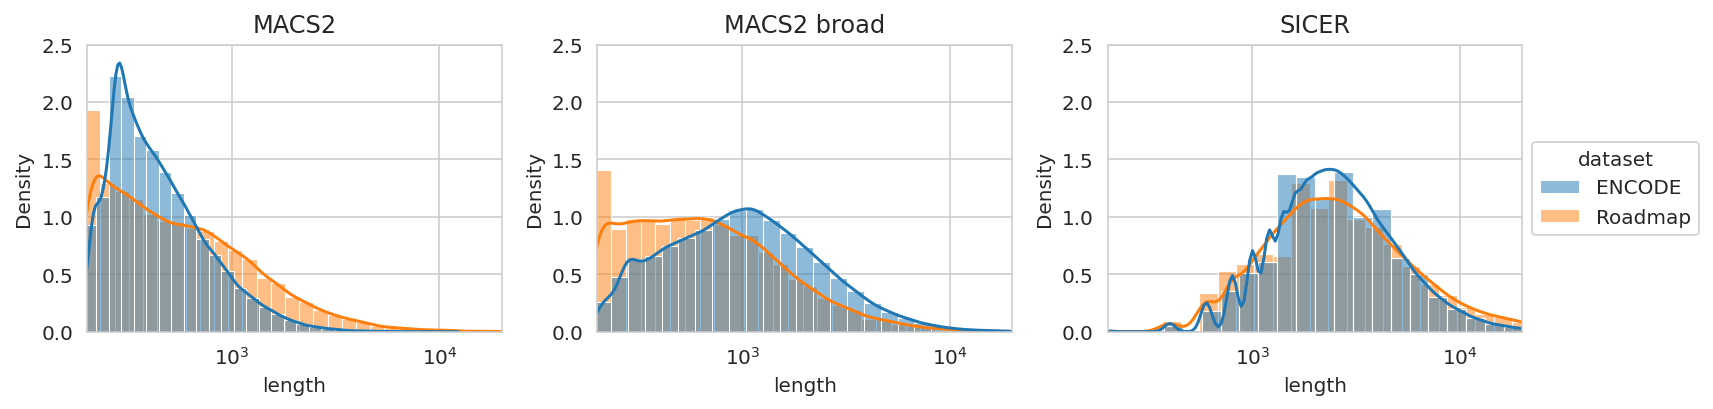

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


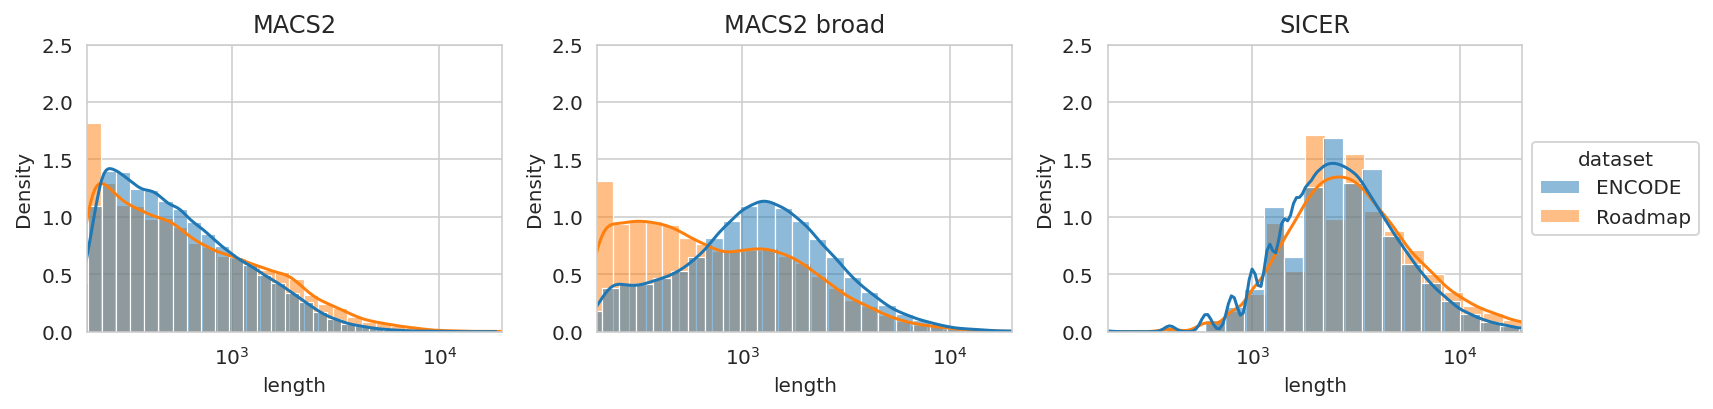

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


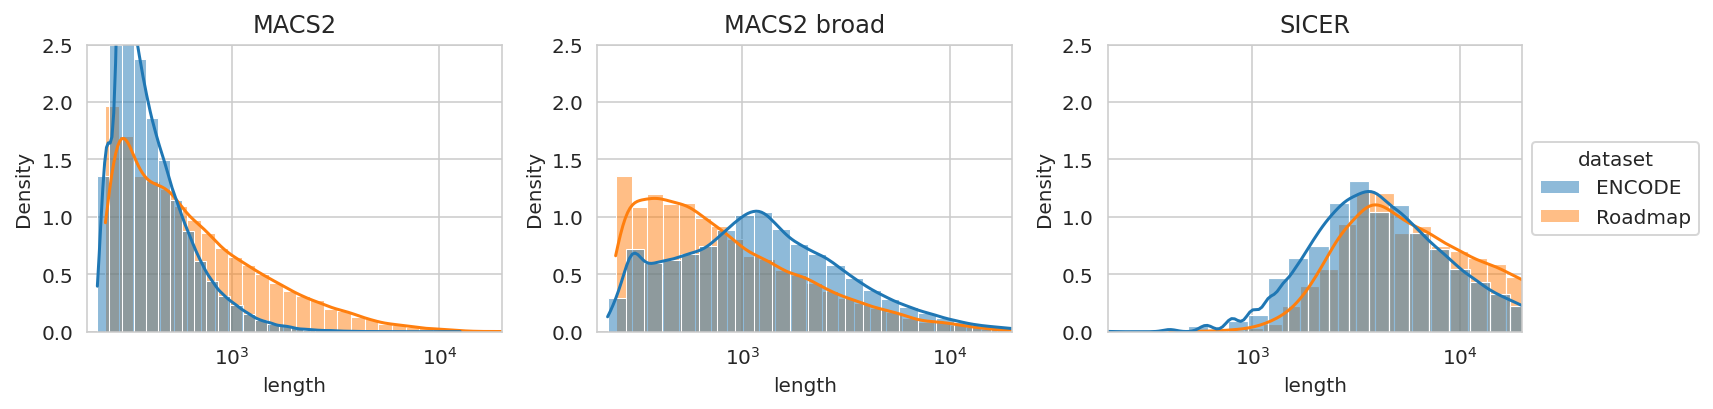

In [15]:
for m in ['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


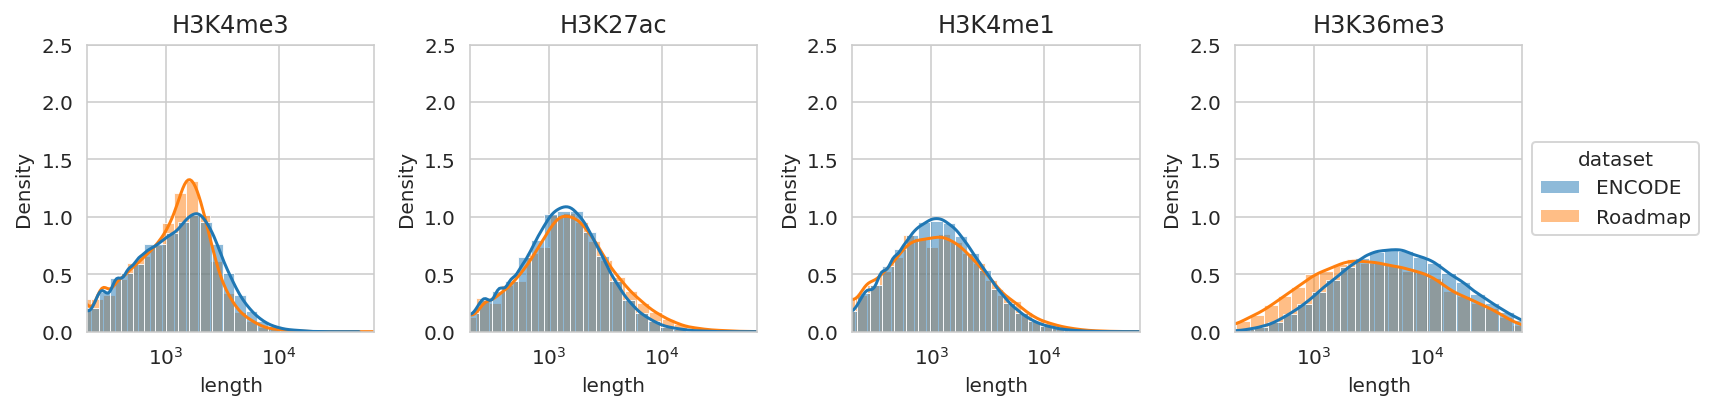

In [16]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [17]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

dataset modification   cell replicate         tool     length
361  Roadmap      H3K4me1  BCell                   SPAN  1877.0269
119   ENCODE     H3K27me3   K562      rep2  MACS2 broad   268.5833
369  Roadmap      H3K4me3  BCell                   SPAN  1367.8279

H3K4me3
H3K27ac
H3K4me1
H3K36me3


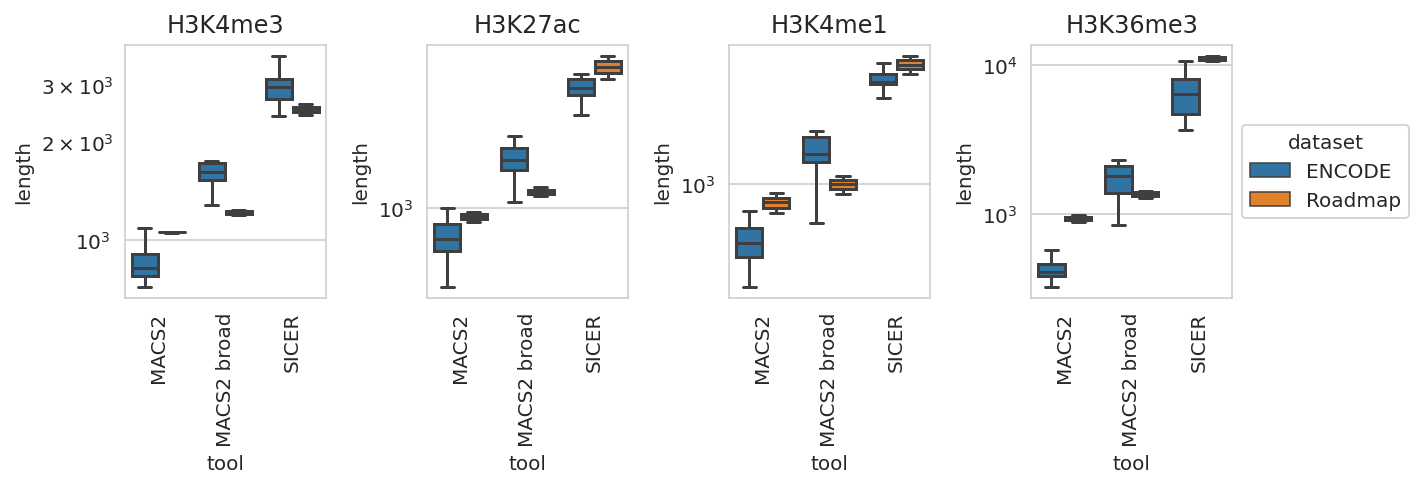

In [18]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=t_aggr[t_aggr['modification'] == m],
                            x='tool', y='length', ax=ax, hue='dataset',
                            showfliers=False,
                            # capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    ax.set(yscale='log')

    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, )
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Load downsampled peaks

In [19]:
# NOISE_PATH = os.path.expanduser('~/data/2023_Immune_noise')
NOISE_PATH = os.path.expanduser('~/data/2023_Immune_mln_control')

In [20]:
df_peaks_noise = load_peaks_path(NOISE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_peaks_noise['quality'] = 0
for mln in [15, 10, 5, 2, 1]:
    df_peaks_noise.loc[[f'_{mln}mln' in file for file in df_peaks_noise['file']], 'quality'] = mln
df_peaks_noise.sample(3)

  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/352 [00:00<?, ?it/s]

SICER 32


  0%|          | 0/45 [00:00<?, ?it/s]

SPAN 32


file modification   cell  \
121  /home/jetbrains/data/2023_Immune_mln_control/s...      H3K4me3  BCell   
75   /home/jetbrains/data/2023_Immune_mln_control/s...      H3K4me3  BCell   
78   /home/jetbrains/data/2023_Immune_mln_control/s...      H3K4me3  TCell   

    replicate  peaks   tool  quality  
121            16239   SPAN       10  
75             16274  SICER       10  
78             13896  SICER        1

In [21]:
t1 = df_peaks_noise[df_peaks_noise['quality'] == 10].copy()
t1['reads'] = 10
t2 = df_immune_peaks.copy()
t2['reads'] = 20
df_downsample = pd.concat([t1, t2]).reset_index(drop=True)
df_downsample['reads'] = df_downsample['reads'].astype(str) + 'M'

df_downsample

file modification   cell  \
0   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  BCell   
1   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  BCell   
2   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
3   /home/jetbrains/data/2023_Immune_mln_control/m...     H3K36me3  BCell   
4   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
..                                                ...          ...    ...   
67  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
68  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
69  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
70  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me1  BCell   
71  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  quality reads  dataset  
0             112650  MACS2     10.0   10M      NaN  
1              23702  MACS2     10.0   10M      NaN  
2              27685  MACS2     10.0   10M      NaN  
3             137165  MACS2     10.0   10M      NaN  
4             124685  MACS2     10.0   10M      NaN  
..       ...     ...    ...      ...   ...      ...  
67            222162   SPAN      NaN   20M  Roadmap  
68             42693   SPAN      NaN   20M  Roadmap  
69             26454   SPAN      NaN   20M  Roadmap  
70             89375   SPAN      NaN   20M  Roadmap  
71             25006   SPAN      NaN   20M  Roadmap  

[72 rows x 9 columns]

H3K27ac
H3K4me1


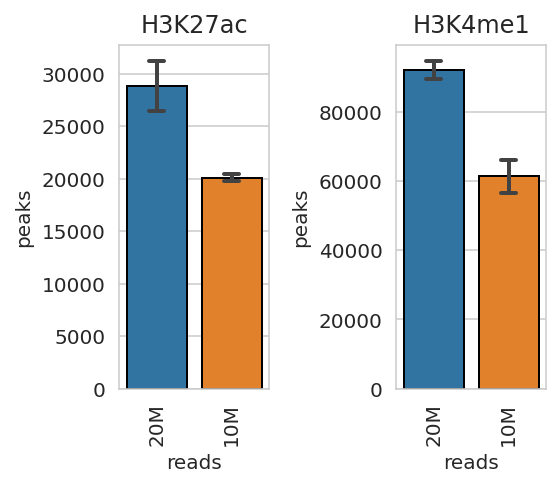

In [22]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[(df_downsample['modification'] == m) & 
                                               (df_downsample['tool'] == 'SPAN')],
                            x='reads', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


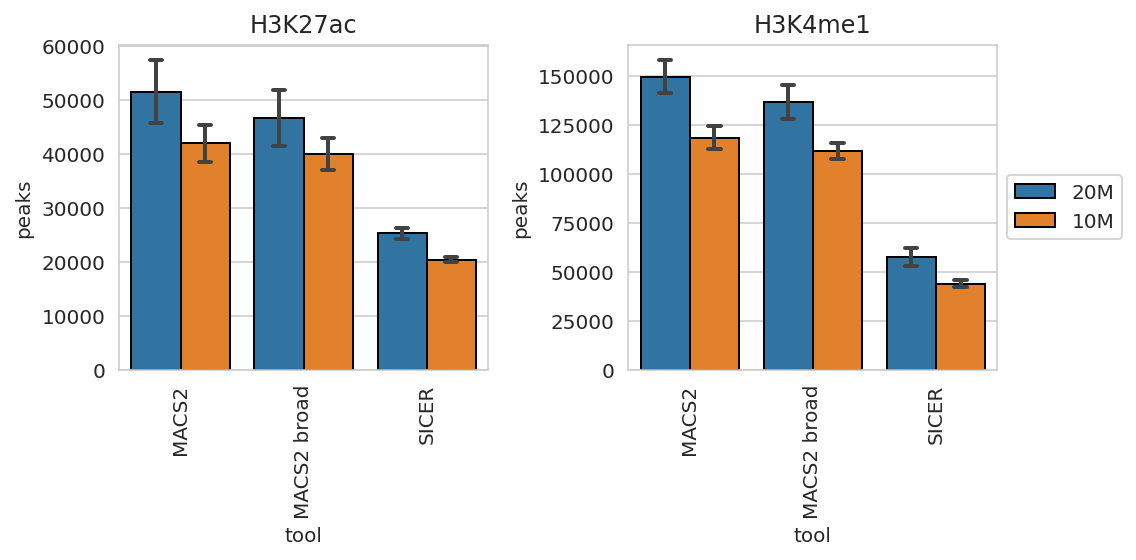

In [23]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[df_downsample['modification'] == m],
                            hue='reads', x='tool', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            hue_order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    if i != 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [24]:
df_downsample_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool', 
                                         'peaks20M', 'peaks10M', 'fold-change'])
t = df_downsample[df_downsample['reads'] == '20M']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    t10 = df_downsample[(df_downsample['reads'] == '10M') &
                        (df_downsample['modification'] == m) &
                        (df_downsample['cell'] == c) &
                        (df_downsample['replicate'] == r) &
                        (df_downsample['tool'] == to)]
    if len(t10) == 0:
        continue
    p10 = t10['peaks'].values[0]
    df_downsample_fc.loc[len(df_downsample_fc)] = (m, c, r, to, p, p10, d(p10, p))
df_downsample_fc.sample(3)

0it [00:00, ?it/s]

H3K4me1 TCell  MACS2 158205
H3K27me3 BCell  MACS2 120947
H3K27me3 TCell  MACS2 283089
H3K4me1 BCell  MACS2 141414
H3K27ac TCell  MACS2 57350
H3K4me3 TCell  MACS2 31242
H3K36me3 TCell  MACS2 183613
H3K4me3 BCell  MACS2 26066
H3K27ac BCell  MACS2 45626
H3K36me3 BCell  MACS2 177956
H3K27ac TCell  MACS2 broad 51740
H3K4me1 BCell  MACS2 broad 127965
H3K27ac BCell  MACS2 broad 41460
H3K27me3 TCell  MACS2 broad 339795
H3K36me3 BCell  MACS2 broad 152502
H3K27me3 BCell  MACS2 broad 187656
H3K4me3 BCell  MACS2 broad 24118
H3K36me3 TCell  MACS2 broad 161765
H3K4me3 TCell  MACS2 broad 28929
H3K4me1 TCell  MACS2 broad 145437
H3K4me3 TCell  SICER 21785
H3K36me3 BCell  SICER 31862
H3K27ac TCell  SICER 26338
H3K27me3 BCell  SICER 50127
H3K4me1 BCell  SICER 62076
H3K27me3 TCell  SICER 67477
H3K36me3 TCell  SICER 32491
H3K27ac BCell  SICER 24342
H3K4me3 BCell  SICER 18342
H3K4me1 TCell  SICER 53056
H3K27ac TCell  SPAN 31192
H3K36me3 TCell  SPAN 47042
H3K27me3 BCell  SPAN 102270
H3K4me3 BCell  SPAN 21067

modification   cell replicate         tool  peaks20M  peaks10M  fold-change
4      H3K36me3  TCell                  MACS2    183613    134346     0.731680
21      H3K27ac  BCell                  SICER     24342     19973     0.820516
13     H3K36me3  TCell            MACS2 broad    161765    127137     0.785936

H3K27ac
H3K4me1


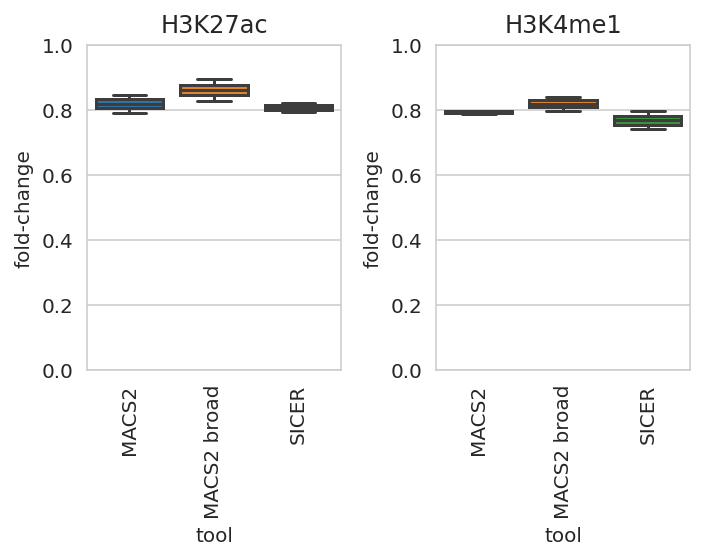

In [25]:
plt.figure(figsize=(5, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=df_downsample_fc[df_downsample_fc['modification'] == m],
                            x='tool', y='fold-change', ax=ax,
                            # capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    # if i != 1:
    #     ax.legend().set_visible(False)
    # else:
        # Put a legend to the right of the current axis
        # g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [26]:
print('Load lengths')
ts = []
for mod, signal_reads, file, tool in tqdm(zip(
        df_downsample['modification'], df_downsample['reads'], df_downsample['file'], df_downsample['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['modification'] = mod
    t['reads'] = signal_reads
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length modification reads         tool
470657    1938     H3K27me3   20M  MACS2 broad
233402    3599      H3K27ac   10M        SICER
40514     1053      H3K4me1   10M        MACS2
463905    1256     H3K36me3   20M  MACS2 broad
326070     927      H3K4me1   20M        MACS2
389620     278     H3K36me3   20M        MACS2
427674    1235      H3K27ac   20M  MACS2 broad
346507     204     H3K27me3   20M        MACS2
369902     200      H3K27ac   20M        MACS2
377301     203      H3K4me3   20M        MACS2

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


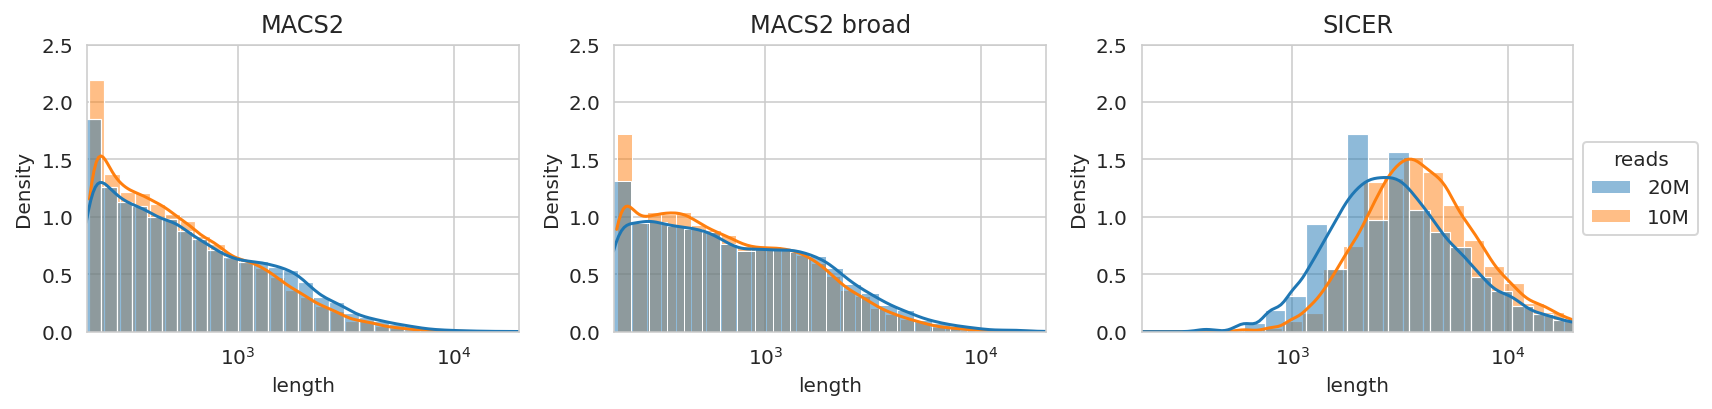

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


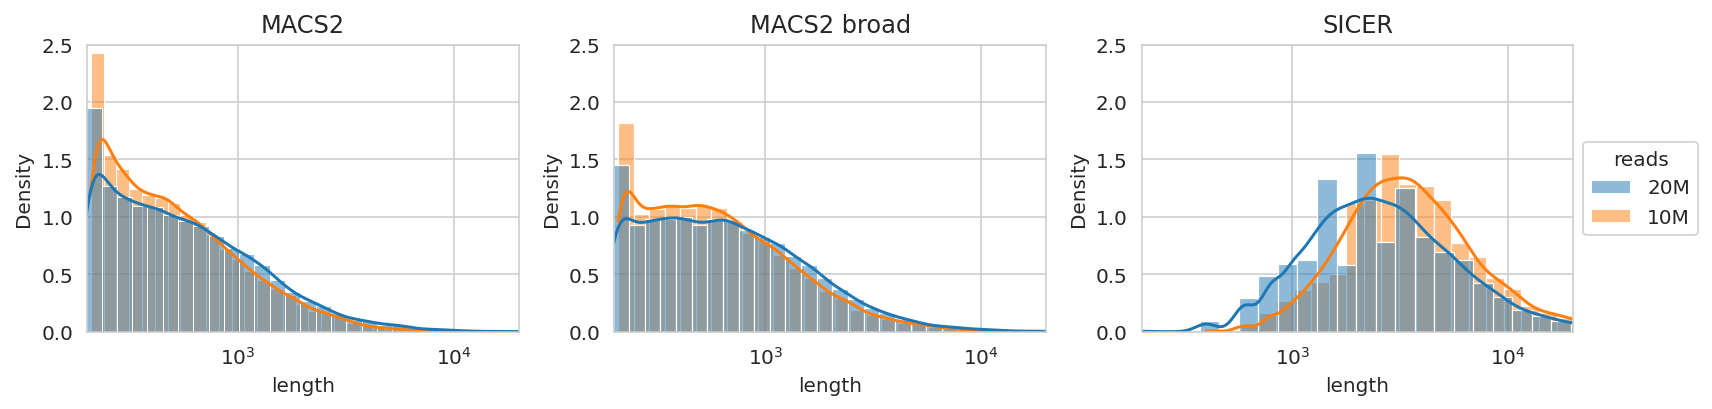

In [27]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='reads', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 hue_order=['20M', '10M'],
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


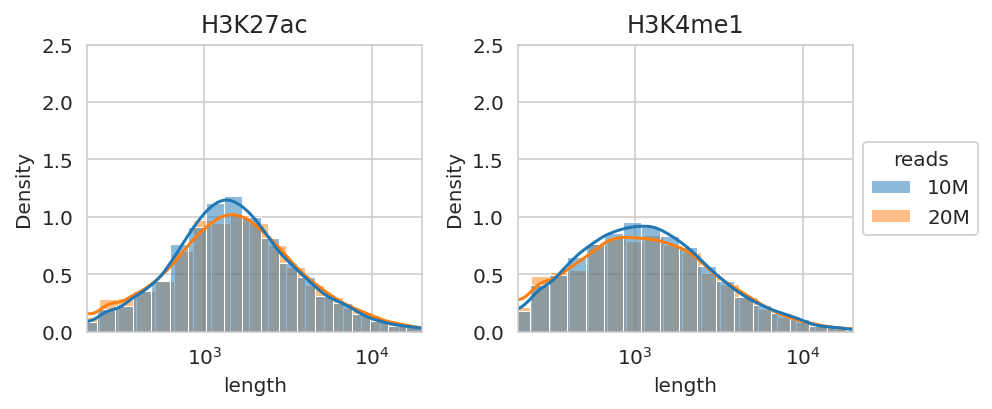

In [28]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='reads', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # hue_order=['20M', '10M'],
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


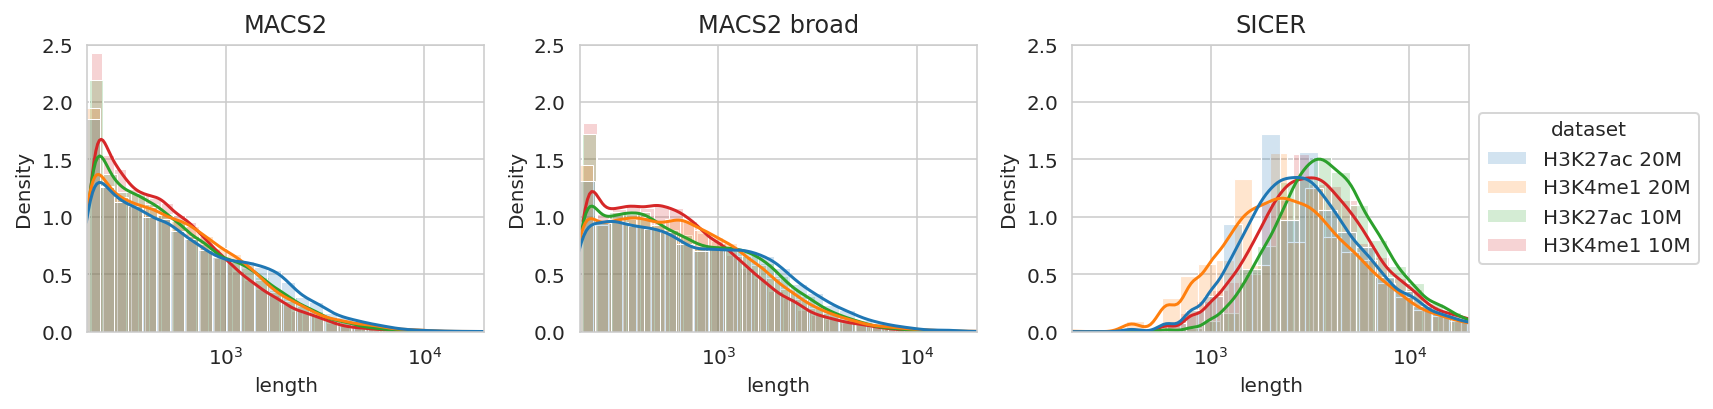

In [29]:
t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(
        data=t[((t['modification'] == 'H3K27ac') | (t['modification'] == 'H3K4me1')) & (t['tool'] == tool)],
        x='length', hue='dataset', ax=ax,
        stat='density', common_bins=False, common_norm=False,
        bins=30, kde=True, log_scale=True, alpha=0.2,
        hue_order=['H3K27ac 20M', 'H3K4me1 20M', 'H3K27ac 10M', 'H3K4me1 10M'],
        # palette=READS_PALETTE,
        )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## Jaccard original vs downsampled

In [30]:
df_downsample

file modification   cell  \
0   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  BCell   
1   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  BCell   
2   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
3   /home/jetbrains/data/2023_Immune_mln_control/m...     H3K36me3  BCell   
4   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
..                                                ...          ...    ...   
67  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
68  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
69  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
70  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me1  BCell   
71  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  quality reads  dataset  
0             112650  MACS2     10.0   10M      NaN  
1              23702  MACS2     10.0   10M      NaN  
2              27685  MACS2     10.0   10M      NaN  
3             137165  MACS2     10.0   10M      NaN  
4             124685  MACS2     10.0   10M      NaN  
..       ...     ...    ...      ...   ...      ...  
67            222162   SPAN      NaN   20M  Roadmap  
68             42693   SPAN      NaN   20M  Roadmap  
69             26454   SPAN      NaN   20M  Roadmap  
70             89375   SPAN      NaN   20M  Roadmap  
71             25006   SPAN      NaN   20M  Roadmap  

[72 rows x 9 columns]

In [31]:
bench_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'name', 'quality',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for m, c, r, tool in tqdm(product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)):
    print(m, c, r, tool)
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '20M')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '10M')]
    if len(t) == 0:
        continue
    file = sorted_file(t['file'].values[0])
    peaks_len = int(bedl(file).sum())
    !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
    overlap1 = lines(tf)
    !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
    overlap2 = lines(tf)
    !bedtools intersect -a {original_file} -b {file} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    bench_df.loc[len(bench_df)] = \
        (m, c, r, tool, '10M',
         original_peaks, original_peaks_len,
         (lines(file)), peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


0it [00:00, ?it/s]

H3K27ac BCell  MACS2
H3K27ac BCell  MACS2 broad
H3K27ac BCell  SPAN
H3K27ac BCell  SICER
H3K27ac TCell  MACS2
H3K27ac TCell  MACS2 broad
H3K27ac TCell  SPAN
H3K27ac TCell  SICER
H3K4me1 BCell  MACS2
H3K4me1 BCell  MACS2 broad
H3K4me1 BCell  SPAN
H3K4me1 BCell  SICER
H3K4me1 TCell  MACS2
H3K4me1 TCell  MACS2 broad
H3K4me1 TCell  SPAN
H3K4me1 TCell  SICER


modification   cell replicate         name quality  original_peaks  \
1      H3K27ac  BCell            MACS2 broad     10M           41460   
6      H3K27ac  TCell                   SPAN     10M           31192   
9      H3K4me1  BCell            MACS2 broad     10M          127965   

   original_peaks_len   peaks  peaks_len  overlap1  overlap2  overlap_len  
1            46789660   37017   36345943     30175     35461     35246812  
6            84894994   20408   51357646     18724     20398     51230543  
9           141202454  107461   99905329     87816    105096     97527225

In [32]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


modification   cell replicate   name quality  original_peaks  \
11      H3K4me1  BCell            SICER     10M           62076   

    original_peaks_len  peaks  peaks_len  overlap1  overlap2  overlap_len  \
11           213196724  45928  206911472     47192     45858    181733164   

     jaccard  
11  0.762383

H3K27ac
H3K4me1


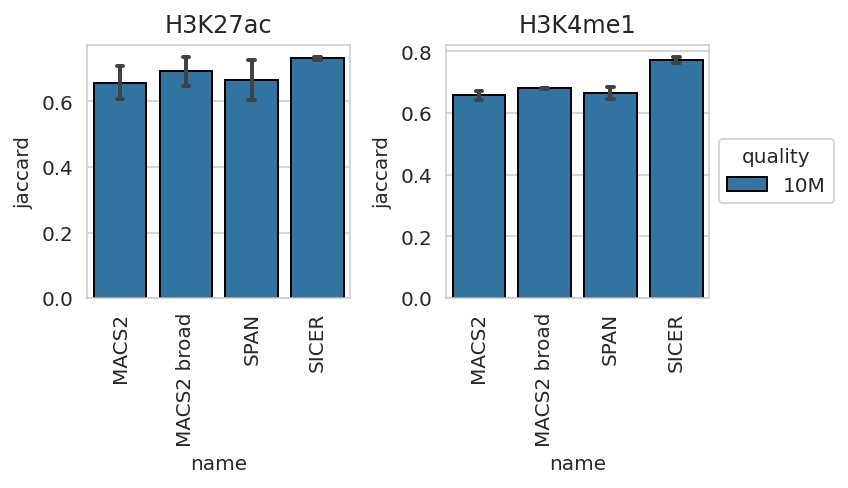

In [33]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='quality', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            # hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## Compute BAM coverage

In [104]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [35]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams.sample(3)

  0%|          | 0/206 [00:00<?, ?it/s]

bam_file modification     cell  \
18  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   
60  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     K562   
63  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     K562   

   replicate    reads dataset  
18      rep2  5783112  ENCODE  
60      rep2  7439053  ENCODE  
63      rep2  6056281  ENCODE

In [36]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams.sample(3)

  0%|          | 0/35 [00:00<?, ?it/s]

bam_file modification   cell  \
7   /home/jetbrains/data/2023_Immune/bams/BCell_H3...     H3K27me3  BCell   
2   /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K4me3  TCell   
10  /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K27ac  TCell   

   replicate     reads  dataset  
7             26056228  Roadmap  
2             28746534  Roadmap  
10            30425955  Roadmap

In [1400]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

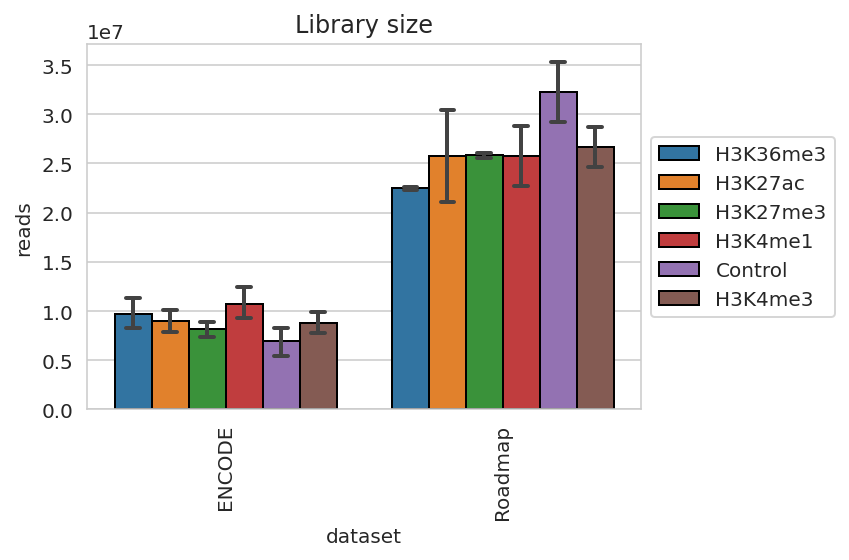

In [1401]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

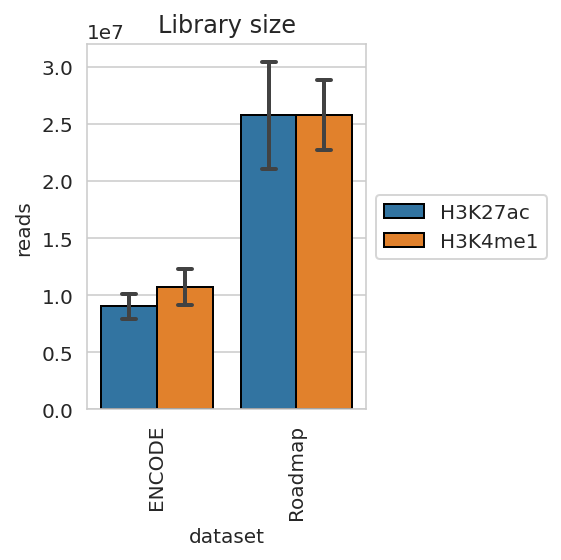

In [1402]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams[(df_bams['modification'] == 'H3K27ac') | (df_bams['modification'] == 'H3K4me1')],
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.1, errwidth=2, edgecolor="black",
                        )
# ax.set_ylim(0, 160_000)
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Prepare datasets with wiggling and mixing control data into signal track

In [2158]:
# Prepare BAM files

WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_mix')
! mkdir -p {WD}/bed

df_bam_beds = df_bams[(df_bams['modification'].isin(['H3K27ac', 'H3K4me1', 'Control'])) & 
                      # (df_bams['cell'].isin(['GM12878', 'K562', 'Huvec', 'HMEC', 'NHEK'])) & # LIMIT number of peaks
                      # (df_bams['replicate'] == 'rep2') &
                      (df_bams['dataset'] == 'ENCODE')].copy()
df_bam_beds

bam_file modification     cell  \
2    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHEK   
4    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     K562   
5    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     K562   
7    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    HepG2   
9    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHEK   
10   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HMEC   
12   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HMEC   
13   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  GM12878   
14   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HSMM   
15   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control       H1   
16   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HMEC   
17   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    Huvec   
18   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   
20   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHLF   
22   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    Huvec   
23   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHLF   
25   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1       H1   
26   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    HepG2   
27   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    Huvec   
28   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHLF   
29   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HSMM   
30   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HMEC   
35   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    HepG2   
41   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HSMM   
43   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HMEC   
49   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHEK   
51   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac       H1   
53   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    HepG2   
55   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     K562   
56   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    Huvec   
58   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     K562   
59   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHEK   
63   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     K562   
68   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     K562   
70   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    HepG2   
71   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHLF   
72   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   
73   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HSMM   
74   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  GM12878   
78   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    Huvec   
81   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHLF   
82   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1       H1   
83   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HSMM   
84   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHLF   
86   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHEK   
87   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHEK   
88   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  GM12878   
89   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HMEC   
95   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    Huvec   
98   /home/jetbrains/data/2023_GSE26320/bams/G

In [2156]:
beds = []
for _, (bam_file, m, c, r, _, _) in df_bam_beds.iterrows():
    bed_file = f'{WD}/bed/{os.path.basename(bam_file).replace(".bam", ".bed")}'
    print(bed_file)
    beds.append(bed_file)
    if not os.path.exists(bed_file):
        ! bamToBed -i {bam_file} > {bed_file}
df_bam_beds['bed_file'] = beds
df_bam_beds.sample(3)

/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646441_K562_H3K4me1_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646356_HepG2_H3K27ac_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646473_NHEK_Input_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646317_GM12878_H3K27ac_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646477_NHLF_H3K27ac_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646415_Huvec_H3K27ac_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646431_Huvec_Input_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646391_HMEC_Input_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646371_HepG2_Input_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646381_HMEC_H3K4me1_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646421_Huvec_H3K4me1_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646453_K562_Input_rep2.bed
/home/jetbrains/da

bam_file modification  cell  \
81  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  NHLF   
43  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  HMEC   
30  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  HMEC   

   replicate     reads dataset  \
81      rep2  14040463  ENCODE   
43      rep2  13989144  ENCODE   
30      rep2  10342115  ENCODE   

                                             bed_file  
81  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
43  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
30  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

## Wiggle

In [2157]:
! mkdir -p {WD}/bams

tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
tf3 = tempfile.mktemp()
tf4 = tempfile.mktemp()

# NUPSCALE = 20
NUPSCALE = 10

# for var_upscale, var_wiggle in tqdm(product([1, 2], [0, 5000])):
for var_upscale, var_wiggle in tqdm(product([2], [0, 2000])):
    if var_upscale == 1 and var_wiggle == 0:
        continue
    var_name = '' if var_upscale == 1 else f'x{var_upscale}_N{NUPSCALE}'
    if var_wiggle != 0:
        if var_name != '':
            var_name += '_'
        var_name += f'w80_20_N{var_wiggle}'
    print('upscale', var_upscale, 'wiggle', var_wiggle, 'Type', var_name)

    wiggles = []
    for _, row in tqdm(df_bam_beds.iterrows()):
        bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
        print(var_name, m, c, r, bed_file)
        if m == 'Control':
            wiggles.append(None)
            ! ln -sf {bam_file} {WD}/bams/{os.path.basename(bam_file)} 
            continue
        cs = 0.8 
        cw = 1.0 - cs    
        print('Signal', cs, 'wiggle', cw)
        result_file = f'{WD}/bams/{m}_{c}_{r}_{var_name}.bam'
        wiggles.append(result_file)
        print(result_file)
        if os.path.exists(result_file):
            continue
        t = pd.read_csv(bed_file, sep='\t', header=None)
        print('Reads', len(t))
    
        if var_upscale != 1:
            print('Upscale coverage')
            if var_upscale == 2:
                t_copy = t.copy()  # Double coverage
            elif var_upscale == 1.5:
                t_copy = t.sample(int(len(t) * 0.5)).copy() # +50% coverage
            else:
                raise Exception(f'Unknown var_upscale {var_upscale}')
            delta_small = [int(x) for x in np.random.normal(0, NUPSCALE, size=len(t_copy))]
            t_copy[1] += delta_small
            t_copy[2] += delta_small
            del delta_small
            # Ensure generated reads have proper coordinates
            t_copy.loc[t_copy[1] < 1, 1] = 1
            t_copy.loc[t_copy[2] < 1, 2] = 1
            t = pd.concat([t, t_copy]).reset_index(drop=True) 
            print('Upscaled coverage', len(t))
        
        if var_wiggle != 0:
            print('wiggle')
            signal = t.sample(int(len(t) * cs))
            noise = t.sample(int(len(t) * cw))
            delta = [int(x) for x in np.random.normal(0, var_wiggle, size=len(noise))]
            noise[1] += delta
            noise[2] += delta
            # Ensure generated reads have proper coordinates
            noise.loc[noise[1] < 1, 1] = 1
            noise.loc[noise[2] < 1, 2] = 1
            signal.to_csv(tf1, sep='\t', index=False, header=None)
            noise.to_csv(tf2, sep='\t', index=False, header=None)
            del t, signal, noise, delta
            ! cat {tf1} > {tf3}
            ! cat {tf2} >> {tf3}
            ! rm {tf1} {tf2}
        else:
            t.to_csv(tf3, sep='\t', index=False, header=None)
            del t
        ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
        ! rm {tf3}
        ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
        ! rm {tf4}
        print('Done', result_file)
    df_bam_beds[var_name] = wiggles
df_bam_beds.sample(3)

0it [00:00, ?it/s]

upscale 2 wiggle 0 Type x2_N10


0it [00:00, ?it/s]

x2_N10 H3K4me1 K562 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646441_K562_H3K4me1_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_K562_rep2_x2_N10.bam
x2_N10 H3K27ac HepG2 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646356_HepG2_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HepG2_rep2_x2_N10.bam
x2_N10 Control NHEK rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646473_NHEK_Input_rep2.bed
x2_N10 H3K27ac GM12878 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646317_GM12878_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_GM12878_rep2_x2_N10.bam
x2_N10 H3K27ac NHLF rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646477_NHLF_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHLF

0it [00:00, ?it/s]

x2_N10_w80_20_N2000 H3K4me1 K562 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646441_K562_H3K4me1_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_K562_rep2_x2_N10_w80_20_N2000.bam
x2_N10_w80_20_N2000 H3K27ac HepG2 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646356_HepG2_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HepG2_rep2_x2_N10_w80_20_N2000.bam
x2_N10_w80_20_N2000 Control NHEK rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646473_NHEK_Input_rep2.bed
x2_N10_w80_20_N2000 H3K27ac GM12878 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646317_GM12878_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_GM12878_rep2_x2_N10_w80_20_N2000.bam
x2_N10_w80_20_N2000 H3K27ac NHLF rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646477_NHLF_H3K27ac_rep2.b

bam_file modification  cell  \
63  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  K562   
30  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  HMEC   
89  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  HMEC   

   replicate     reads dataset  \
63      rep2   6056281  ENCODE   
30      rep2  10342115  ENCODE   
89      rep2   9860687  ENCODE   

                                             bed_file  \
63  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
30  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
89  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                               x2_N10  \
63                                               None   
30                                               None   
89  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                  x2_N10_w80_20_N2000  
63                                               None  
30                                               None  
89  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

## Mix control

In [ ]:
# mixtures = []
# for _, row in tqdm(df_bam_beds.iterrows()):
#     bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
#     if m == 'Control':
#         mixtures.append(None)
#         continue
#     print('Mix', m, c, r)
#     result_file = f'{WD}/bams/{m}_{c}_{r}_mix.bam'
#     mixtures.append(result_file)
#     print(result_file)
#     if os.path.exists(result_file):
#         continue
#     control_file = df_bam_beds[(df_bam_beds['cell'] == c) & 
#                                (df_bam_beds['replicate'] == r) & 
#                                (df_bam_beds['modification'] == 'Control')]['bed_file'].values[0]
#     signal = pd.read_csv(bed_file, sep='\t', header=None)
#     noise = pd.read_csv(control_file, sep='\t', header=None)
#     signal_reads = len(signal)
#     control_reads = len(noise)
#     print('Signal', bed_file, signal_reads)
#     print('Control', control_file, control_reads)
#     signal = signal.sample(int(signal_reads * 0.5))
#     noise = noise.sample(min(signal_reads, int(control_reads * 0.5)))
#     signal.to_csv(tf1, sep='\t', index=False, header=None)
#     noise.to_csv(tf2, sep='\t', index=False, header=None)
#     ! cat {tf1} > {tf3}
#     ! cat {tf2} >> {tf3}
#     ! rm {tf1} {tf2}
#     ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
#     ! rm {tf3}
#     ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
#     ! rm {tf4}
#     del signal, noise
#     print('Done')
# 
# df_bam_beds['mix'] = mixtures 
# df_bam_beds.sample(3)

## Estimate generated BAMs

In [2159]:
df_wiggle_bams = load_bams(WD + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
df_wiggle_bams.sample(3)

  0%|          | 0/173 [00:00<?, ?it/s]

bam_file modification  cell  \
24  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  HSMM   
56  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  HSMM   
7   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  HMEC   

   replicate     reads  
24      rep2  16759432  
56      rep1  22582659  
7       rep1  21881489

In [2161]:
df_wiggle_bams['type'] = [re.sub('.*rep[12]_|\.bam|_q.*|-W.*|_broad.*|_100_.*', '', os.path.basename(f)) for f in df_wiggle_bams['bam_file']]
df_wiggle_bams['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in df_wiggle_bams['type']]
df_wiggle_bams['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in df_wiggle_bams['type']]
# # Limit to x2_N20 and wiggle 5000
# df_wiggle_bams = df_wiggle_bams[(df_wiggle_bams['upscale'] != 1.5) &
#                                 (~df_wiggle_bams['type'].str.contains('N100')) &
#                                 (df_wiggle_bams['wiggle'] != 2000)]

df_wiggle_bams

bam_file modification     cell  \
0   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     K562   
1   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHEK   
3   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
4   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
..                                                ...          ...      ...   
63  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
64  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
65  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
66  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
67  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HMEC   

   replicate     reads                 type  upscale  wiggle  
0       rep2  12360187  x2_N10_w80_20_N2000      2.0  2000.0  
1       rep1  16160664               x2_N10      2.0     NaN  
2       rep1  18755229  x2_N10_w80_20_N2000      2.0  2000.0  
3       rep2  16416791  x2_N10_w80_20_N2000      2.0  2000.0  
4       rep1  20920470               x2_N10      2.0     NaN  
..       ...       ...                  ...      ...     ...  
63      rep2  11566223  x2_N10_w80_20_N2000      2.0  2000.0  
64      rep2  15362759  x2_N10_w80_20_N2000      2.0  2000.0  
65      rep2  15362760               x2_N10      2.0     NaN  
66      rep1   9108455  x2_N10_w80_20_N2000      2.0  2000.0  
67      rep2  19721374               x2_N10      2.0     NaN  

[68 rows x 8 columns]

In [2162]:
df_immune_10m_bams = load_bams(IMMUNE_PATH + '_mln_control/bams', ['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], None)
df_immune_10m_bams.sample(3)

  0%|          | 0/10 [00:00<?, ?it/s]

bam_file modification   cell  \
3  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   
0  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
2  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   

  replicate     reads  
3             9999314  
0             9998693  
2            10002191

In [2163]:
t = df_wiggle_bams.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']

t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
t2['wiggle'] = 0.0

t3 = df_immune_10m_bams.copy()
t3['scale'] = 2.2
t3['wiggle'] = 0.0

t = pd.concat([t, t2, t3]).reset_index(drop=True)

H3K27ac
H3K4me1


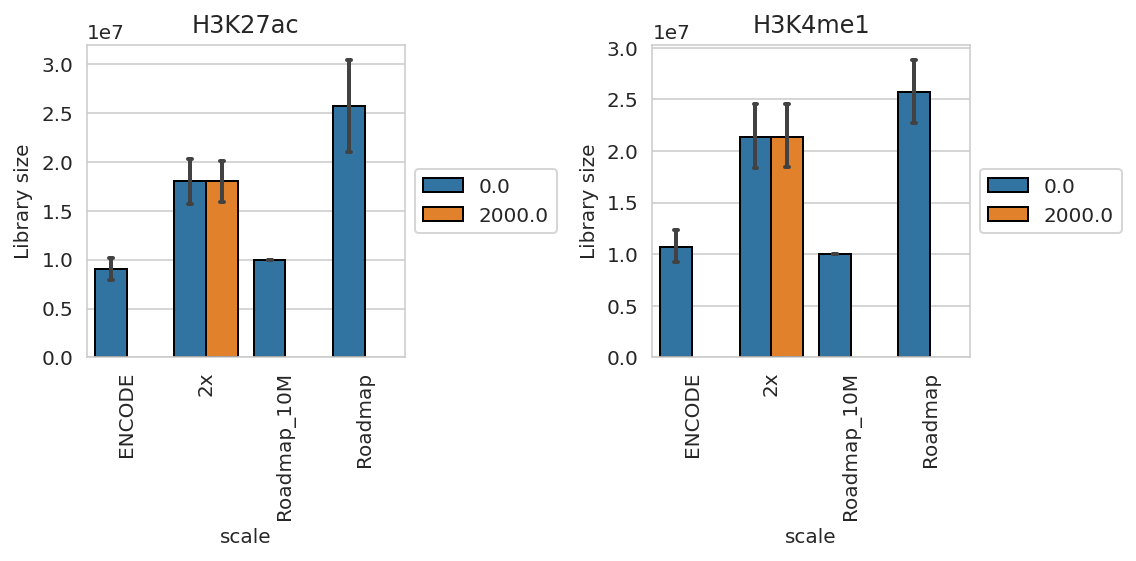

In [2165]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]

    g_results = sns.barplot(data=t[t['modification'] == m],
                            hue='wiggle', x='scale', y='reads', ax=ax,
                            capsize=.05, errwidth=2, edgecolor="black",
                        )
    # ax.set_xticklabels(['ENCODE',  '1x', '1.5x', '2x', 'Roadmap_10M', 'Roadmap'])
    ax.set_xticklabels(['ENCODE', '2x', 'Roadmap_10M', 'Roadmap'])
    ax.set_title(m)
    ax.set_ylabel('Library size')
    # Put a legend to the right of the current axis
    g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=True sicer=True --rerun-trigger mtime && \
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 

```

# Analyze wiggle and scaling

In [2295]:
wiggle_mix_peaks = load_peaks_path(WD, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)

  0%|          | 0/544 [00:00<?, ?it/s]

MACS2 68


  0%|          | 0/544 [00:00<?, ?it/s]

MACS2 broad 68


  0%|          | 0/68 [00:00<?, ?it/s]

SICER 68


  0%|          | 0/69 [00:00<?, ?it/s]

SPAN 68


In [2296]:
wiggle_mix_peaks['type'] = [re.sub('.*rep[12]_|_q.*|-W.*|_broad.*|_100_.*', '', os.path.basename(f)) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_mix_peaks['type']]
wiggle_mix_peaks['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_mix_peaks['type']]
wiggle_mix_peaks.sample(5)

file modification   cell  \
214  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   HMEC   
217  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  HepG2   
109  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     H1   
124  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HMEC   
70   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   HMEC   

    replicate   peaks         tool                 type  upscale  wiggle  
214      rep2   34973         SPAN  x2_N10_w80_20_N2000      2.0  2000.0  
217      rep1   95264         SPAN               x2_N10      2.0     NaN  
109      rep2       4  MACS2 broad  x2_N10_w80_20_N2000      2.0  2000.0  
124      rep2  131530  MACS2 broad  x2_N10_w80_20_N2000      2.0  2000.0  
70       rep1   43537  MACS2 broad               x2_N10      2.0     NaN

In [2297]:
t = wiggle_mix_peaks.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
              (df_peaks['dataset'] == 'ENCODE') 
              # & (df_peaks['replicate'] == 'rep1')
].copy()
t2['scale'] = 0.5
t2['upscale'] = 1.0
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'
wiggle_mix_original_peaks = pd.concat([t2, t]).reset_index(drop=True)
wiggle_mix_original_peaks

file modification     cell  \
0    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    HepG2   
1    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac  GM12878   
2    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac       H1   
3    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac     NHLF   
4    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    HepG2   
..                                                 ...          ...      ...   
403  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   
404  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
405  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
406  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
407  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1       H1   

    replicate   peaks   tool dataset  scale  upscale  wiggle  \
0        rep2   26021  MACS2  ENCODE    0.5      1.0     0.0   
1        rep2   43917  MACS2  ENCODE    0.5      1.0     0.0   
2        rep1   17497  MACS2  ENCODE    0.5      1.0     0.0   
3        rep2   61193  MACS2  ENCODE    0.5      1.0     0.0   
4        rep1   48652  MACS2  ENCODE    0.5      1.0     0.0   
..        ...     ...    ...     ...    ...      ...     ...   
403      rep1   49036   SPAN     NaN    2.0      2.0     0.0   
404      rep1   35061   SPAN     NaN    2.0      2.0     0.0   
405      rep2  137237   SPAN     NaN    2.0      2.0     0.0   
406      rep2   82036   SPAN     NaN    2.0      2.0  2000.0   
407      rep2  120608   SPAN     NaN    2.0      2.0  2000.0   

                    type  
0                 ENCODE  
1                 ENCODE  
2                 ENCODE  
3                 ENCODE  
4                 ENCODE  
..                   ...  
403               x2_N10  
404               x2_N10  
405               x2_N10  
406  x2_N10_w80_20_N2000  
407  x2_N10_w80_20_N2000  

[408 rows x 11 columns]

H3K27ac NHEK rep1
H3K27ac HMEC rep1
H3K27ac GM12878 rep1
H3K27ac Huvec rep1
H3K27ac H1 rep1
H3K27ac HSMM rep1
H3K27ac NHLF rep1
H3K27ac K562 rep1
H3K27ac HepG2 rep1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac NHEK rep2
H3K27ac HMEC rep2
H3K27ac GM12878 rep2
H3K27ac Huvec rep2
H3K27ac H1 rep2
H3K27ac HSMM rep2
H3K27ac NHLF rep2
H3K27ac K562 rep2
H3K27ac HepG2 rep2
H3K4me1 NHEK rep1
H3K4me1 HMEC rep1
H3K4me1 GM12878 rep1
H3K4me1 Huvec rep1
H3K4me1 H1 rep1
H3K4me1 HSMM rep1
H3K4me1 NHLF rep1
H3K4me1 K562 rep1
H3K4me1 HepG2 rep1
H3K4me1 NHEK rep2
H3K4me1 HMEC rep2
H3K4me1 GM12878 rep2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 Huvec rep2
H3K4me1 H1 rep2
H3K4me1 HSMM rep2
H3K4me1 NHLF rep2
H3K4me1 K562 rep2
H3K4me1 HepG2 rep2


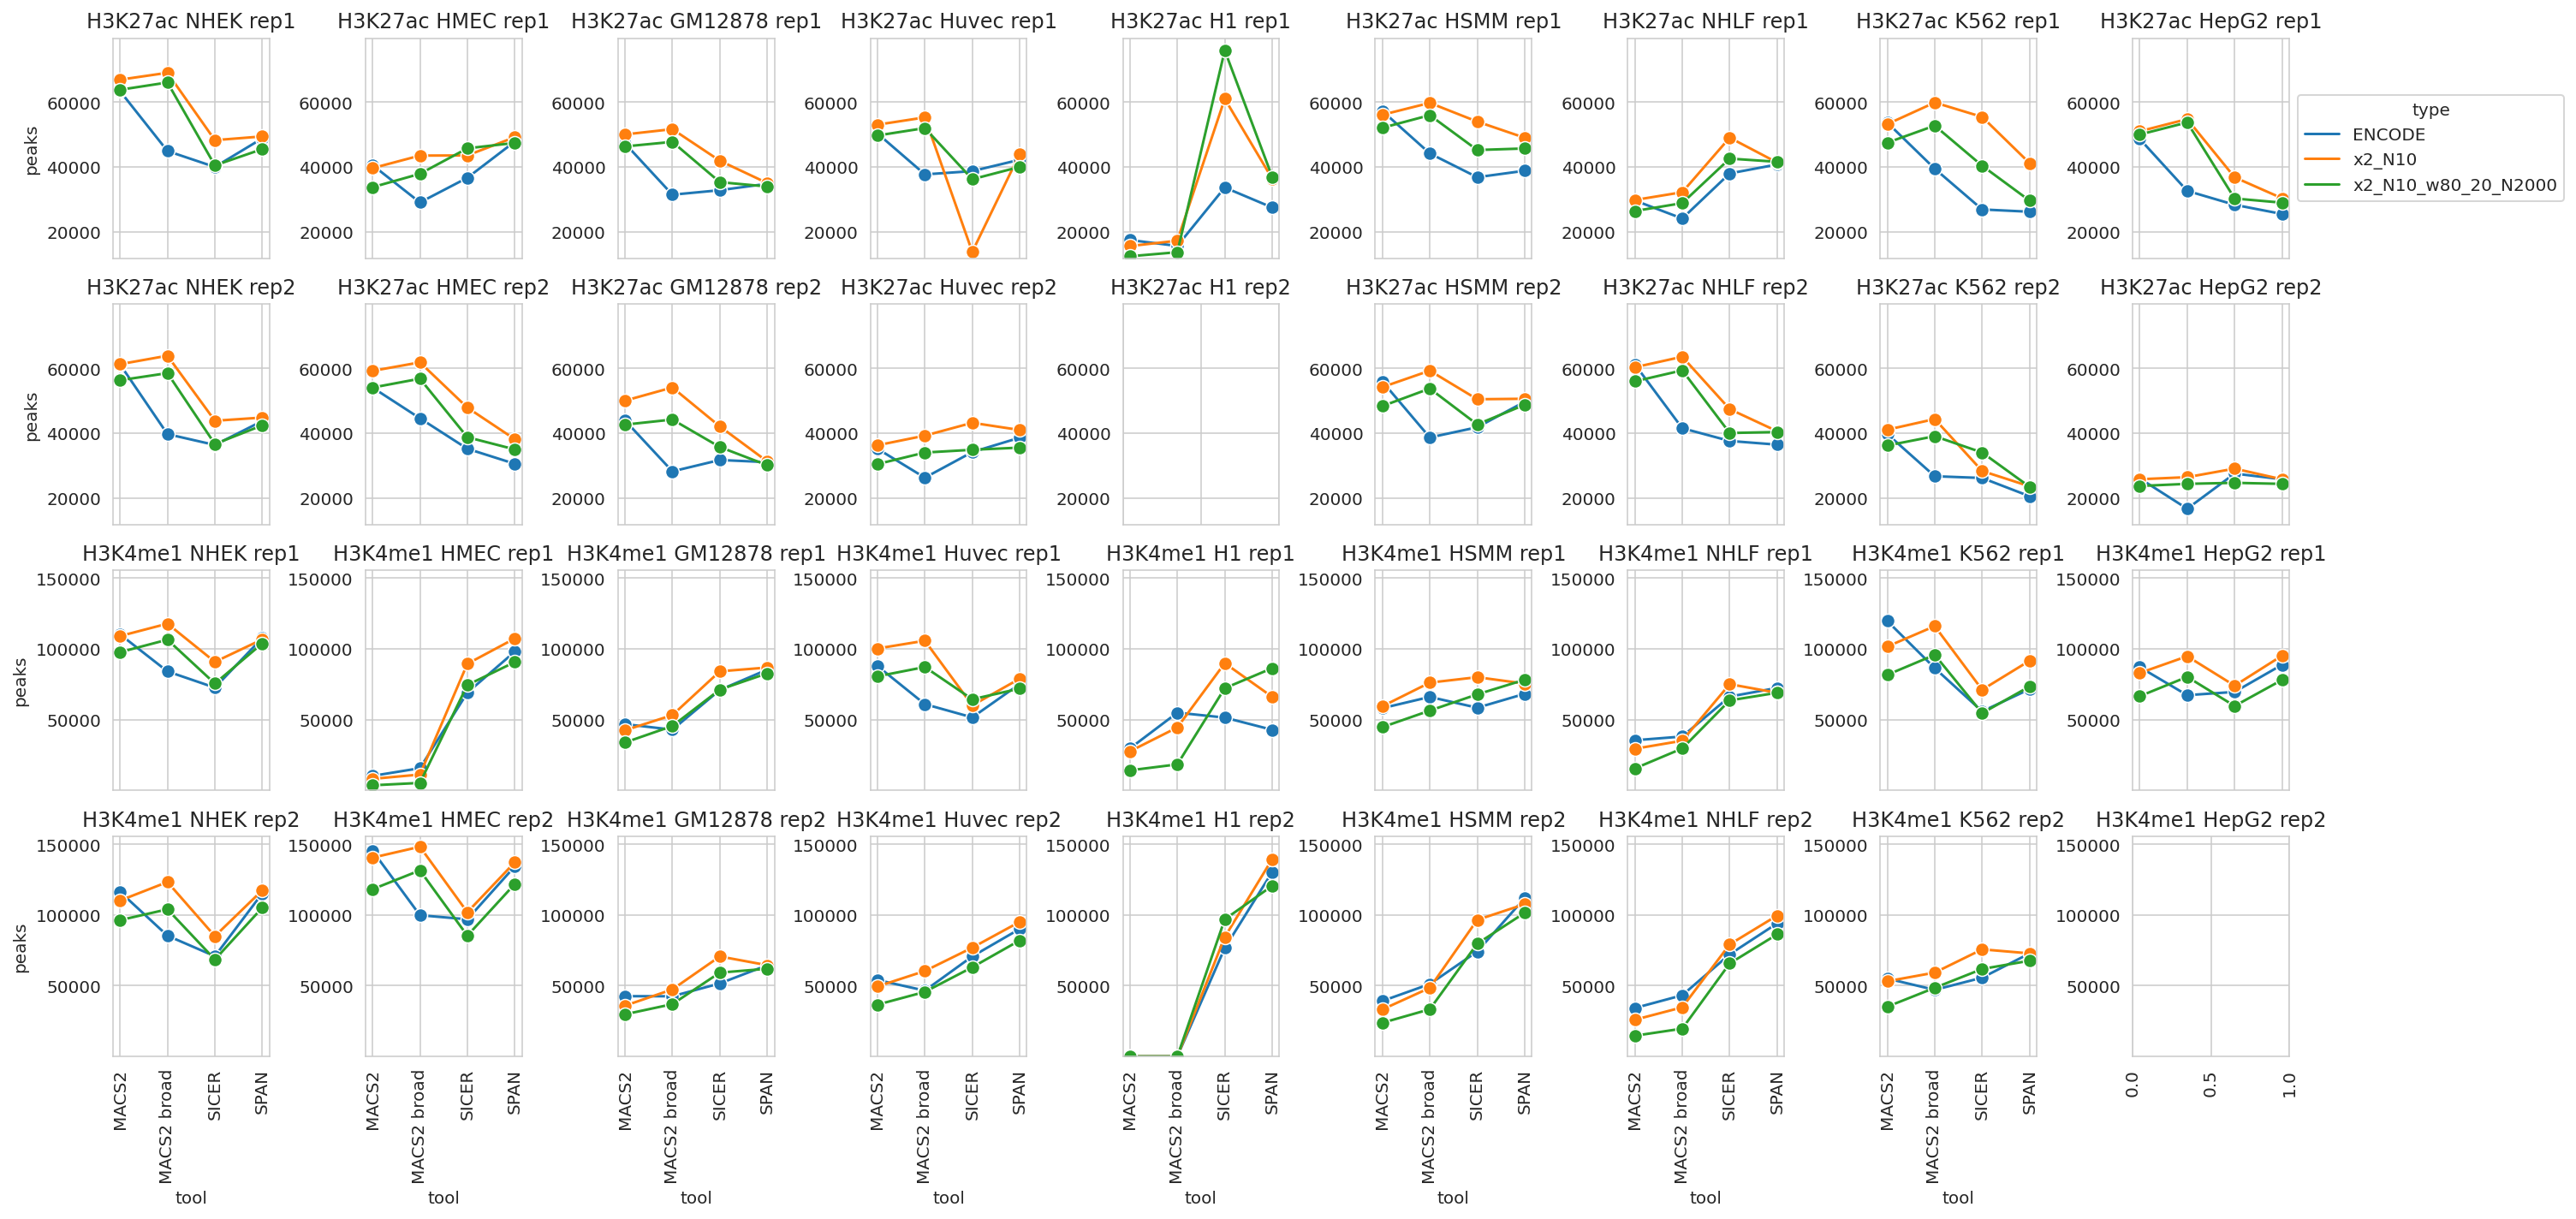

In [2298]:
plt.figure(figsize=(21, 10))
CELLS = list(wiggle_mix_peaks['cell'].unique())
# CELLS = ['GM12878', 'K562', 'Huvec'] 
axs = [plt.subplot(4, len(CELLS), i + 1) for i in range(2 * len(CELLS) * 2)]

for i, (m, r, c) in enumerate(product(['H3K27ac', 'H3K4me1'], GSE26320_REPS, CELLS)):
    print(m, c, r)
    ax = axs[i]
    g_results = sns.lineplot(data=wiggle_mix_original_peaks[(wiggle_mix_original_peaks['modification']==m) &
                                                            (wiggle_mix_original_peaks['cell'] == c) &
                                                            (wiggle_mix_original_peaks['replicate'] == r)],
                             x='tool', y='peaks', hue='type',
                             hue_order=list(sorted(wiggle_mix_original_peaks['type'].unique())),
                             ax=ax,
                             # errorbar='se', 
                             marker='o', markersize=8
                             )
    if i + 1 == len(CELLS):
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i % len(CELLS) != 0:
        ax.set_ylabel(None)
    if i < len(CELLS) * 3:
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])   
        ax.set_xlabel(None)
    else:
        ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m} {c} {r}')
    ax.set_ylim(bottom = 0.95 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].min(),
                top = 1.05 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].max())
plt.tight_layout()
plt.show()

## Peaks lengths

In [2299]:
print('Load lengths')
ts = []
for file, m, c, r, ty, tool in tqdm(zip(
        wiggle_mix_original_peaks['file'],
        wiggle_mix_original_peaks['modification'],
        wiggle_mix_original_peaks['cell'],
        wiggle_mix_original_peaks['replicate'],
        wiggle_mix_original_peaks['type'],
        wiggle_mix_original_peaks['tool']
)):
    # if c in ['H1', 'GM12878', 'HSMM', 'NHLF', 'HMEC']:
    #     continue
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 1000)).copy()
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length modification   cell replicate                 type         tool
258637     311      H3K4me1   HSMM      rep1  x2_N10_w80_20_N2000  MACS2 broad
364256     770      H3K27ac  HepG2      rep1  x2_N10_w80_20_N2000         SPAN
328378    2599      H3K27ac   NHEK      rep2               x2_N10        SICER
110252     345      H3K4me1   NHLF      rep1               ENCODE         SPAN
195591     309      H3K4me1  HepG2      rep1  x2_N10_w80_20_N2000        MACS2
336618    1647      H3K27ac  Huvec      rep2               x2_N10         SPAN
392059     436      H3K4me1   NHEK      rep2  x2_N10_w80_20_N2000         SPAN
34161      885      H3K27ac   HSMM      rep1               ENCODE  MACS2 broad
74267     2999      H3K4me1     H1      rep2               ENCODE        SICER
322027    3399      H3K27ac     H1      rep1               x2_N10        SICER

H3K27ac MACS2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SPAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SICER
H3K4me1 MACS2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SPAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SICER


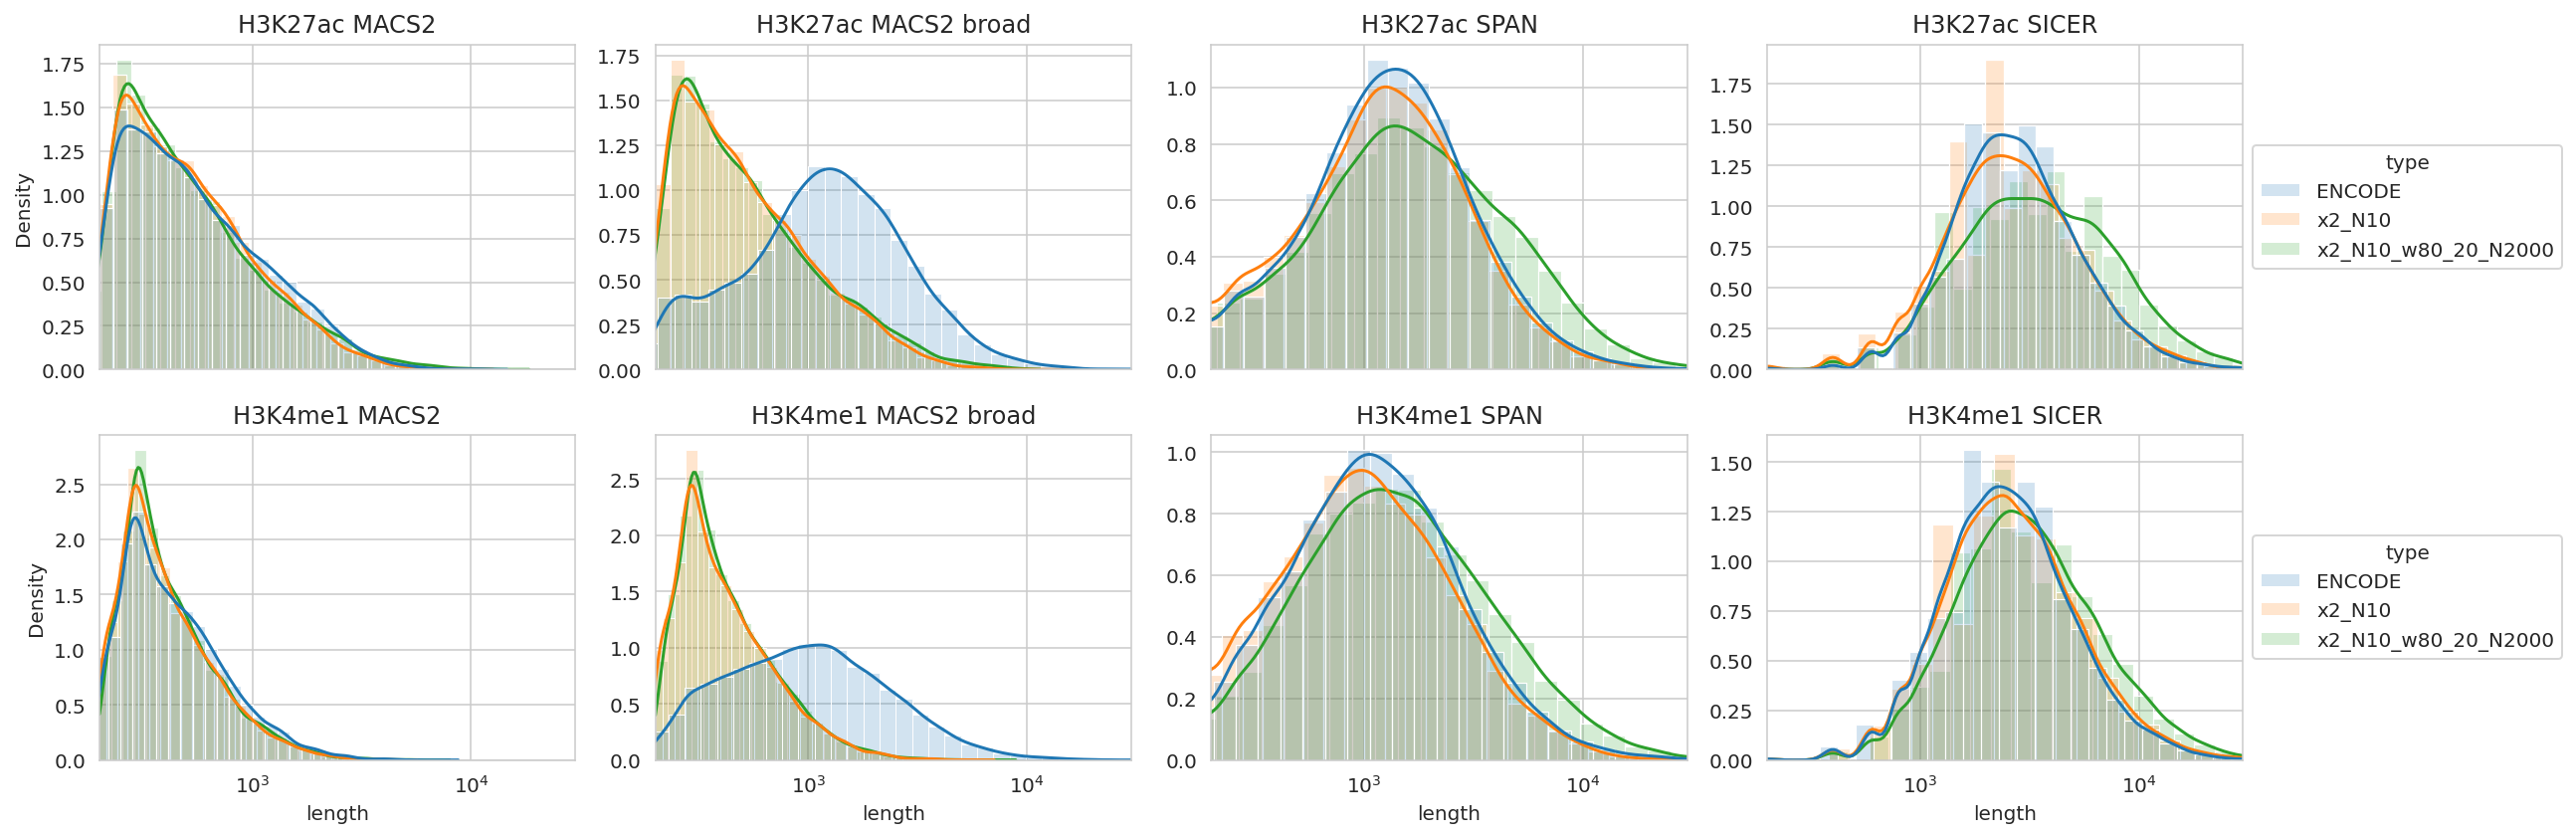

In [2300]:
plt.figure(figsize=(18, 6))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, len(TOOLS), i + 1) for i in range(2 * len(TOOLS))]

for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification']==m) &
                                    (t['tool'].isin([tool]))],
                             x='length', hue='type',
                             hue_order=list(sorted(t['type'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2
                             )
    if (i + 1) % len(TOOLS) != 0:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if i % len(TOOLS) != 0:
        ax.set_ylabel(None)
    if i < len(TOOLS):
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {tool}')
    ax.set_xlim(2e2, 3e4)
plt.tight_layout()
plt.show()

H3K27ac MACS2
H3K27ac MACS2 broad
H3K27ac SPAN
H3K27ac SICER
H3K4me1 MACS2
H3K4me1 MACS2 broad
H3K4me1 SPAN
H3K4me1 SICER


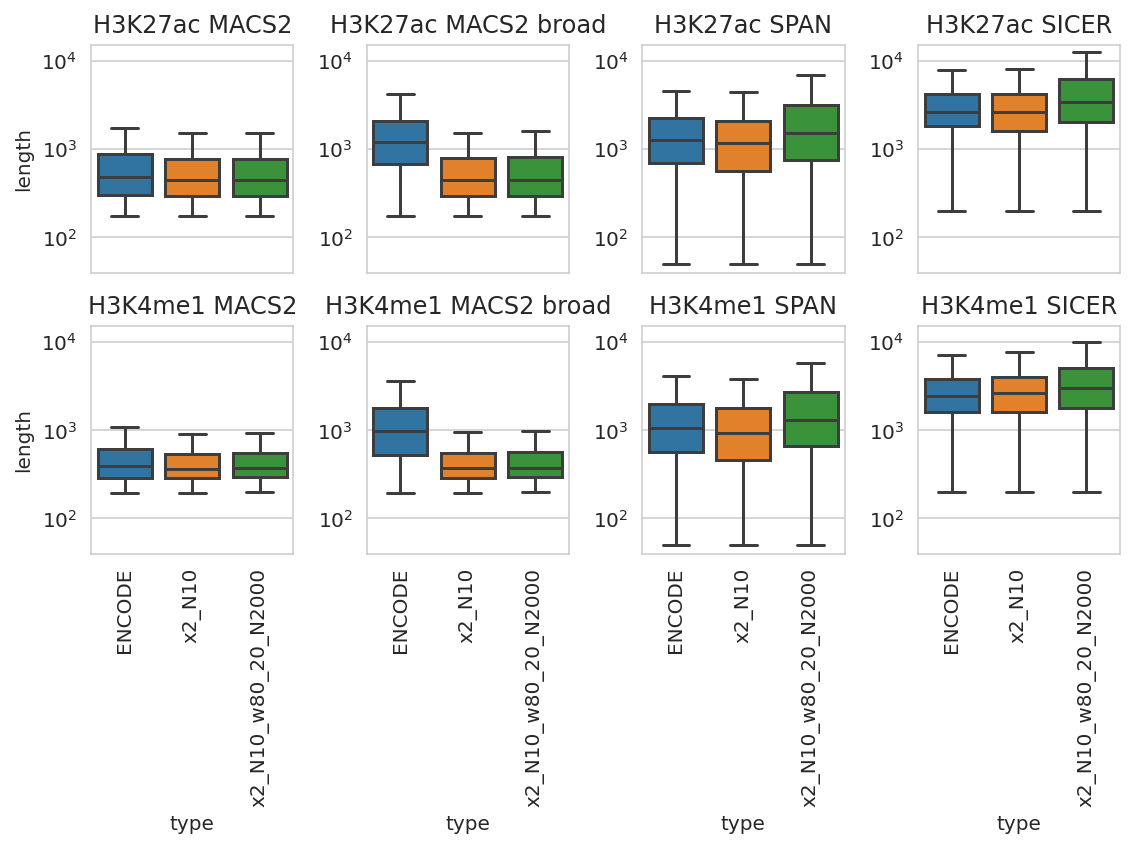

In [2301]:
plt.figure(figsize=(8, 6))
TYPES = list(sorted(t['type'].unique()))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, len(TOOLS), i + 1) for i in range(2 * len(TOOLS))]

for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    g_results = sns.boxplot(data=t[(t['modification']==m) &
                                    (t['tool'].isin([tool]))],
                             y='length', x='type',
                             showfliers=False,
                             order=TYPES,
                             ax=ax, 
                             )
    if i not in [0, len(TOOLS)]:
        ax.set_ylabel(None)
    if i < len(TOOLS):
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    else:
        ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m} {tool}')
    ax.set(yscale='log')
    ax.set_ylim(bottom=40, top=1.5e4)
plt.tight_layout()
plt.show()

## Compute union peaks

In [2302]:
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) &
              (df_peaks['dataset'] == 'Roadmap') &
              (df_peaks['replicate'] == '')].copy()
t2['scale'] = 2.5
t2['upscale'] = 1.0
t2['wiggle'] = 0.0
t2['type'] = 'Roadmap'

t3 = df_downsample[(df_downsample['reads'] == '10M') & 
                   (df_downsample['modification'].isin(['H3K27ac', 'H3K4me1']))].copy()
t3['scale'] = 2.2
t3['upscale'] = 0.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap_10M'

wiggle_mix_original_all_peaks = pd.concat([t2, t3, wiggle_mix_original_peaks]).reset_index(drop=True)
wiggle_mix_original_all_peaks

file modification     cell  \
0    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1    TCell   
1    /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1    BCell   
2    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K27ac    TCell   
3    /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K27ac    BCell   
4    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K27ac    TCell   
..                                                 ...          ...      ...   
435  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   
436  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
437  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
438  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
439  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1       H1   

    replicate   peaks         tool  dataset  scale  upscale  wiggle  \
0              158205        MACS2  Roadmap    2.5      1.0     0.0   
1              141414        MACS2  Roadmap    2.5      1.0     0.0   
2               57350        MACS2  Roadmap    2.5      1.0     0.0   
3               45626        MACS2  Roadmap    2.5      1.0     0.0   
4               51740  MACS2 broad  Roadmap    2.5      1.0     0.0   
..        ...     ...          ...      ...    ...      ...     ...   
435      rep1   49036         SPAN      NaN    2.0      2.0     0.0   
436      rep1   35061         SPAN      NaN    2.0      2.0     0.0   
437      rep2  137237         SPAN      NaN    2.0      2.0     0.0   
438      rep2   82036         SPAN      NaN    2.0      2.0  2000.0   
439      rep2  120608         SPAN      NaN    2.0      2.0  2000.0   

                    type  quality reads  
0                Roadmap      NaN   NaN  
1                Roadmap      NaN   NaN  
2                Roadmap      NaN   NaN  
3                Roadmap      NaN   NaN  
4                Roadmap      NaN   NaN  
..                   ...      ...   ...  
435               x2_N10      NaN   NaN  
436               x2_N10      NaN   NaN  
437               x2_N10      NaN   NaN  
438  x2_N10_w80_20_N2000      NaN   NaN  
439  x2_N10_w80_20_N2000      NaN   NaN  

[440 rows x 13 columns]

In [2595]:
! mkdir -p {WD}/union

for _, (m, c, r, ty) in tqdm(wiggle_mix_original_all_peaks[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows()):
    print(m, c, r, ty)
    t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                      (wiggle_mix_original_all_peaks['cell'] == c) &
                                      (wiggle_mix_original_all_peaks['replicate'] == r) &
                                      (wiggle_mix_original_all_peaks['type'] == ty)]
    if len(t) == 0:
        continue
    # Prepare total overlap
    union_path = f'{WD}/union/{m}_{c}_{r}_{ty}.bed'
    print(union_path)
    if os.path.exists(union_path):
        continue
    try:
        files = t[t['tool'] == 'SPAN']['file']
        t_span = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'MACS2']['file']
        t_macs2 = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'MACS2 broad']['file']
        t_macs2broad = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'SICER']['file']
        t_sicer = sorted_file(files.values[0]) if len(files) == 1 else ''
        tf = tempfile.mktemp()
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        ! rm {tf}
    except Exception as e:
        print(e)
        break

0it [00:00, ?it/s]

H3K4me1 TCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_TCell__Roadmap.bed
H3K4me1 BCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_BCell__Roadmap.bed
H3K27ac TCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_TCell__Roadmap.bed
H3K27ac BCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_BCell__Roadmap.bed
H3K4me1 BCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_BCell__Roadmap_10M.bed
H3K4me1 TCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_TCell__Roadmap_10M.bed
H3K27ac BCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_BCell__Roadmap_10M.bed
H3K27ac TCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_TCell__Roadmap_10M.bed
H3K27ac HepG2 rep2 ENCODE
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep2_ENCODE.bed
H3K27ac GM12878 rep2 ENCODE
/home/jetbrains/

## Find bigwigs

In [2596]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [2305]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
encode_bws['dataset'] = 'ENCODE'
display(encode_bws.sample(3))

immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, [''], None)
immune_bws['dataset'] = 'Roadmap'
display(immune_bws.sample(3))

  0%|          | 0/52 [00:00<?, ?it/s]

file modification  cell  \
21  /home/jetbrains/data/2023_GSE26320/bw/GSM64637...      H3K27ac  HMEC   
25  /home/jetbrains/data/2023_GSE26320/bw/GSM64634...      H3K4me1    H1   
5   /home/jetbrains/data/2023_GSE26320/bw/GSM64647...      H3K27ac  NHLF   

   replicate dataset  
21      rep2  ENCODE  
25      rep1  ENCODE  
5       rep1  ENCODE

  0%|          | 0/17 [00:00<?, ?it/s]

file modification   cell  \
9  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...      H3K4me3  TCell   
0  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...     H3K36me3  BCell   
6  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...      H3K27ac  TCell   

  replicate  dataset  
9            Roadmap  
0            Roadmap  
6            Roadmap

In [2306]:
immune_10m_bws = load_bws(IMMUNE_PATH + '_mln_control/bw', MODIFICATIONS, IMMUNE_CELLS, [''], None)
immune_10m_bws['dataset'] = 'Roadmap_10M'
display(immune_10m_bws.sample(3))

  0%|          | 0/5 [00:00<?, ?it/s]

file modification   cell  \
3  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   
0  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
2  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  TCell   

  replicate      dataset  
3            Roadmap_10M  
0            Roadmap_10M  
2            Roadmap_10M

In [2307]:
wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
wiggle_bws['type'] = [re.sub('.*rep[12]_|\.bw', '', os.path.basename(f)) for f in wiggle_bws['file']]
wiggle_bws['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_bws['type']]
wiggle_bws['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_bws['type']]

wiggle_bws.sample(5)

  0%|          | 0/86 [00:00<?, ?it/s]

file modification     cell  \
6   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
40  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    HepG2   
38  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1       H1   
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
66  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   

   replicate                 type  upscale  wiggle  
6       rep1               x2_N10      2.0     NaN  
40      rep1               x2_N10      2.0     NaN  
38      rep1  x2_N10_w80_20_N2000      2.0  2000.0  
29      rep1  x2_N10_w80_20_N2000      2.0  2000.0  
66      rep2               x2_N10      2.0     NaN

In [2308]:
t = wiggle_bws.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = encode_bws[(encode_bws['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
                (encode_bws['cell'].isin(CELLS)) 
                # & (encode_bws['replicate'] == 'rep1')
].copy()
t2['scale'] = 0.5
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'

t3 = immune_bws[immune_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t3['scale'] = 2.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap'

t4 = immune_10m_bws[immune_10m_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t4['scale'] = 2.2
t4['wiggle'] = 0.0
t4['type'] = 'Roadmap_10M'

all_bws = pd.concat([t, t2, t3, t4]).reset_index(drop=True)
all_bws

file modification   cell  \
0    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HSMM   
1    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   NHLF   
2    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  HepG2   
3    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HMEC   
4    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HMEC   
..                                                 ...          ...    ...   
105  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...      H3K27ac  BCell   
106  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
107  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   
108  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  TCell   
109  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   

    replicate                 type  upscale  wiggle  scale      dataset  
0        rep1               x2_N10      2.0     0.0    2.0          NaN  
1        rep2  x2_N10_w80_20_N2000      2.0  2000.0    2.0          NaN  
2        rep1               x2_N10      2.0     0.0    2.0          NaN  
3        rep1               x2_N10      2.0     0.0    2.0          NaN  
4        rep1  x2_N10_w80_20_N2000      2.0  2000.0    2.0          NaN  
..        ...                  ...      ...     ...    ...          ...  
105                        Roadmap      NaN     0.0    2.5      Roadmap  
106                    Roadmap_10M      NaN     0.0    2.2  Roadmap_10M  
107                    Roadmap_10M      NaN     0.0    2.2  Roadmap_10M  
108                    Roadmap_10M      NaN     0.0    2.2  Roadmap_10M  
109                    Roadmap_10M      NaN     0.0    2.2  Roadmap_10M  

[110 rows x 9 columns]

## Prepare homemade BigWig based peaks

In [2309]:
import math
import pyBigWig

def peak_calling(bw_path, chrom_sizes, blacklist, bin, top_bins):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / bin))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())
    # print(chromosomes)
    # print(chr_indx)

    print('Compute binned coverage')    
    binned_coverage = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            binned_coverage[istart: iend] =\
                np.array([x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=True, type='sum')])
    
    if blacklist is not None:
        print('Processing blacklisted regions')
        for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
            if chr not in chr_indx:
                continue
            offset = chr_indx[chr][0]
            for x in range(int(math.floor(start / bin)), int(math.ceil(end / bin)) + 1):
                binned_coverage[min(x - offset, len(binned_coverage) - 1)] = 0
    
    print('Total coverage', binned_coverage.sum())
    print('Split by chromosomes')
    if top_bins > len(binned_coverage):
        raise Exception(f'Too many top bins {top_bins} > {len(binned_coverage)}')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(binned_coverage, -top_bins)[-top_bins:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)
    # print(chr_xs)

    print('Collect final peaks')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        start = -1
        for i, x in enumerate(xs):
            if i == 0:
                start = x
            elif xs[i - 1] != x - 1:
                peaks.append((chr, (start - offset) * bin, (xs[i - 1] + 1 - offset) * bin))
                start = x
        peaks.append((chr, (start - offset) * bin, (xs[-1] + 1 - offset) * bin))
    return pd.DataFrame(peaks, columns=['chromosome', 'start', 'end'])

# BLACK LISTS:
https://github.com/Boyle-Lab/Blacklist/tree/master/lists

In [2310]:
BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

chr     start       end                   3
0    chr10         0     45700     Low Mappability
1    chr10  38481300  38596500  High Signal Region
2    chr10  38782600  38967900  High Signal Region
3    chr10  39901300  41712900  High Signal Region
4    chr10  41838900  42107300  High Signal Region
..     ...       ...       ...                 ...
631   chrY   4343800   4345800  High Signal Region
632   chrY  10246200  11041200  High Signal Region
633   chrY  11072100  11335300  High Signal Region
634   chrY  11486600  11757800  High Signal Region
635   chrY  26637300  57227400  High Signal Region

[636 rows x 4 columns]

In [2311]:
bw_path = '/home/jetbrains/data/2023_GSE26320/bw/GSM646394_HSMM_H3K27ac_rep1.bw'
bin = 5_000
top_bins = 25_000
chrom_sizes_2 = {'chr1': CHROM_SIZES['chr1'], 'chr2': CHROM_SIZES['chr2']}

# print('WITHOUT BLACKLIST')
# display(peak_calling(bw_path, chrom_sizes, bin=bin, top_bins=top_bins))
# 
print('WITH BLACKLIST')
display(peak_calling(bw_path, chrom_sizes_2, blacklist_df, bin, top_bins))

WITH BLACKLIST
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 150922243.0
Split by chromosomes
Collect final peaks


chromosome      start        end
0           chr1     815000     820000
1           chr1     825000     830000
2           chr1     835000     840000
3           chr1     855000     860000
4           chr1     905000     910000
...          ...        ...        ...
11228       chr2  241605000  241620000
11229       chr2  241625000  241650000
11230       chr2  241655000  241665000
11231       chr2  241670000  241700000
11232       chr2  241720000  241735000

[11233 rows x 3 columns]

In [2535]:
chrom_sizes_3 = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

BIN = 10_000
NBINS = 25_000
HMD = f'{WD}/homemade_{BIN}bp_{NBINS}'
print(HMD)
! mkdir -p {HMD}

for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{HMD}/{m}_{c}_{r}_{ty}.bed'
    print(peaks_path)
    if os.path.exists(peaks_path):
        continue
    peaks = peak_calling(bw_path, chrom_sizes_3, blacklist_df, BIN, NBINS)
    peaks.to_csv(peaks_path, sep='\t', header=False, index=None)

/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_25000


  0%|          | 0/110 [00:00<?, ?it/s]

H3K4me1 HSMM rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HSMM_rep1_x2_N10.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_25000/H3K4me1_HSMM_rep1_x2_N10.bed
H3K27ac NHLF rep2 x2_N10_w80_20_N2000
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_25000/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bed
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 284773608.0
Split by chromosomes
Collect final peaks
H3K4me1 HepG2 rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HepG2_rep1_x2_N10.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_25000/H3K4me1_HepG2_rep1_x2_N10.bed
H3K4me1 HMEC rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HMEC_rep1_x2_N10.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_25000/H3K4me1_HMEC_rep1_x2_N10.bed
H3K4me1 

## Compare homemade peaks with others

In [2536]:
# homemade_compare = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'type', 'tool',
#                                          'tool_peaks', 'tool_len', 'homemade_peaks', 'homemade_len',
#                                          'overlap1', 'overlap2', 'overlap_len'])
# 
# for _, (m, c, r, ty) in tqdm(wiggle_mix_original_all_peaks[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows()):
#     print(m, c, r, ty)
#     homemade_file = f'{HMD}/{m}_{c}_{r}_{ty}.bed'
#     if not os.path.exists(homemade_file):
#         continue
#     homemade_file = sorted_file(homemade_file)
#     homemade_peaks = lines(homemade_file)
#     homemade_len = bedl(homemade_file).sum()
#     
#     t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
#                                       (wiggle_mix_original_all_peaks['cell'] == c) &
#                                       (wiggle_mix_original_all_peaks['replicate'] == r) &
#                                       (wiggle_mix_original_all_peaks['type'] == ty)]
#     if len(t) == 0:
#         continue
#     for tool in TOOLS:
#         files = t[t['tool'] == tool]['file']
#         if len(files) == 0:
#             continue
#         print(tool, files.values[0])
#         tf = tempfile.mktemp()
#         tf2 = tempfile.mktemp()
#         # Filter first 3 chromosomes only
#         t_file = pd.read_csv(sorted_file(files.values[0]), sep='\t', header=None)
#         t_file[t_file[0].isin(['chr1', 'chr2', 'chr3'])].to_csv(tf, sep='\t', header=False, index=None)
#         # ! T=$'\t'; grep -E "chr[123]$T" {t_file} > {tf}
#         tool_peaks = lines(tf)
#         tool_len = bedl(tf).sum()
#         !bedtools intersect -a {homemade_file} -b {tf} -wa -u > {tf2}
#         overlap2 = lines(tf2)
#         !bedtools intersect -b {homemade_file} -a {tf} -wa -u > {tf2}
#         overlap1 = lines(tf2)
#         !bedtools intersect -a {homemade_file} -b {tf} -wo > {tf2}
#         overlap_len = int(last_col(tf).sum())
#         homemade_compare.loc[len(homemade_compare)] = \
#             (m, c, r, ty, tool,
#              tool_peaks, tool_len,
#              homemade_peaks, homemade_len, overlap1, overlap2, overlap_len)
#     
# homemade_compare.sample(5)

In [2537]:
# homemade_compare['jaccard'] = [
#     d(o, p + g - o)
#     for p, g, o in zip(homemade_compare['tool_len'], homemade_compare['homemade_len'], homemade_compare['overlap_len'])
# ]
# 
# homemade_compare['overlap1f'] = [
#     d(o, t)
#     for t, o in zip(homemade_compare['tool_peaks'], homemade_compare['overlap1'])
# ]
# homemade_compare['overlap2f'] = [
#     d(o, t)
#     for t, o in zip(homemade_compare['homemade_peaks'], homemade_compare['overlap2'])
# ]
# 
# homemade_compare.sample(1)

In [2538]:
# plt.figure(figsize=(5, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='type', y='homemade_peaks', ax=ax,
#                             capsize=.1, errwidth=2, edgecolor="black",
#                             # order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     # if i < 1:
#     #     ax.legend().set_visible(False)
#     # else:
#     #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     # ax.set_ylim(0, 55_000)
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

In [2539]:
# plt.figure(figsize=(11, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='tool', hue='type', y='tool_peaks', ax=ax,
#                             capsize=.05, errwidth=2, edgecolor="black",
#                             order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
#                             # hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     if i < 1:
#         ax.legend().set_visible(False)
#     else:
#         sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     # ax.set_ylim(0, 55_000)
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

In [2540]:
# plt.figure(figsize=(5, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='type', y='overlap1f', ax=ax,
#                             capsize=.1, errwidth=2, edgecolor="black",
#                             # order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     ax.set_ylabel('Tool vs homemade')
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

In [2541]:
# plt.figure(figsize=(5, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='type', y='overlap2f', ax=ax,
#                             capsize=.1, errwidth=2, edgecolor="black",
#                             # order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     ax.set_ylabel('Homemade vs tool')
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

In [2542]:
# plt.figure(figsize=(11, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='tool', hue='type', y='jaccard', ax=ax,
#                             capsize=.05, errwidth=2, edgecolor="black",
#                             order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
#                             # hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     if i < 1:
#         ax.legend().set_visible(False)
#     else:
#         sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     # ax.set_ylim(0, 55_000)
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

## Compute roughness

In [2651]:
from math import ceil
import pyBigWig

def compute_roughness(bw_path, chrom_sizes, bin, m, c, r, ty, peaks_path=None):
    if bin < 50:
        raise Exception('Too small bin size')
    rows = []
    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in chrom_sizes.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            if peaks_path is None or not os.path.exists(peaks_path):
                print('Computing roughness on chromosomes 10k-10mln')
                # TODO: process black listed regions here!!!
                for chr, chr_size in chrom_sizes.items():
                    chr_size = min(10_000_000, chr_size)
                    stats = np.array(bw.stats(chr, 100_000, chr_size, nBins=int(ceil((chr_size - 100_000) / bin)), exact=True, type='sum'))
                    rows.append((m, c, r, ty, total_coverage, f'{chr}:100000-{chr_size}', len(stats), np.sum(stats), np.std(stats)))
            else:
                print(f'Computing roughness on peaks file {peaks_path}')
                t = pd.read_csv(peaks_path, sep='\t', header=None)
                if len(t) > 1000:
                    print('Pick 1000 uniform peaks for computation speedup')
                    step = int(math.ceil(len(t) / 1000.0))
                    idxs = [False] * len(t) 
                    for i in range(0, len(t), step):
                        idxs[i] = True
                    t = t.loc[idxs].copy()  
                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in chrom_sizes:
                        stats = np.array(bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True, type='sum'))
                        rows.append((m, c, r, ty, total_coverage, f'{chr}:{start}-{end}', len(stats), np.sum(stats), np.std(stats)))
    except Exception as e:
        print(e)
        pass  # Ignore

    df_roughness = pd.DataFrame(rows,
                                columns=['modification', 'cell', 'replicate', 'type', 'coverage', 'position', 'bins', 'ra', 'rq'])
    del rows
    return df_roughness

In [2652]:
ROUGHNESS_BIN = 100  # Should be bigger than used for upscaling (N10) and resolution of bigwig file (50bp)!

chrom_sizes_3 = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{HMD}/{m}_{c}_{r}_{ty}.bed'
    # peaks_path = f'{WD}/union/{m}_{c}_{r}_{ty}.bed'
    ts.append(compute_roughness(bw_path, chrom_sizes_3, ROUGHNESS_BIN, m, c, r, ty, peaks_path=peaks_path))
    # ts.append(compute_roughness(bw_path, chrom_sizes_3, ROUGHNESS_BIN, m, c, r, ty, peaks_path=None))
    
df_roughness = pd.concat(ts).reset_index(drop=True)
del ts
df_roughness.sample(5)

  0%|          | 0/110 [00:00<?, ?it/s]

H3K4me1 HSMM rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HSMM_rep1_x2_N10.bw
Total coverage 321.60765
Computing roughness on peaks file /home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_25000/H3K4me1_HSMM_rep1_x2_N10.bed
Pick 1000 uniform peaks for computation speedup
H3K27ac NHLF rep2 x2_N10_w80_20_N2000
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bw
Total coverage 291.449
Computing roughness on peaks file /home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_25000/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bed
Pick 1000 uniform peaks for computation speedup
H3K4me1 HepG2 rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HepG2_rep1_x2_N10.bw
Total coverage 530.13305
Computing roughness on peaks file /home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_25000/H3K4me1_HepG2_rep1_x2_N10.bed
Pick 1000 uniform peaks for computation speedup
H3K4me1 HMEC rep1 x2_N10
/home/jetbrain

modification     cell replicate                 type   coverage  \
53939      H3K27ac     K562      rep2  x2_N10_w80_20_N2000  236.96955   
84168      H3K27ac     HMEC      rep2               ENCODE  161.56580   
90693      H3K4me1     NHLF      rep2               ENCODE  280.35835   
13051      H3K4me1     HMEC      rep2               x2_N10  544.14205   
10232      H3K4me1  GM12878      rep2  x2_N10_w80_20_N2000  359.25880   

                       position  bins       ra          rq  
53939  chr1:238600000-238610000   100   2350.0   62.631861  
84168    chr2:65760000-65770000   100   1600.0   32.310989  
90693    chr2:30560000-30640000   800  41250.0   73.574341  
13051  chr3:182430000-182440000   100   3800.0   72.498276  
10232    chr1:28350000-28380000   300  27500.0  136.065752

In [2653]:
df_roughness['name'] = df_roughness['type']
df_roughness.loc[df_roughness['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
df_roughness.loc[df_roughness['type'] == 'x2_N10', 'name'] = 'ENCODE Upscale'
df_roughness.loc[df_roughness['type'] == 'x2_N10_w80_20_N2000', 'name'] = 'ENCODE Upscale + Wiggle'

In [2654]:
def plot_modifications_simple(df, X, Y, text=False):
    plt.figure(figsize=(11, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        sns.scatterplot(data=t,
                        x=X, y=Y, hue='name',
                        hue_order=sorted(t['name'].unique()),
                        alpha=0.8,
                        ax=ax)
        if text:
            for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
                ax.text(x, y, f'{cell} {rep}', fontsize = 4)
        ax.title.set_text(m)
        if i == 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

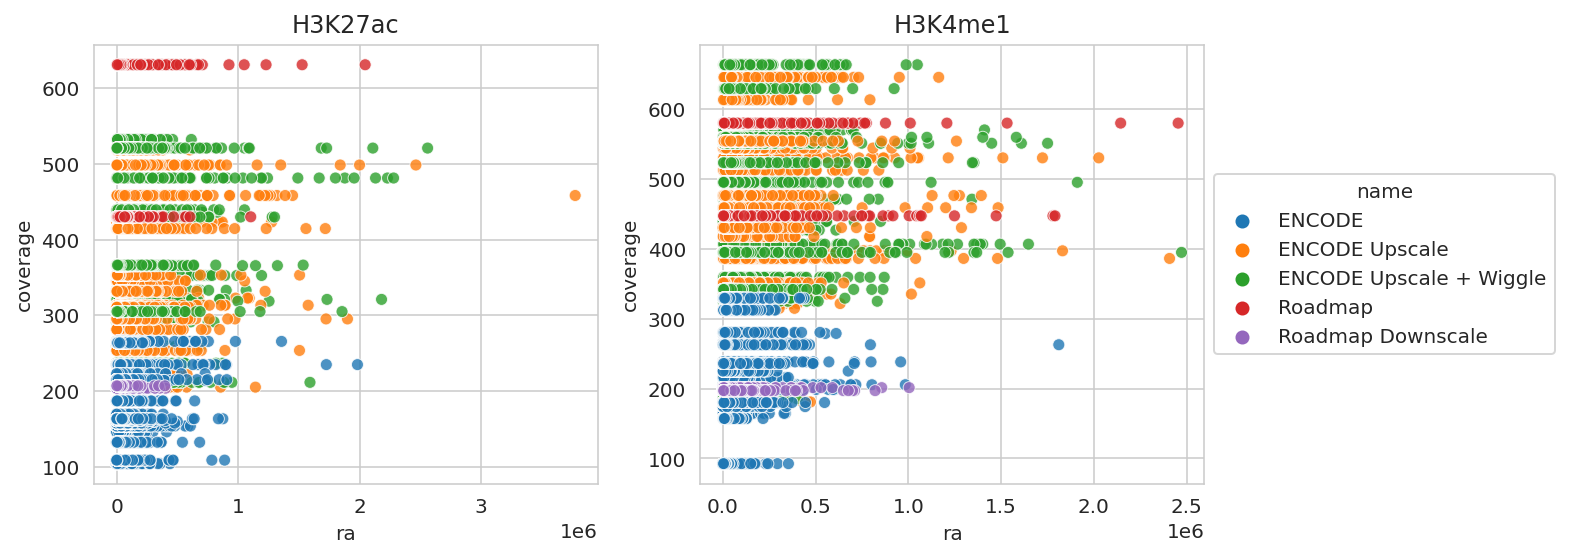

In [2655]:
plot_modifications_simple(df_roughness, 'ra', 'coverage', text=False)

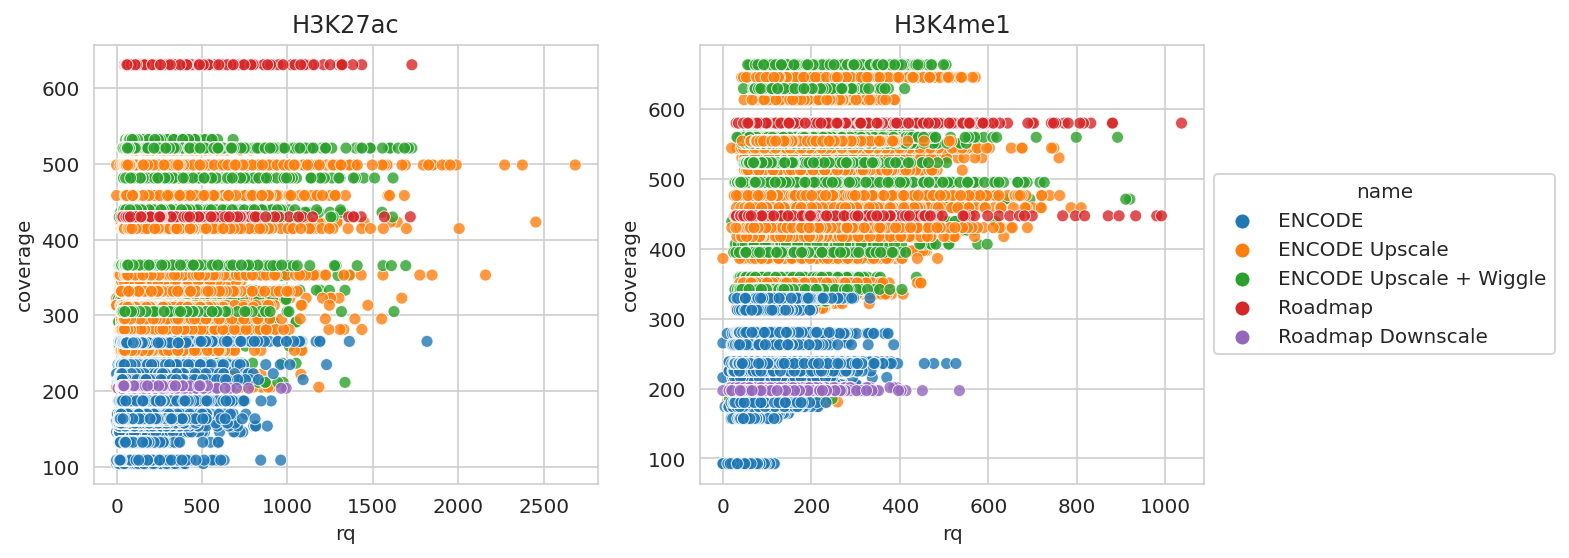

In [2656]:
plot_modifications_simple(df_roughness, 'rq', 'coverage', text=False)

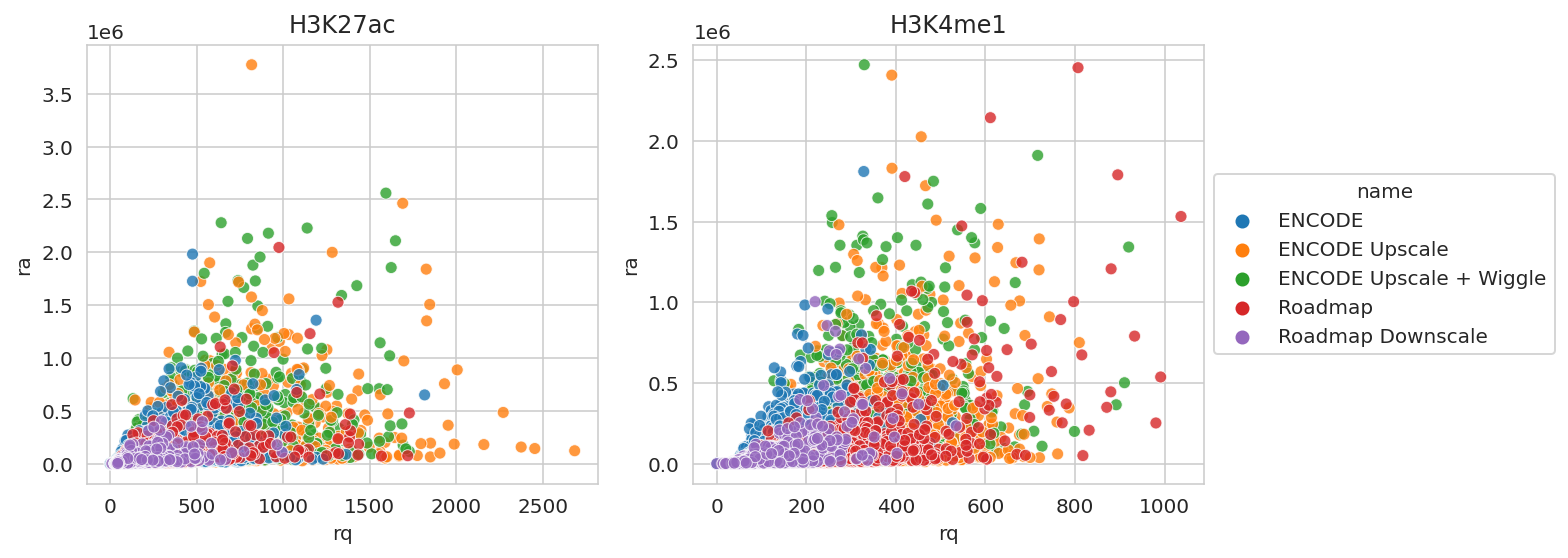

In [2657]:
plot_modifications_simple(df_roughness, 'rq', 'ra', text=False)

In [2658]:
df_roughness['ran'] = df_roughness['ra'] / df_roughness['coverage']
df_roughness['rqn'] = df_roughness['rq'] / df_roughness['coverage']

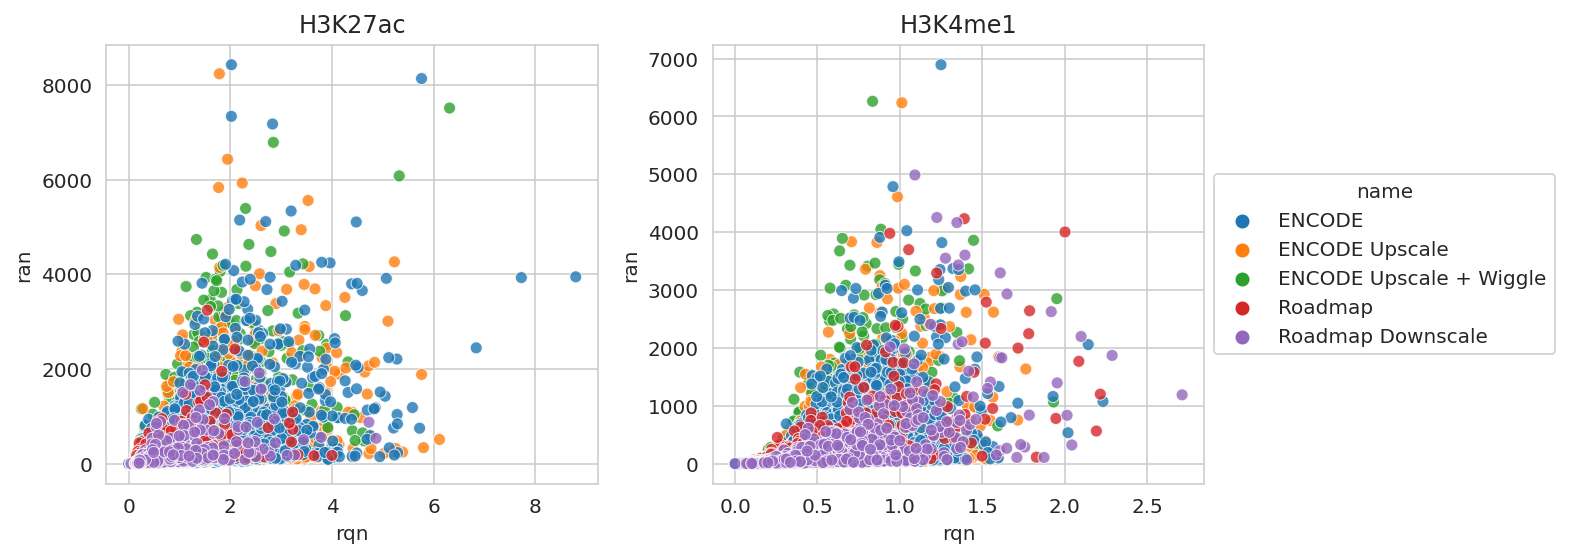

In [2659]:
plot_modifications_simple(df_roughness, 'rqn', 'ran', text=False)

H3K27ac ENCODE Upscale


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac ENCODE Upscale + Wiggle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac ENCODE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac Roadmap
H3K27ac Roadmap Downscale
H3K4me1 ENCODE Upscale


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 ENCODE Upscale + Wiggle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 ENCODE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 Roadmap
H3K4me1 Roadmap Downscale


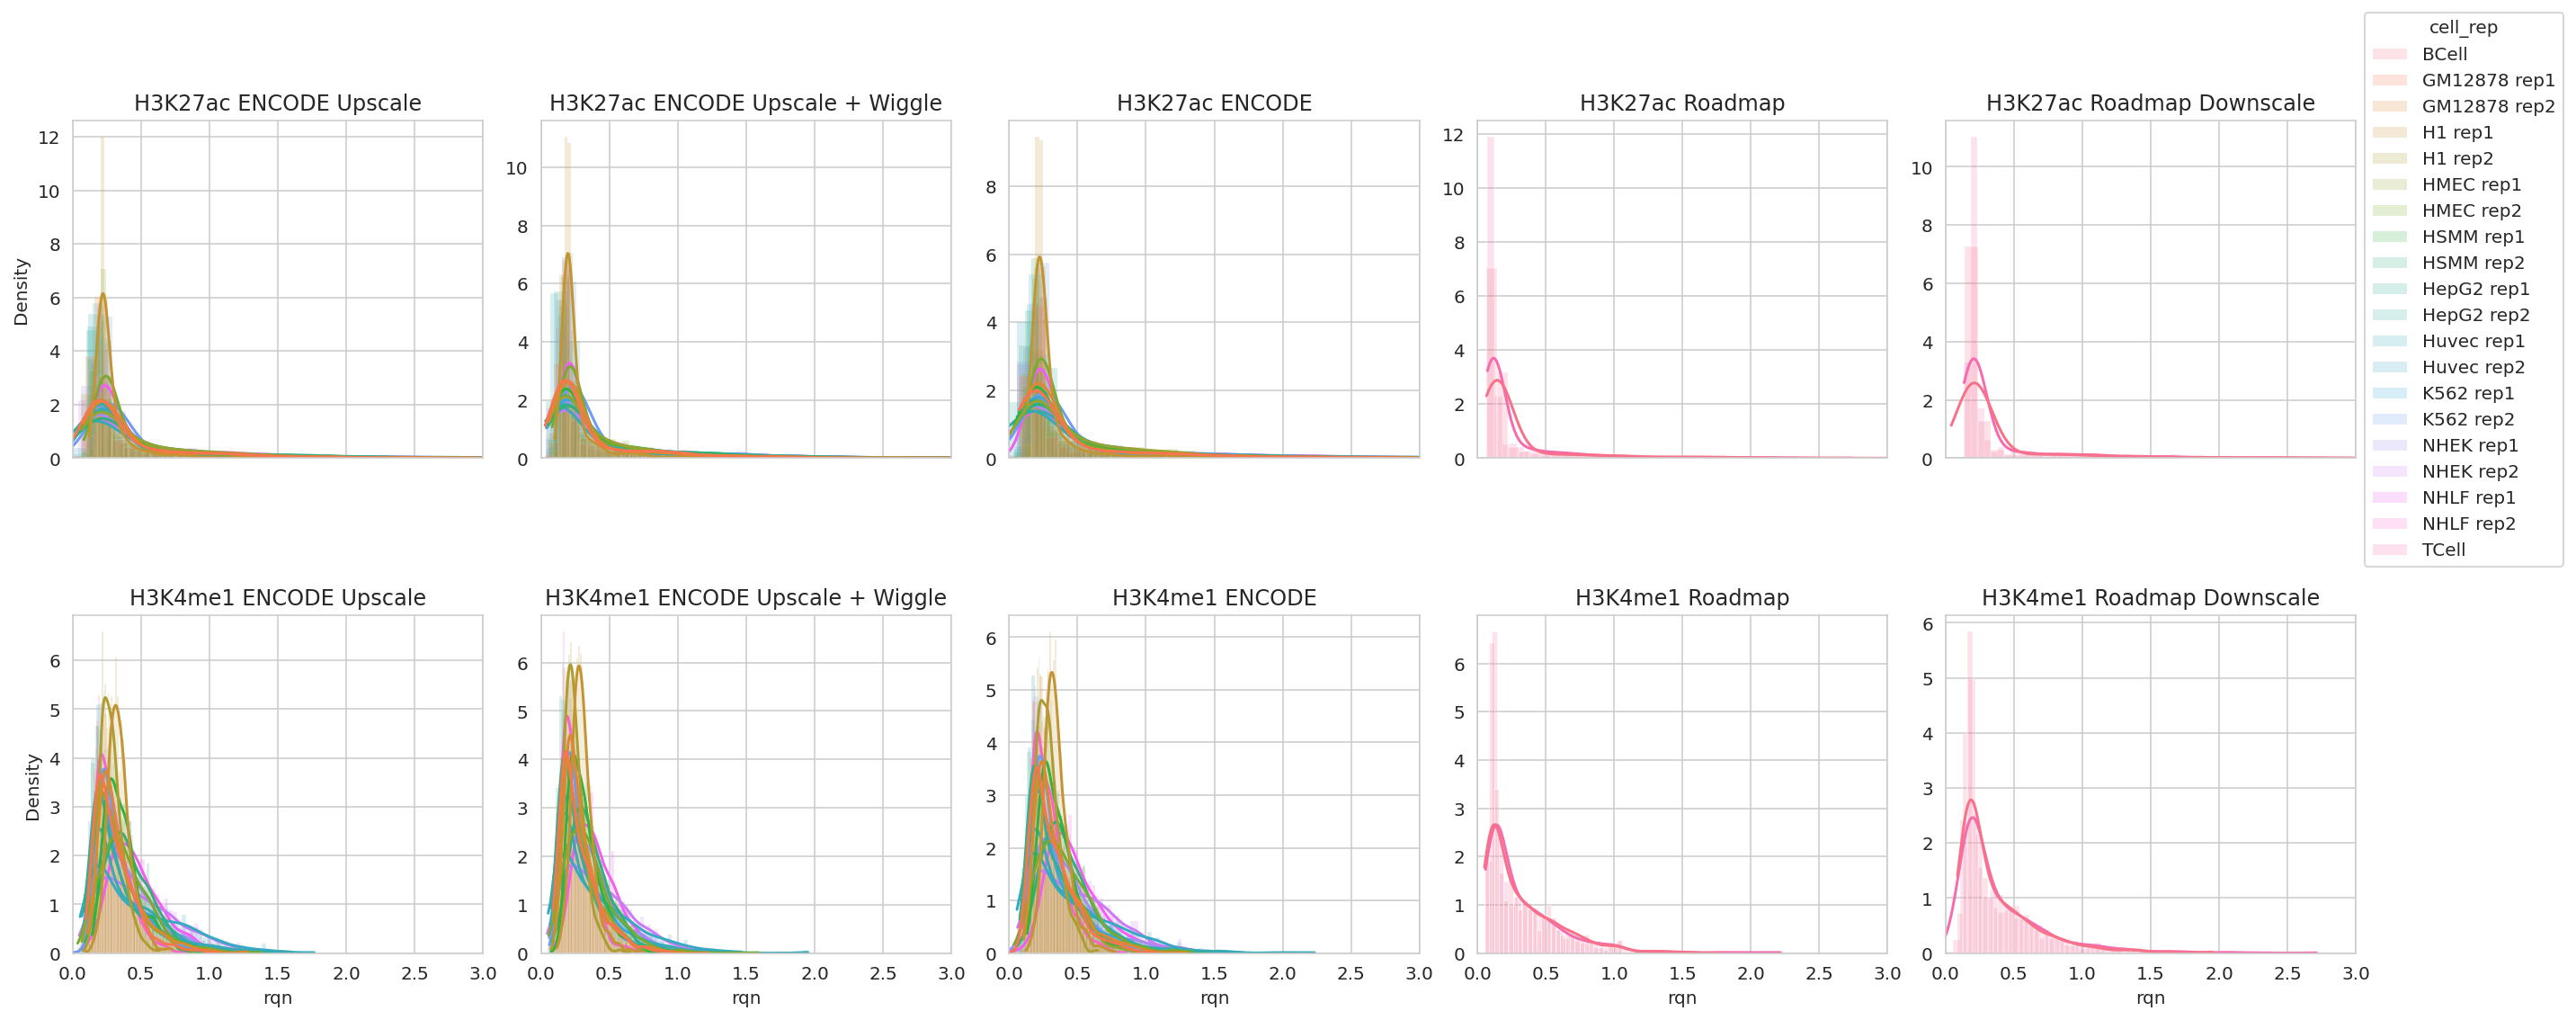

In [2660]:
df_roughness['cell_rep'] = df_roughness['cell'] + ' ' + df_roughness['replicate']

plt.figure(figsize=(20, 8))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, 5, i + 1) for i in range(2 * 5)]

for i, (m, name) in enumerate(product(['H3K27ac', 'H3K4me1'], df_roughness['name'].unique())):
    print(m, name)
    ax = axs[i]
    g_results = sns.histplot(data=df_roughness[(df_roughness['modification']==m) & (df_roughness['name']==name)],
                             x='rqn', hue='cell_rep',
                             hue_order=list(sorted(df_roughness['cell_rep'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=50, kde=True, alpha=0.2
                             )
    if (i + 1) == 5:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i % 5 != 0:
        ax.set_ylabel(None)
    if i < 5:
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {name}')
    ax.set_xlim(0, 3)
plt.tight_layout()
plt.show()

## Aggregate roughness by sample

In [2661]:
df_roughness_aggr = df_roughness[
    ['modification', 'cell', 'replicate', 'type', 'name', 'coverage', 'ra', 'rq', 'ran', 'rqn']
].groupby(['modification', 'cell', 'replicate', 'type', 'name']).agg('mean').reset_index()
df_roughness_aggr.sample(3)

modification   cell replicate                 type  \
43      H3K27ac   NHEK      rep1  x2_N10_w80_20_N2000   
34      H3K27ac  Huvec      rep2  x2_N10_w80_20_N2000   
12      H3K27ac   HMEC      rep1               x2_N10   

                       name   coverage            ra          rq         ran  \
43  ENCODE Upscale + Wiggle  429.64650  43967.339545  190.174324  102.333755   
34  ENCODE Upscale + Wiggle  352.60205  42929.989213  168.210130  121.751956   
12           ENCODE Upscale  423.03625  40793.510638  207.355496   96.430296   

         rqn  
43  0.442630  
34  0.477054  
12  0.490160

## Additional annotation

In [2662]:
t = df_wiggle_bams.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
# t['scale'] = t['upscale']

t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t2['type'] = t2['dataset']
t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
t2['wiggle'] = 0.0

t3 = df_immune_10m_bams.copy()
t3['type'] = 'Roadmap_10M'
t3['scale'] = 2.2
t3['wiggle'] = 0.0

all_bams_df = pd.concat([t, t2, t3]).reset_index(drop=True)
all_bams_df

bam_file modification   cell  \
0    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   K562   
1    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HSMM   
2    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   NHEK   
3    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HSMM   
4    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  Huvec   
..                                                 ...          ...    ...   
105  /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K27ac  TCell   
106  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
107  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  TCell   
108  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   
109  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   

    replicate     reads                 type  upscale  wiggle  dataset  scale  
0        rep2  12360187  x2_N10_w80_20_N2000      2.0  2000.0      NaN    NaN  
1        rep1  16160664               x2_N10      2.0     0.0      NaN    NaN  
2        rep1  18755229  x2_N10_w80_20_N2000      2.0  2000.0      NaN    NaN  
3        rep2  16416791  x2_N10_w80_20_N2000      2.0  2000.0      NaN    NaN  
4        rep1  20920470               x2_N10      2.0     0.0      NaN    NaN  
..        ...       ...                  ...      ...     ...      ...    ...  
105            30425955              Roadmap      NaN     0.0  Roadmap    2.5  
106             9998693          Roadmap_10M      NaN     0.0      NaN    2.2  
107             9998681          Roadmap_10M      NaN     0.0      NaN    2.2  
108            10002191          Roadmap_10M      NaN     0.0      NaN    2.2  
109             9999314          Roadmap_10M      NaN     0.0      NaN    2.2  

[110 rows x 10 columns]

In [2663]:
reads = []
peaks = {tool: [] for tool in TOOLS}
for _, (m, c, r, ty) in df_roughness_aggr[['modification', 'cell', 'replicate', 'type']].iterrows():
    t = all_bams_df[(all_bams_df['modification'] == m) & 
                    (all_bams_df['cell'] == c) & 
                    (all_bams_df['replicate'] == r) & 
                    (all_bams_df['type'] == ty)]
    if len(t) == 0:
        reads.append(None)
    else:
        reads.append(t['reads'].values[0])
    for tool in TOOLS:
        t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                          (wiggle_mix_original_all_peaks['cell'] == c) &
                                          (wiggle_mix_original_all_peaks['replicate'] == r) &
                                          (wiggle_mix_original_all_peaks['type'] == ty) &
                                          (wiggle_mix_original_all_peaks['tool'] == tool)]
        if len(t) == 0:
            peaks[tool].append(None)
        else:
            peaks[tool].append(t['peaks'].values[0])
        

df_roughness_aggr['reads'] = reads
for tool in TOOLS:
    df_roughness_aggr[tool] = peaks[tool]

df_roughness_aggr.sample(5)

modification     cell replicate                 type  \
59       H3K4me1  GM12878      rep1  x2_N10_w80_20_N2000   
104      H3K4me1     NHLF      rep1  x2_N10_w80_20_N2000   
85       H3K4me1    Huvec      rep1               x2_N10   
48       H3K27ac     NHLF      rep1               x2_N10   
81       H3K4me1    HepG2      rep1               ENCODE   

                        name   coverage            ra          rq         ran  \
59   ENCODE Upscale + Wiggle  523.23190  51017.403017  147.198921   97.504382   
104  ENCODE Upscale + Wiggle  185.25025  16186.075269   76.531806   87.374108   
85            ENCODE Upscale  458.77335  43586.892178  179.041045   95.007463   
48            ENCODE Upscale  310.83390  31029.189189  128.204748   99.825628   
81                    ENCODE  262.71360  27553.513238   81.901255  104.880422   

          rqn     reads   MACS2  MACS2 broad   SPAN  SICER  
59   0.281326  22016315   33863        45502  82749  71261  
104  0.413127   9108455   15518        29647  69024  63625  
85   0.390260  20920470  100318       105806  78969  60093  
48   0.412454  15831026   29848        32241  41398  49064  
81   0.311751  13707399   87117        67313  88821  69630

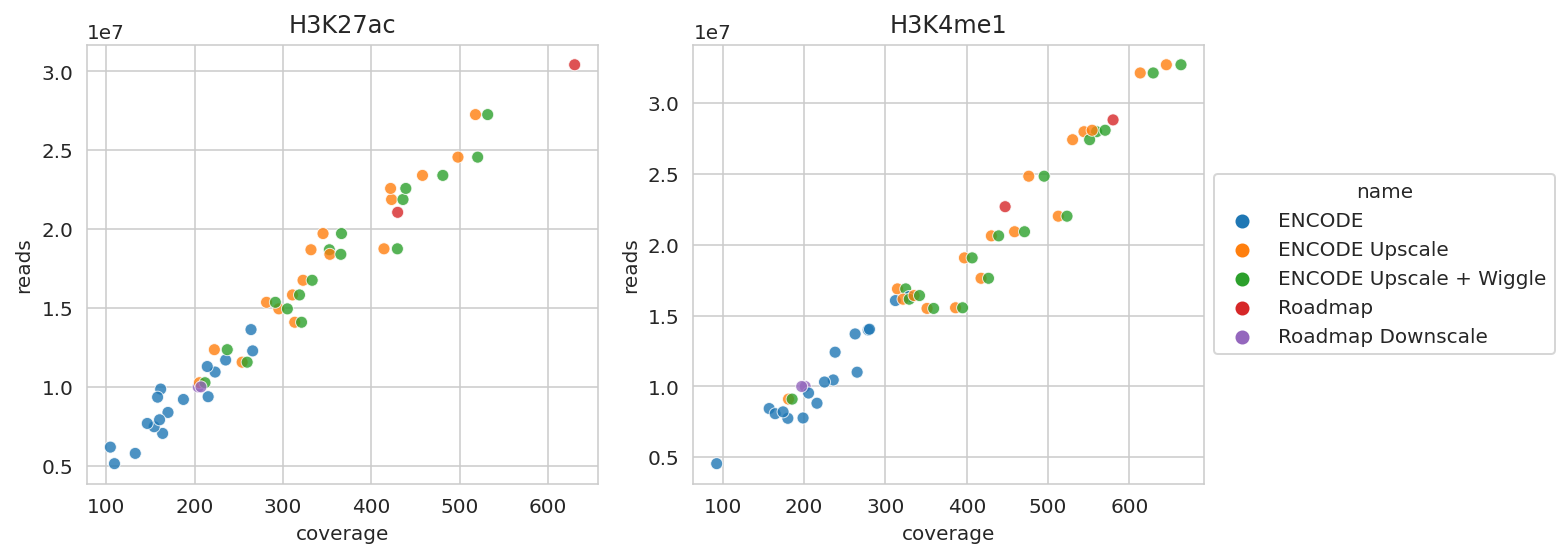

In [2664]:
plot_modifications_simple(df_roughness_aggr, 'coverage', 'reads')

## Modifications visualization

In [2665]:
def plot_wiggle_dataset(df, X, Y, big, texts, textcenter=True, colorcol=None):
    sns.set_style("white")
    plt.figure(figsize=(20, 8))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        t['size'] = [2 if ty in big else 1 for ty in t['name']]

        # scales = ['', 'x2_N20']
        # wiggles = ['', 'w80_20_N5000']
        scales = ['', 'x2_N10']
        wiggles = ['', 'w80_20_N2000']
        for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows():
            for (sc, wg) in product(scales, wiggles):
                if sc == '' and wg == '':
                    continue
                if sc == '':
                    s = 'ENCODE'
                    e = wg
                    color = 'darkblue'
                elif wg == '':
                    s = 'ENCODE'
                    e = sc
                    color = 'green'
                else:
                    s = sc
                    e = f'{sc}_{wg}'
                    color = 'blue'
                p1 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == s)]
                p2 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == e)]
                if len(p1) == 0 or len(p2) == 0:
                    continue
                p1x = p1[X].values[0]
                p1y = p1[Y].values[0]
                p2x = p2[X].values[0]
                p2y = p2[Y].values[0]
                sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color=color, ax=ax, alpha=0.8, linestyle='dotted')
            p1 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == 'Roadmap')]
            p2 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == 'Roadmap_10M')]
            if len(p1) == 0 or len(p2) == 0:
                continue
            p1x = p1[X].values[0]
            p1y = p1[Y].values[0]
            p2x = p2[X].values[0]
            p2y = p2[Y].values[0]
            sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        
        if colorcol is None:
            sns.scatterplot(data=t,
                            x=X, y=Y, hue='name', ax=ax, size='size',
                            hue_order=sorted(df['name'].unique()))
        else:
            sns.scatterplot(data=t,
                            x=X, y=Y, hue=colorcol, palette='Blues', ax=ax, size='size')

        for x, y, cell, replicate, ty in zip(t[X], t[Y], t['cell'], t['replicate'], t['name']):
            if ty in texts and (textcenter or (math.fabs(x) > 1e-3 or math.fabs(y) > 1e-3)):
                ax.text(x, y, f'{cell} {replicate}', fontsize = 7)

        ax.title.set_text(m)
        if i == 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()
    sns.set_style("whitegrid")

Modification scheme


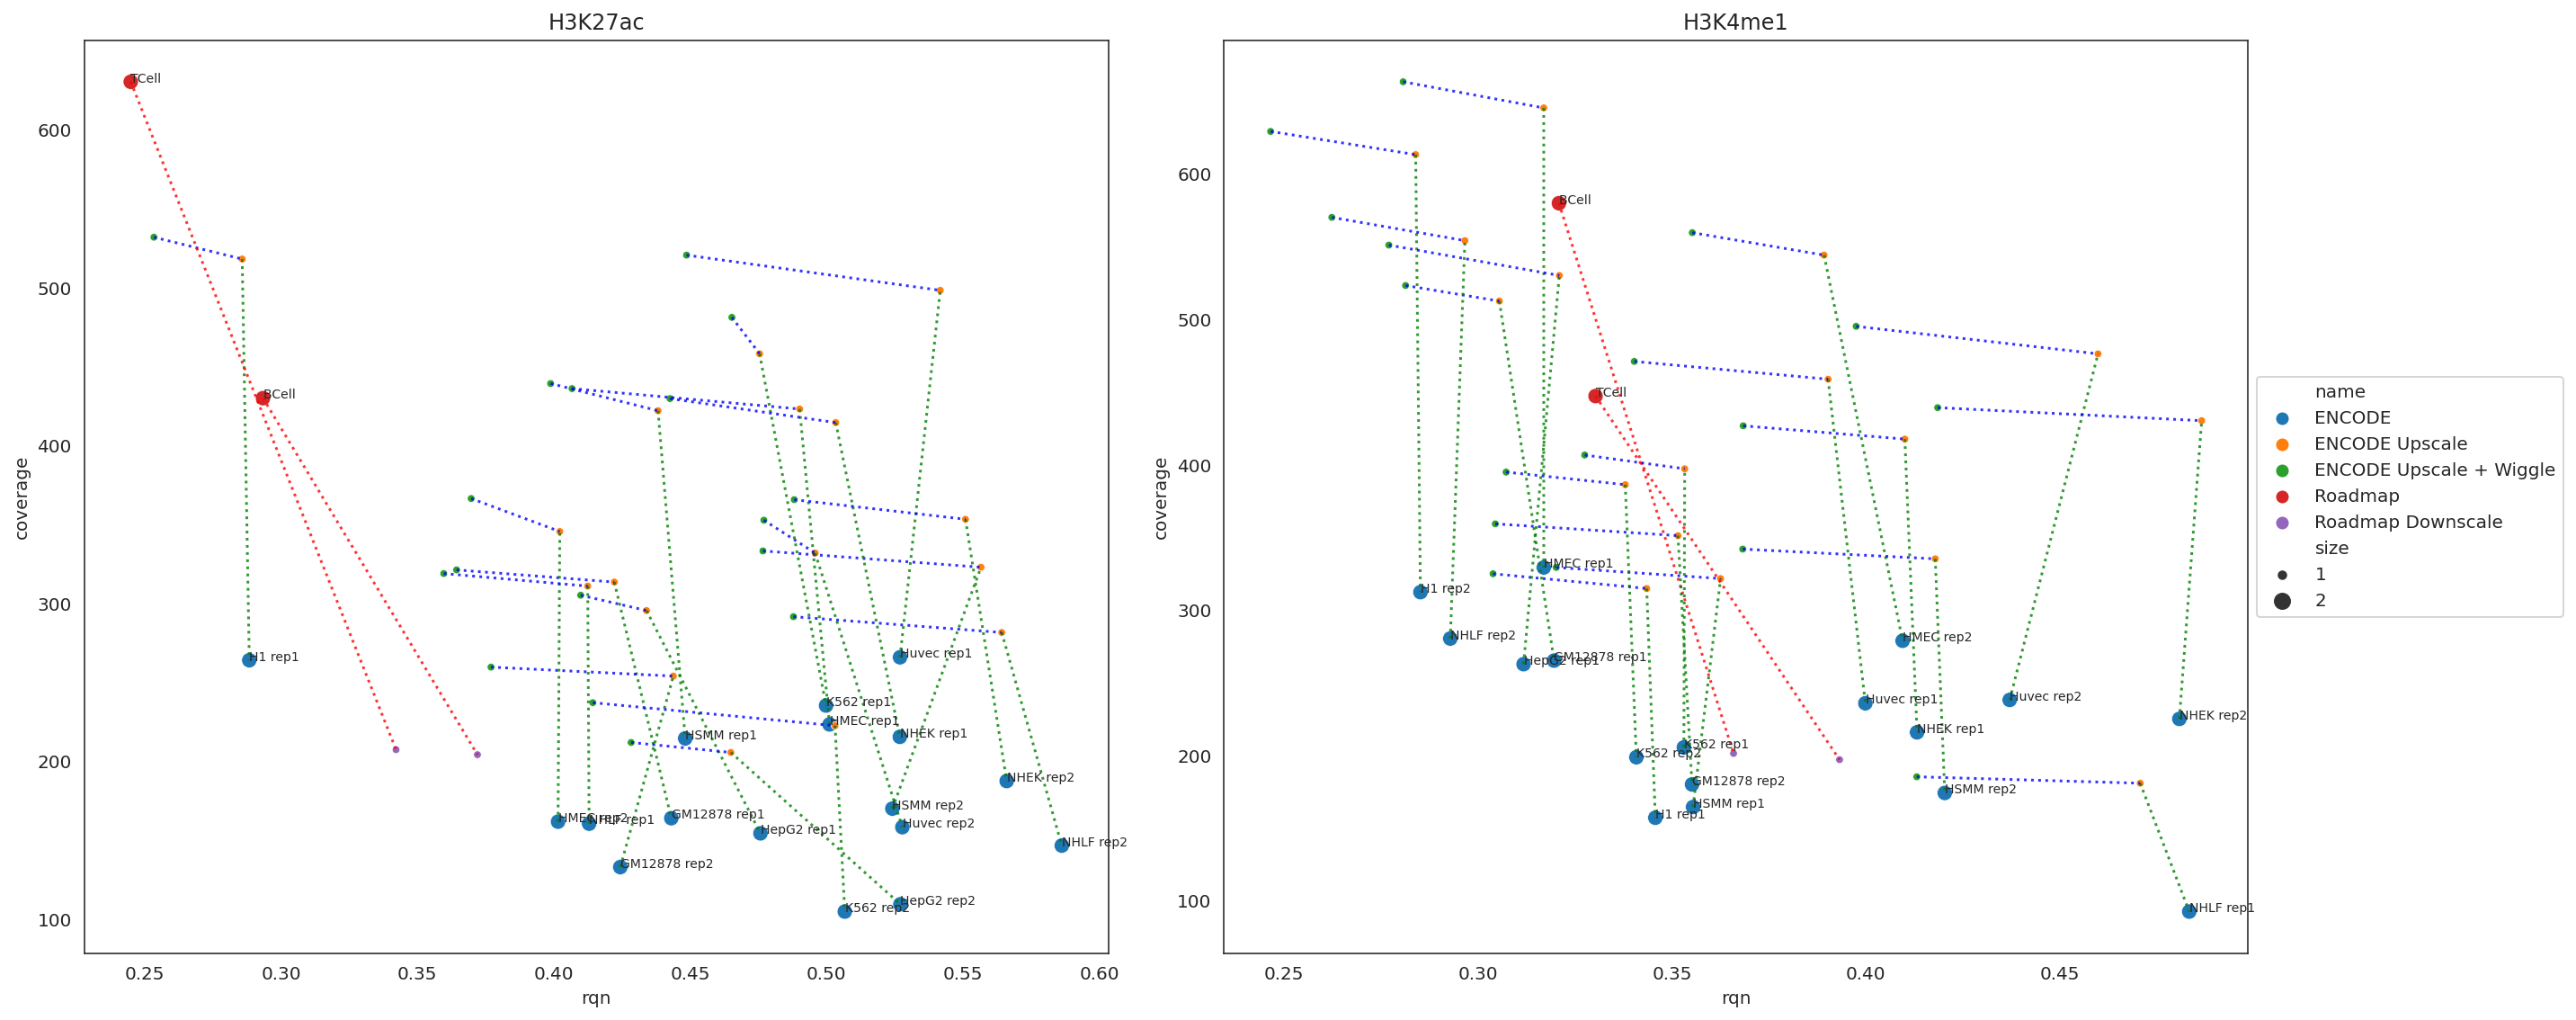

In [2666]:
print('Modification scheme')

X = 'rqn'
Y = 'coverage'
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']

plot_wiggle_dataset(df_roughness_aggr, X, Y, big, texts, True)


Modification scheme


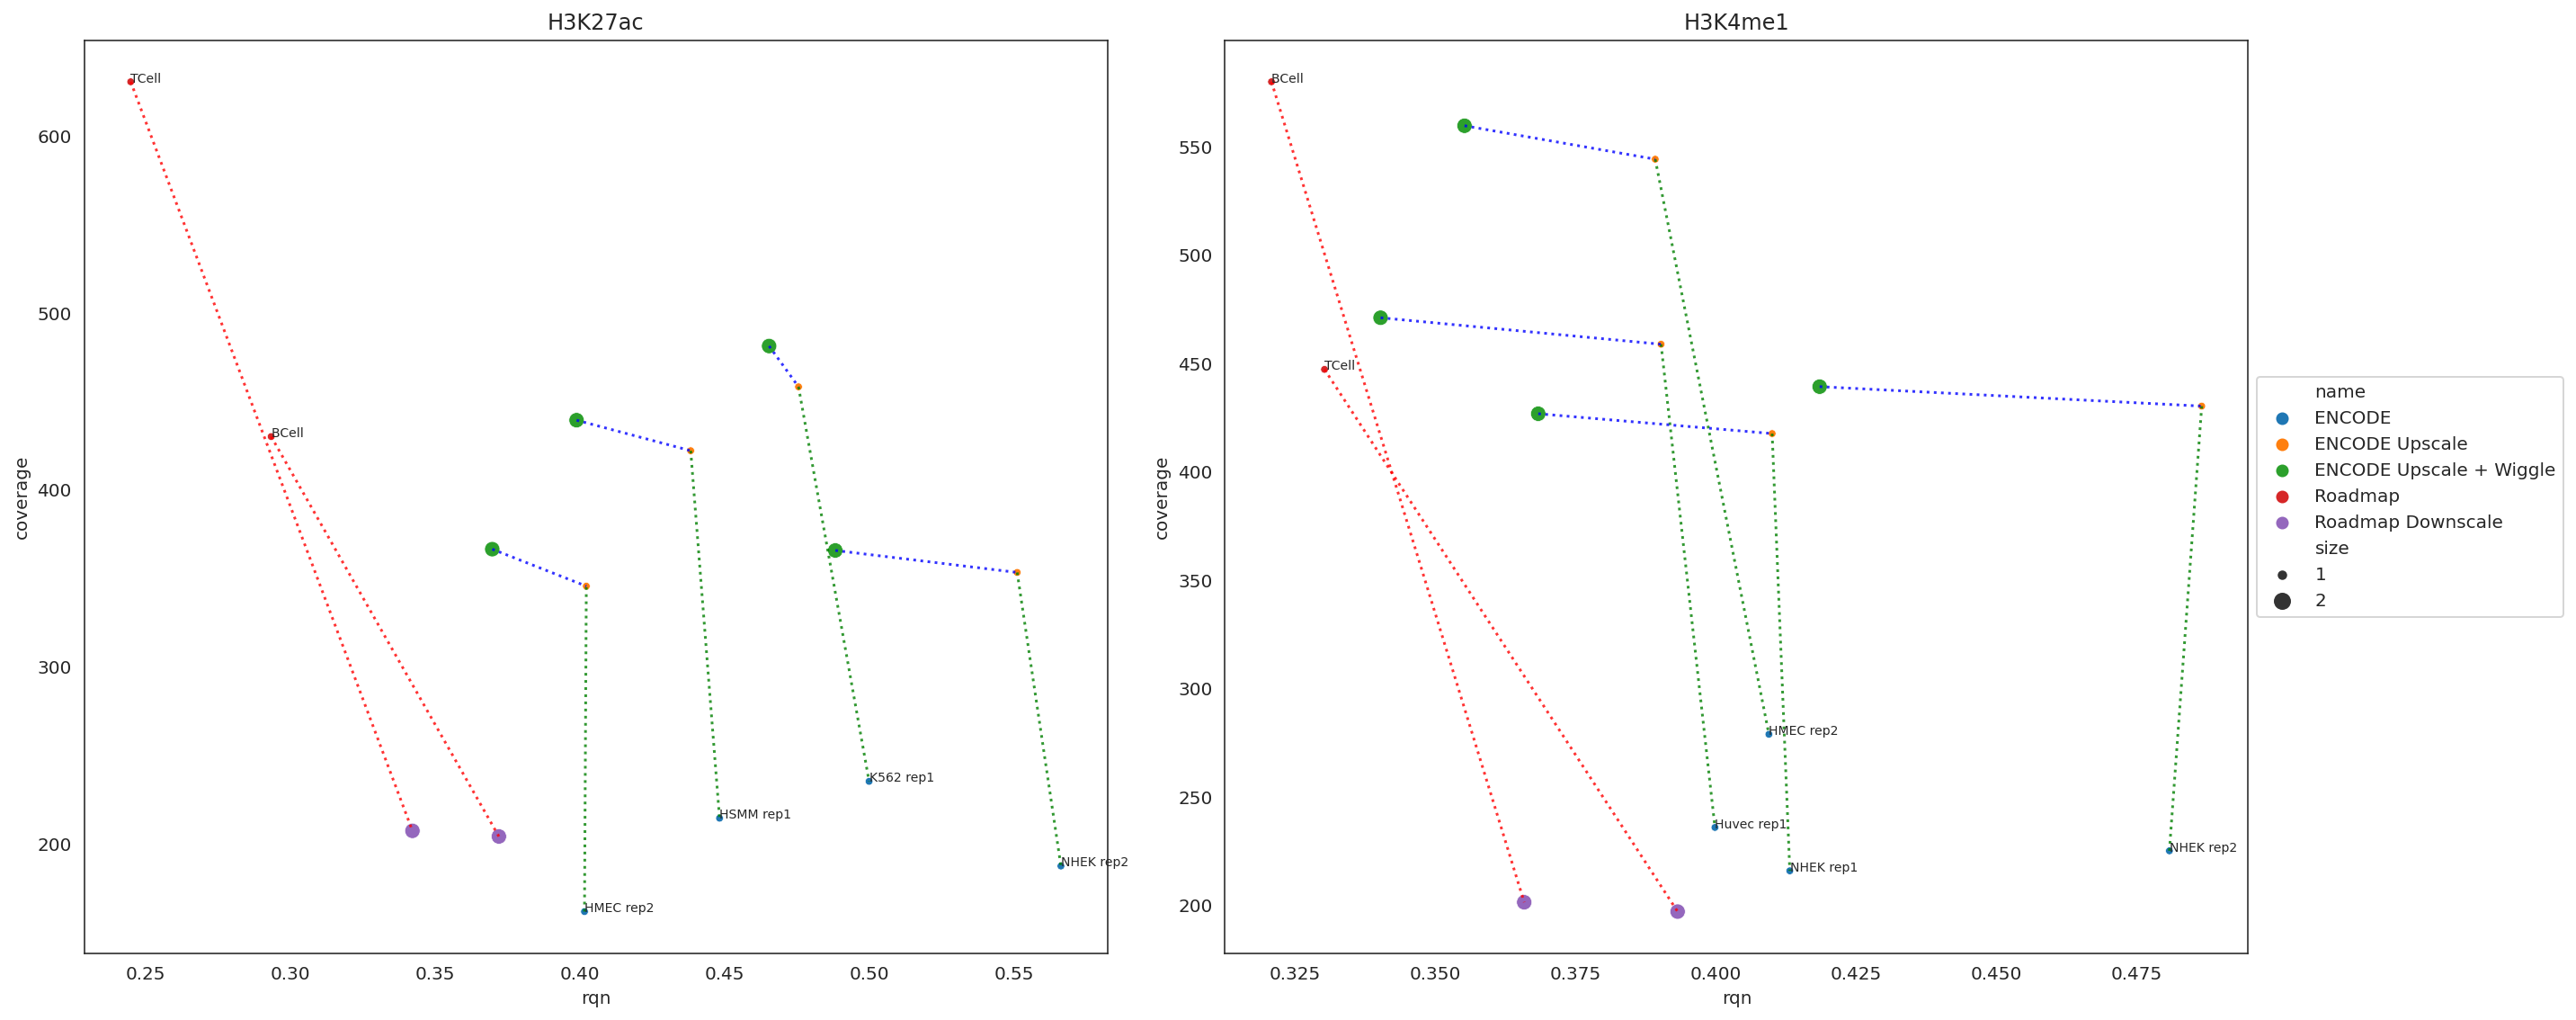

In [2667]:
print('Modification scheme')
H3K27AC_SAMPLES = [('K562', 'rep1'), ('HSMM', 'rep1'), ('HMEC', 'rep2'), ('NHEK', 'rep2')]
# H3K4ME1_SAMPLES = [('NHEK', 'rep1'), ('Huvec', 'rep1'), ('Huvec', 'rep2'), ('NHEK', 'rep2'), ('HMEC', 'rep2'), ('HSMM', 'rep2')]
H3K4ME1_SAMPLES = [('HMEC', 'rep2'), ('NHEK', 'rep1'), ('NHEK', 'rep2'), ('Huvec', 'rep1')]

X = 'rqn'
Y = 'coverage'
t = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
    (((df_roughness_aggr['modification'] == 'H3K27ac') & 
      ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
     ((df_roughness_aggr['modification'] == 'H3K4me1') & 
      ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()
big = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
texts = ['Roadmap', 'ENCODE']

plot_wiggle_dataset(t, X, Y, big, texts, True)


In [2668]:
# for Y in TOOLS:
#     print(Y)
#     X = 'rqn'
#     big = ['w80_20_N2000', 'x2_N10_w80_20_N2000', 'Roadmap_10M']
#     texts = ['Roadmap', 'ENCODE']
#     plot_wiggle_dataset(df_roughness_aggr, X, Y, big, texts, True)

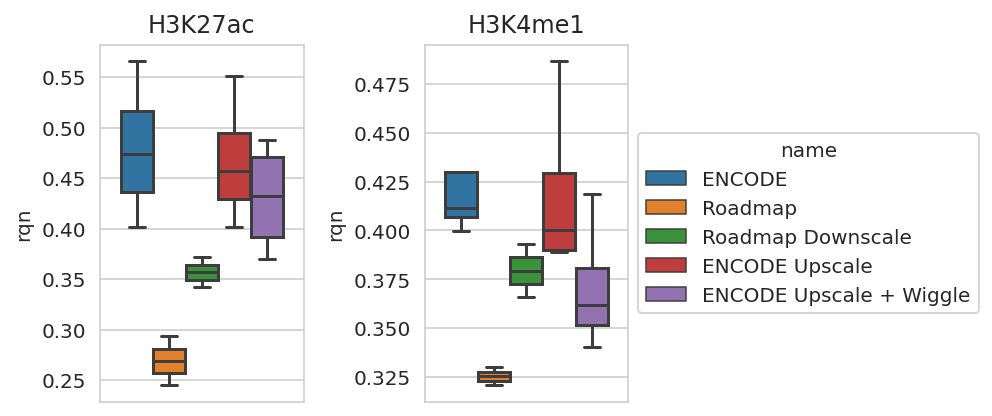

In [2669]:
df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
                      (((df_roughness_aggr['modification'] == 'H3K27ac') &
                        ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                       ((df_roughness_aggr['modification'] == 'H3K4me1') &
                        ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()


plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[df['modification'] == m].copy()
    g_results = sns.boxplot(data=t,
                            x='modification', y='rqn', hue='name',
                            hue_order=['ENCODE', 'Roadmap', 'Roadmap Downscale', 'ENCODE Upscale', 'ENCODE Upscale + Wiggle'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

## Center by initial point

In [2670]:
rows = []
for _, row in tqdm(df_roughness_aggr.iterrows()):
    m, c, r, ty = row['modification'], row['cell'], row['replicate'], row['type']
    if ty == 'ENCODE' or ty == 'Roadmap':
        rows.append([m, c, r, ty, 0, 0, 0, 0, 0, 0, row['rqn']])
        continue
    offset = 'Roadmap' if ty == 'Roadmap_10M' else 'ENCODE'
    t = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                          (df_roughness_aggr['cell'] == c) &
                          (df_roughness_aggr['replicate'] == r) &
                          (df_roughness_aggr['type'] == offset)]
    if len(t) == 0:
        continue
    rows.append([m, c, r, ty] + [row[col] - t[col].values[0] for col in ['rqn', 'reads'] + TOOLS] + [t['rqn'].values[0]])
df_roughness_aggr_z = pd.DataFrame(rows, 
                                   columns=['modification', 'cell', 'replicate', 'type', 'rqn', 'reads'] + TOOLS + ['rqn_original'])
df_roughness_aggr_z.sample(5)

0it [00:00, ?it/s]

modification  cell replicate                 type       rqn     reads  \
45      H3K27ac  NHEK      rep2               x2_N10 -0.015105   9202766   
37      H3K27ac  K562      rep1  x2_N10_w80_20_N2000 -0.034525  11704711   
36      H3K27ac  K562      rep1               x2_N10 -0.024363  11704712   
38      H3K27ac  K562      rep2               ENCODE  0.000000         0   
15      H3K27ac  HMEC      rep2               x2_N10  0.000628   9860687   

    MACS2  MACS2 broad   SPAN  SICER  rqn_original  
45     66        24173   1066   7462      0.566084  
37  -6187        13282   3418  13473      0.499844  
36   -465        20408  14988  28530      0.499844  
38      0            0      0      0      0.506719  
15   5128        17242   7587  12689      0.401580

In [2671]:
df_roughness_aggr_z['name'] = df_roughness_aggr_z['type']
df_roughness_aggr_z.loc[df_roughness_aggr_z['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
df_roughness_aggr_z.loc[df_roughness_aggr_z['type'] == 'x2_N10', 'name'] = 'ENCODE Upscale'
df_roughness_aggr_z.loc[df_roughness_aggr_z['type'] == 'x2_N10_w80_20_N2000', 'name'] = 'ENCODE Upscale + Wiggle'

In [2672]:
# df = df_roughness_aggr_z
# big =  ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
# texts = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
# for Y in TOOLS:
#     print(Y)
#     plot_wiggle_dataset(df, 'rqn', Y, big, texts, False, 'rqn_original')

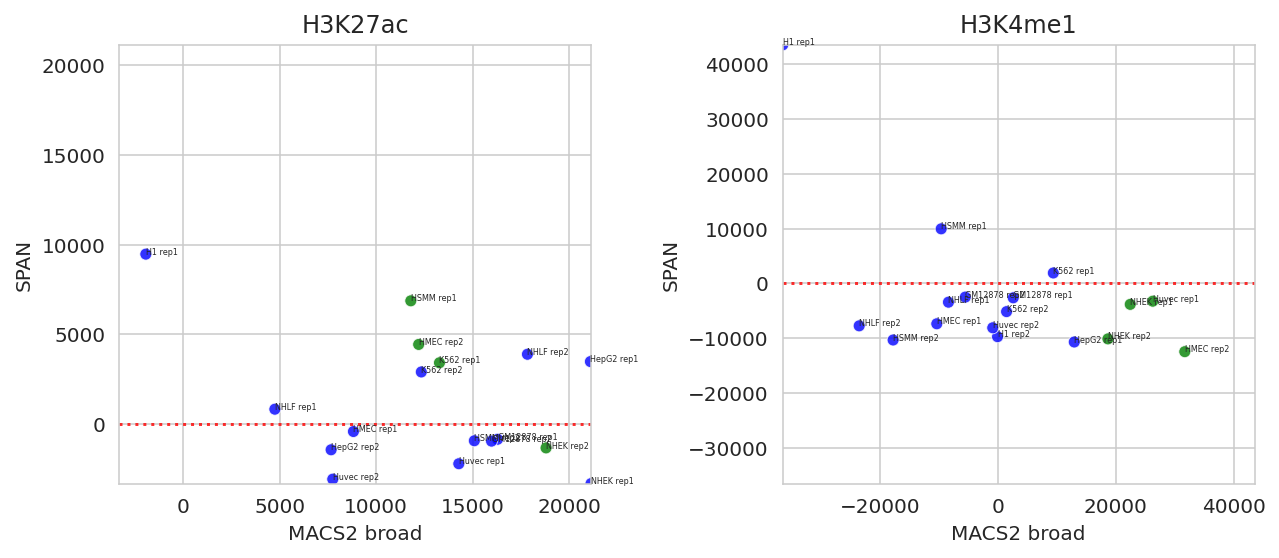

In [2673]:
df = df_roughness_aggr_z[df_roughness_aggr_z['type'] == 'x2_N10_w80_20_N2000']
X = 'MACS2 broad'
Y = 'SPAN'
plt.figure(figsize=(9, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[df['modification'] == m].copy()
    colors = ['green' if (row['modification'] == 'H3K27ac') & ((row['cell'], row['replicate']) in H3K27AC_SAMPLES) |
                         (row['modification'] == 'H3K4me1') & ((row['cell'], row['replicate']) in H3K4ME1_SAMPLES)
              else 'blue' for _, row in t.iterrows()]
    sns.scatterplot(data=t,
                    x=X, y=Y,
                    color=colors,
                    alpha=0.8,
                    ax=ax,
                    )

    for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
        ax.text(x, y, f'{cell} {rep}', fontsize = 4)
    ax.title.set_text(m)
    amin = min(t[X].min(), t[Y].min())
    amax = max(t[X].max(), t[Y].max())
    sns.lineplot(x=[amin, amax], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
    ax.set_xlim(amin, amax)
    ax.set_ylim(amin, amax)

plt.tight_layout()
plt.show()

In [2674]:
H3K4ME1_SAMPLES = [('HMEC', 'rep2'), ('NHEK', 'rep1'), ('NHEK', 'rep2'), ('Huvec', 'rep1'), ('Huvec', 'rep2')]

H3K27ac MACS2
H3K27ac MACS2 broad
H3K27ac SPAN
H3K27ac SICER
H3K4me1 MACS2
H3K4me1 MACS2 broad
H3K4me1 SPAN
H3K4me1 SICER


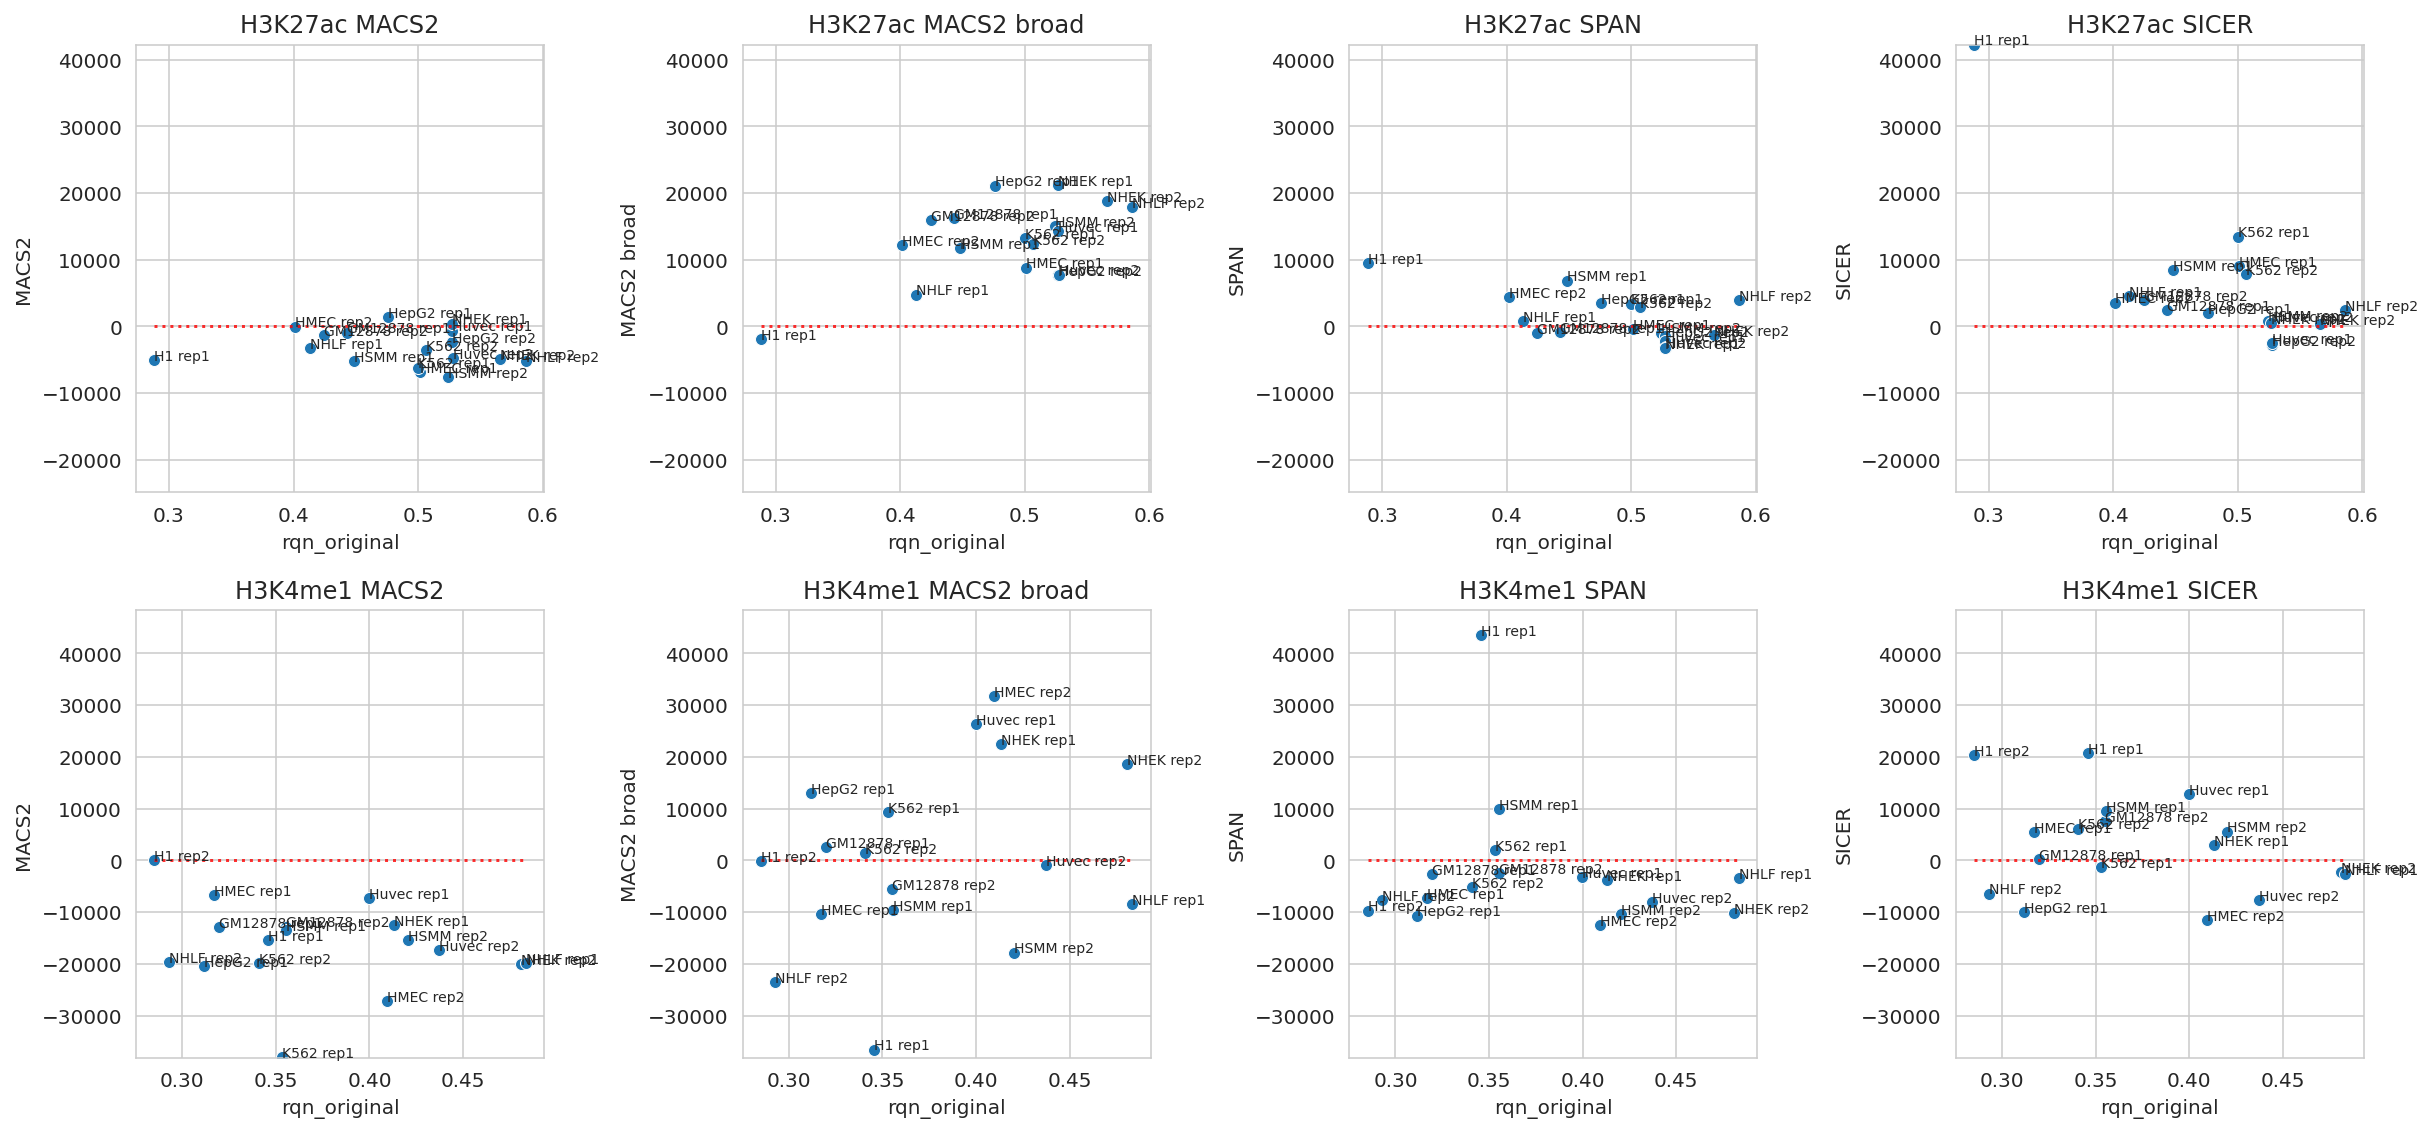

In [2675]:
df = df_roughness_aggr_z
plt.figure(figsize=(17, 8))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    t = df[(df['modification'] == m) & (df['type'] == 'x2_N10_w80_20_N2000')].copy()
    t2 = df[(df['modification'] == m)].copy()
    sns.scatterplot(data=t,
                    x='rqn_original', y=tool,
                    ax=ax)
    for x, y, cell, rep in zip(t['rqn_original'], t[tool], t['cell'], t['replicate']):
        ax.text(x, y, f'{cell} {rep}', fontsize = 7)

    sns.lineplot(x=[t['rqn_original'].min(), t['rqn_original'].max()], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')

    ax.title.set_text(f'{m} {tool}')
    # if i == 1:
    #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # else:
    #     ax.legend().set_visible(False)
    ax.set_ylim(min(0, np.min(t2[TOOLS].min())), max(0, np.max(t2[TOOLS].max())))

plt.tight_layout()
plt.show()

x2_N10
H3K27ac
H3K4me1


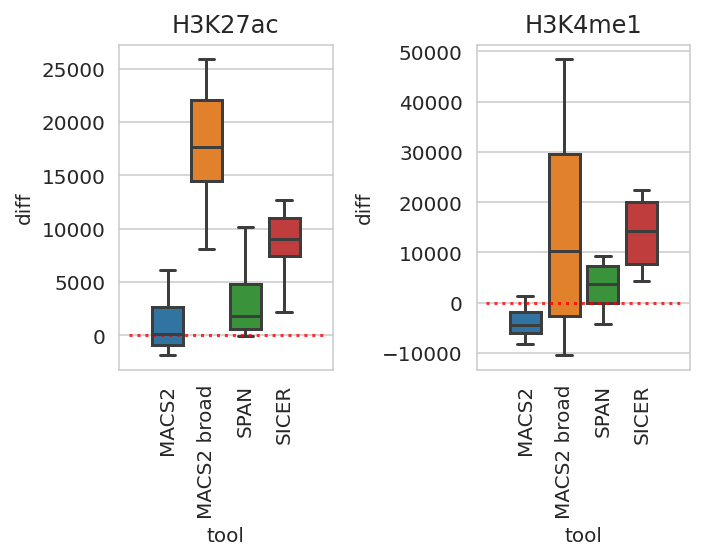

x2_N10_w80_20_N2000
H3K27ac
H3K4me1


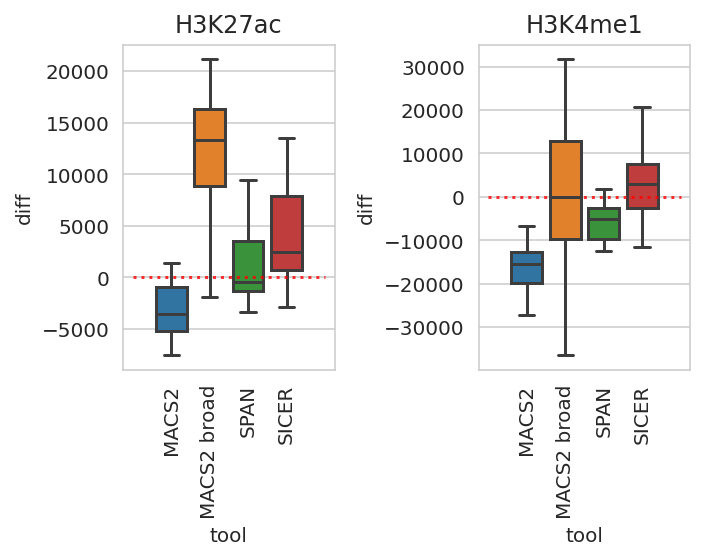

In [2676]:
df = df_roughness_aggr_z
# df = df_roughness_aggr_z[(df_roughness_aggr_z['name'].str.contains('Roadmap')) |
#                       (((df_roughness_aggr_z['modification'] == 'H3K27ac') &
#                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])) |
#                        ((df_roughness_aggr_z['modification'] == 'H3K4me1') &
#                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])))].copy()

for res in ['x2_N10', 'x2_N10_w80_20_N2000']:
    print(res)
    plt.figure(figsize=(5, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) & (df['type'] == res)].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate'], value_vars=TOOLS)
        t2 = df[(df['modification'] == m)].copy()
        g_results = sns.boxplot(data=t,
                                x='variable', y='value',
                                order=TOOLS,
                                showfliers=False,
                                ax=ax)
        sns.lineplot(x=[-1, 4], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        ax.set_xlabel('tool')
        ax.set_ylabel('diff')

    plt.tight_layout()
    plt.show()

H3K27ac
H3K4me1


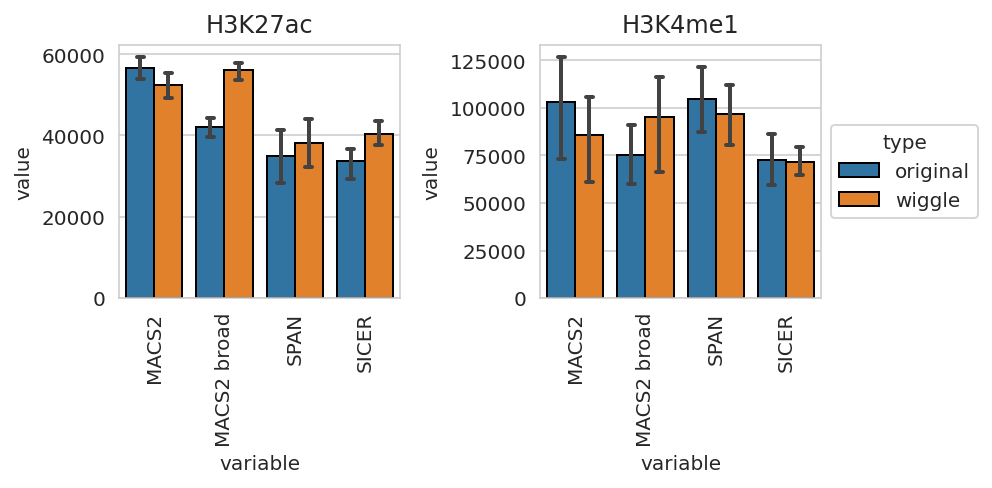

In [2677]:
# df = df_roughness_aggr
df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()

plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    t = df[(df['modification'] == m) &
           (df['type'].isin(['ENCODE', 'x2_N10_w80_20_N2000']))].copy()
    t = pd.melt(t, id_vars=['modification', 'cell', 'replicate', 'type'], value_vars=TOOLS).copy()
    t.loc[t['type'] == 'ENCODE', 'type'] = 'original'
    t.loc[t['type'] == 'x2_N10_w80_20_N2000', 'type'] = 'wiggle'
    
    g_results = sns.barplot(data=t,
                            x='variable', y='value', hue='type',
                            ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['original', 'wiggle'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


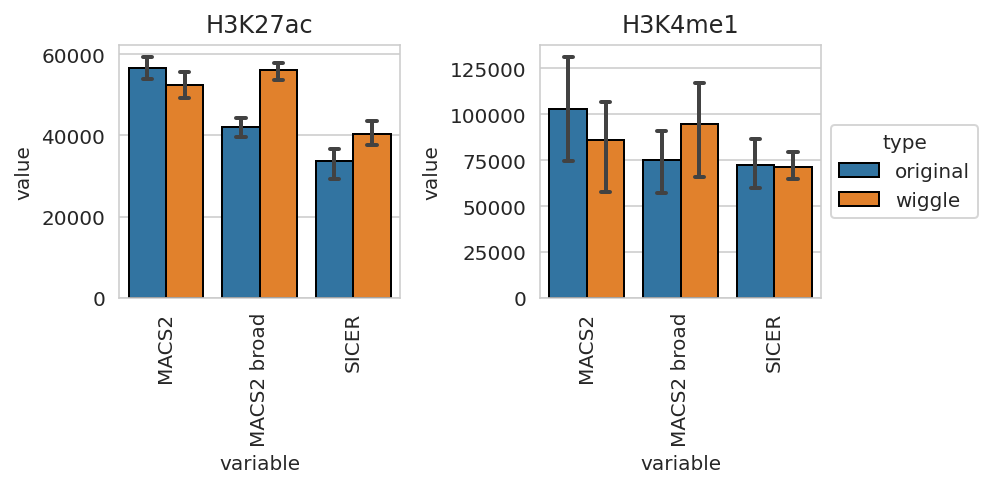

In [2678]:
# df = df_roughness_aggr
df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()


plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    t = df[(df['modification'] == m) &
           (df['type'].isin(['ENCODE', 'x2_N10_w80_20_N2000']))].copy()
    t = pd.melt(t, id_vars=['modification', 'cell', 'replicate', 'type'], value_vars=TOOLS).copy()
    t.loc[t['type'] == 'ENCODE', 'type'] = 'original'
    t.loc[t['type'] == 'x2_N10_w80_20_N2000', 'type'] = 'wiggle'

    g_results = sns.barplot(data=t,
                            x='variable', y='value', hue='type',
                            ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['original', 'wiggle'],
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# OLD CODE

In [ ]:
df_peaks['name'] = df_peaks['tool']
df_peaks['type'] = 'original'

In [45]:
wiggle_mix_peaks['name'] = wiggle_mix_peaks['tool']
wiggle_mix_peaks['type'] = 'base'

mix_rows = ['mix' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks.loc[mix_rows, 'name'] = wiggle_mix_peaks[mix_rows]['name'] + ' mix'
wiggle_mix_peaks.loc[mix_rows, 'type'] = 'mix'
wiggle_mix_peaks.loc[wiggle_rows, 'name'] = wiggle_mix_peaks[wiggle_rows]['name'] + ' wiggle'
wiggle_mix_peaks.loc[wiggle_rows, 'type'] = 'wiggle'

wiggle_mix_peaks.sample(3)

  0%|          | 0/253 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/253 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/36 [00:00<?, ?it/s]

SICER 32


  0%|          | 0/37 [00:00<?, ?it/s]

SPAN 32


file modification   cell  \
0    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HMEC   
83   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HSMM   
114  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  Huvec   

    replicate  peaks   tool          name    type  
0        rep1   3416  MACS2     MACS2 mix     mix  
83       rep1  64875  SICER  SICER wiggle  wiggle  
114      rep1  81721   SPAN   SPAN wiggle  wiggle

In [51]:
all_wiggle_mix_peaks = pd.concat([df_peaks[(df_peaks['dataset'] != 'Roadmap') &
                                           (df_peaks['replicate'] != 'rep2') &
                                           df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], 
                                  wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_peaks.sample(3)

file modification  cell  \
49   /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K4me1    H1   
151  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  NHLF   
177  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  HSMM   

    replicate  peaks   tool dataset          name      type  
49       rep1  51468  SICER  ENCODE         SICER  original  
151      rep1  41100  SICER     NaN  SICER wiggle    wiggle  
177      rep1  96790   SPAN     NaN   SPAN wiggle    wiggle

In [52]:
# # Remove outliers
# display(all_wiggle_mix_peaks[(all_wiggle_mix_peaks['type'] == 'wiggle') &
#                              ((all_wiggle_mix_peaks['peaks'] < 20_000) | (all_wiggle_mix_peaks['peaks'] > 100_000))])
# all_wiggle_mix_peaks = all_wiggle_mix_peaks[
#                                             (all_wiggle_mix_peaks['peaks'] >= 20_000) & 
#                                             (all_wiggle_mix_peaks['peaks'] <= 100_000)].copy()

H3K27ac
H3K4me1


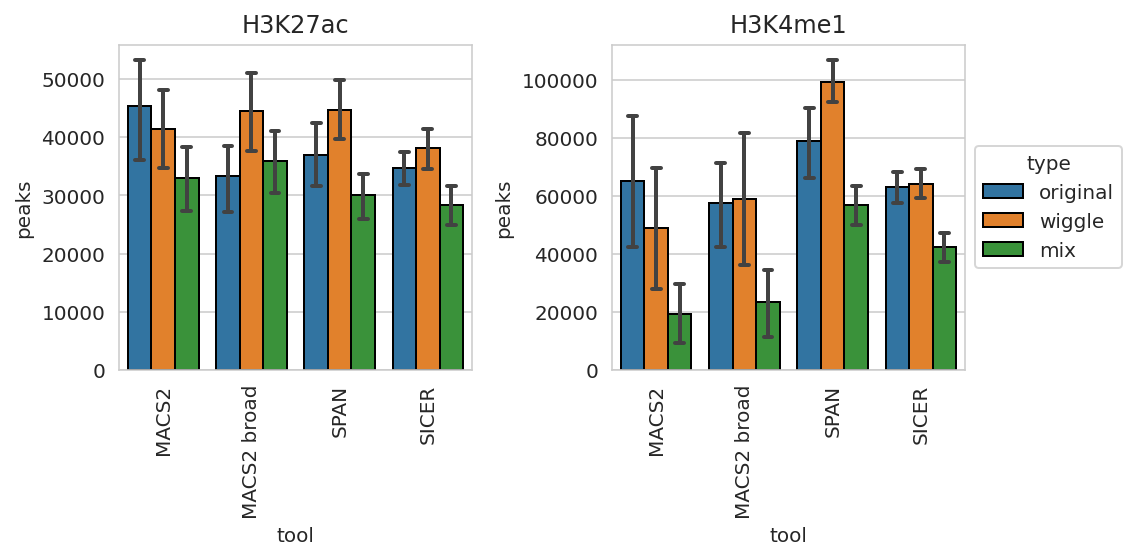

In [53]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            hue_order=['original', 'wiggle', 'mix']
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


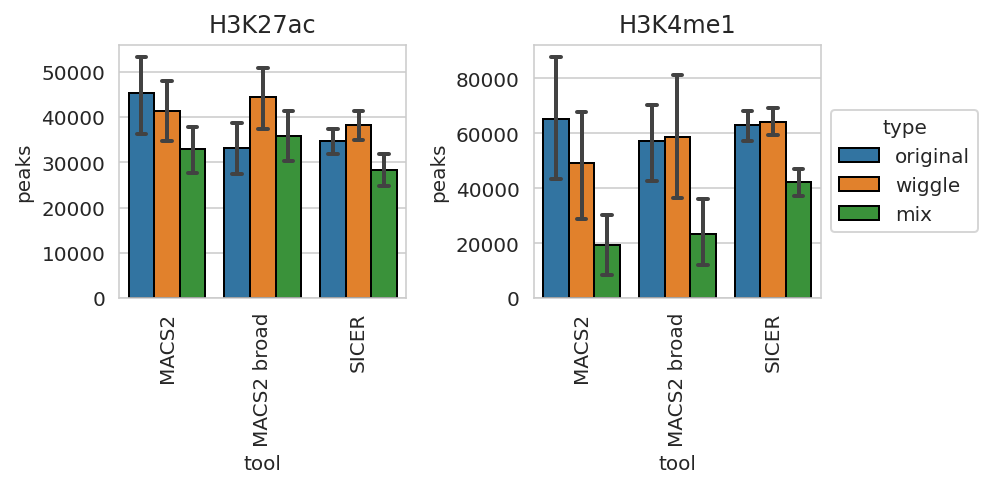

In [54]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

wiggle
H3K27ac
H3K4me1


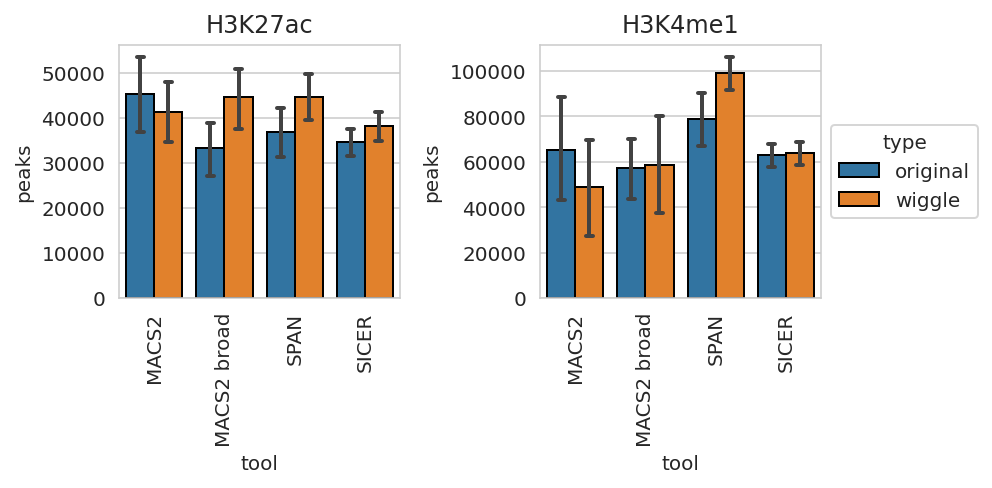

mix
H3K27ac
H3K4me1


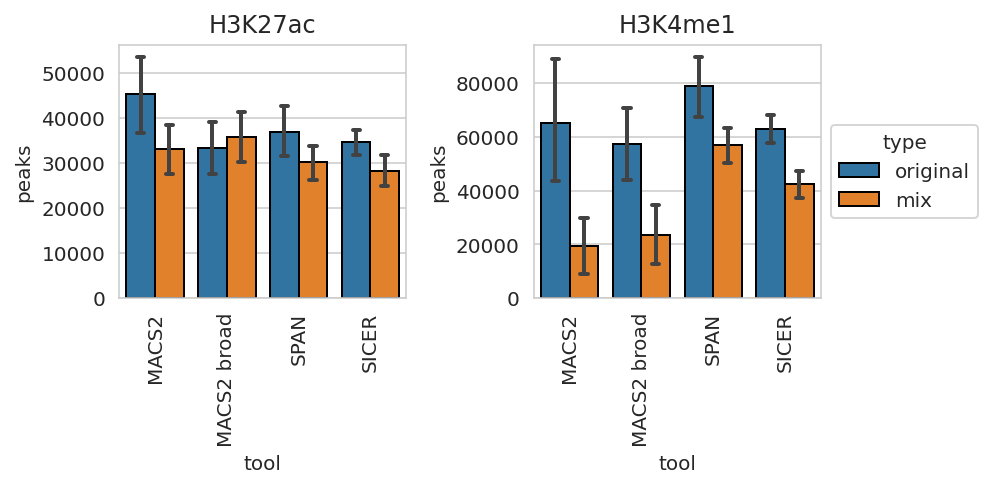

In [55]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                          (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

wiggle
H3K27ac
H3K4me1


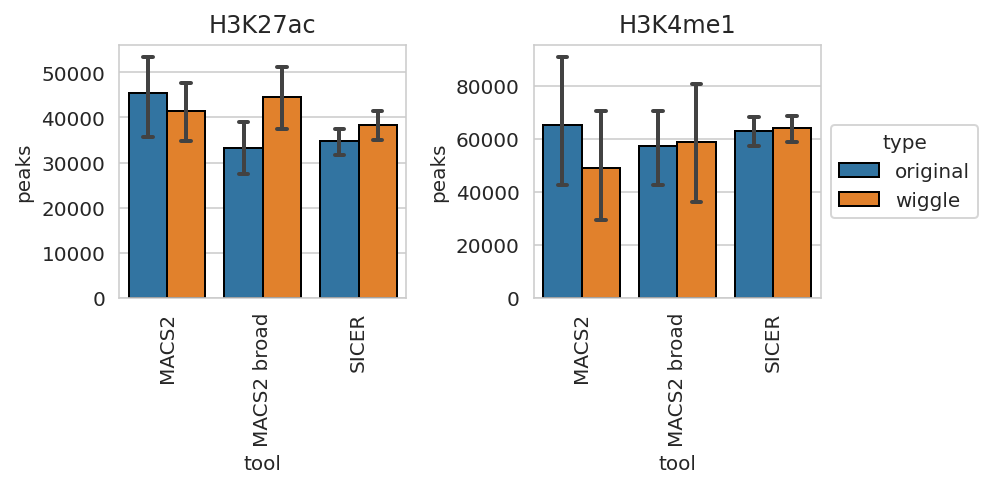

mix
H3K27ac
H3K4me1


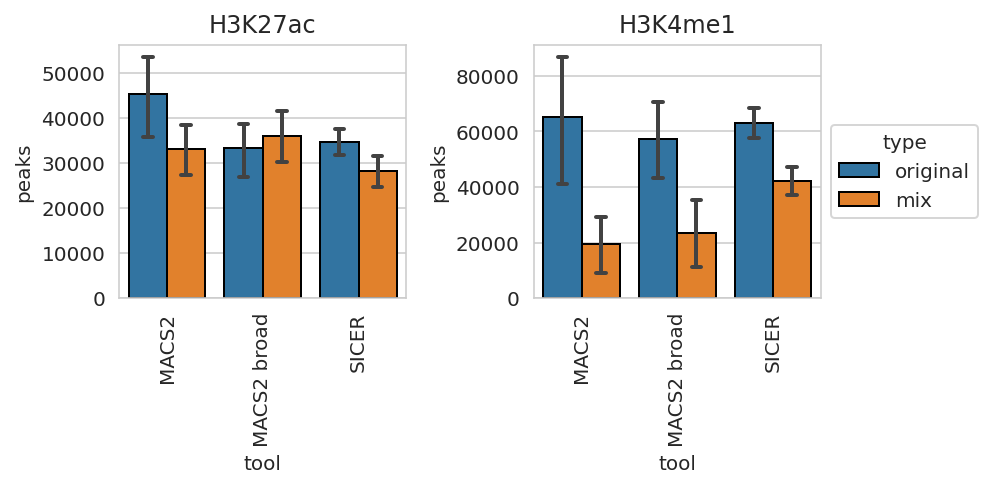

In [56]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                          (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [57]:
all_wiggle_mix_peaks_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool',
                                             'peaks_original', 'type', 'peaks', 'fold-change'])
t = all_wiggle_mix_peaks[all_wiggle_mix_peaks['dataset'] == 'ENCODE']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    for ty in ['wiggle', 'mix']:
        tty = all_wiggle_mix_peaks[(all_wiggle_mix_peaks['type'] == ty) &
                            (all_wiggle_mix_peaks['modification'] == m) &
                            (all_wiggle_mix_peaks['cell'] == c) &
                            (all_wiggle_mix_peaks['replicate'] == r) &
                            (all_wiggle_mix_peaks['tool'] == to)]
        if len(tty) == 0:
            continue
        pty = tty['peaks'].values[0]
        all_wiggle_mix_peaks_fc.loc[len(all_wiggle_mix_peaks_fc)] = (m, c, r, to, p, ty, pty, d(pty, p))
all_wiggle_mix_peaks_fc.sample(3)

0it [00:00, ?it/s]

H3K27ac H1 rep1 MACS2 17497
H3K27ac HepG2 rep1 MACS2 48652
H3K4me1 HMEC rep1 MACS2 10256
H3K27ac K562 rep1 MACS2 53699
H3K4me1 HSMM rep1 MACS2 58144
H3K4me1 NHEK rep1 MACS2 110303
H3K4me1 NHLF rep1 MACS2 35453
H3K4me1 GM12878 rep1 MACS2 46817
H3K27ac Huvec rep1 MACS2 50367
H3K27ac HSMM rep1 MACS2 57283
H3K4me1 H1 rep1 MACS2 29669
H3K27ac GM12878 rep1 MACS2 47290
H3K27ac HMEC rep1 MACS2 40609
H3K4me1 Huvec rep1 MACS2 87943
H3K4me1 K562 rep1 MACS2 119713
H3K27ac NHLF rep1 MACS2 29697
H3K4me1 HepG2 rep1 MACS2 87117
H3K27ac NHEK rep1 MACS2 63415
H3K4me1 Huvec rep1 MACS2 broad 60955
H3K27ac HSMM rep1 MACS2 broad 44198
H3K27ac NHEK rep1 MACS2 broad 44938
H3K4me1 NHEK rep1 MACS2 broad 84110
H3K27ac K562 rep1 MACS2 broad 39486
H3K27ac Huvec rep1 MACS2 broad 37737
H3K4me1 GM12878 rep1 MACS2 broad 42927
H3K27ac H1 rep1 MACS2 broad 15680
H3K4me1 K562 rep1 MACS2 broad 86449
H3K27ac HMEC rep1 MACS2 broad 29088
H3K4me1 HMEC rep1 MACS2 broad 15699
H3K4me1 HSMM rep1 MACS2 broad 66078
H3K4me1 NHLF rep1

modification  cell replicate   tool  peaks_original    type   peaks  \
124      H3K4me1  HSMM      rep1   SPAN           68255  wiggle   96790   
114      H3K4me1  HMEC      rep1   SPAN           98083  wiggle  105382   
88       H3K4me1  NHLF      rep1  SICER           66313  wiggle   60259   

     fold-change  
124     1.418065  
114     1.074417  
88      0.908706

wiggle
H3K27ac
H3K4me1


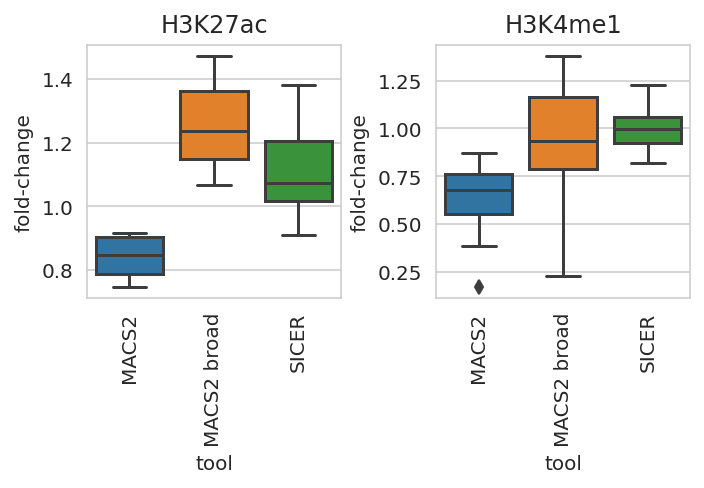

mix
H3K27ac
H3K4me1


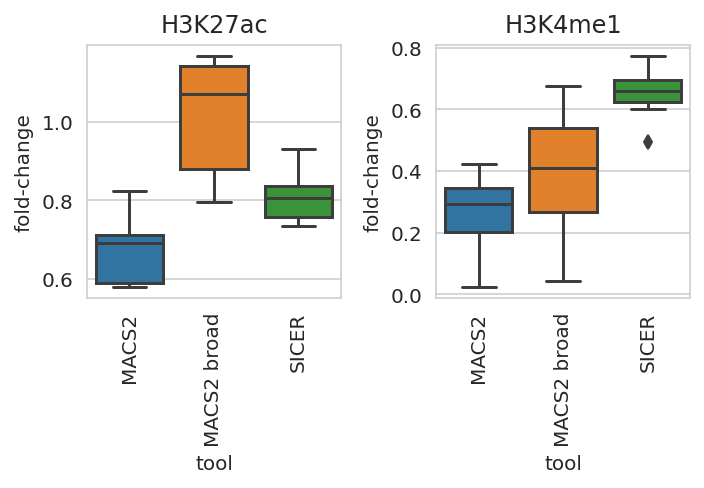

In [58]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(5, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.boxplot(data=all_wiggle_mix_peaks_fc[
            (all_wiggle_mix_peaks_fc['modification'] == m) & 
            (all_wiggle_mix_peaks_fc['type']==ty)],
                                x='tool', y='fold-change', ax=ax,
                                # capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        # if i < 1:
        #     ax.legend().set_visible(False)
        # else:
        #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, )
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

H3K27ac
H3K4me1


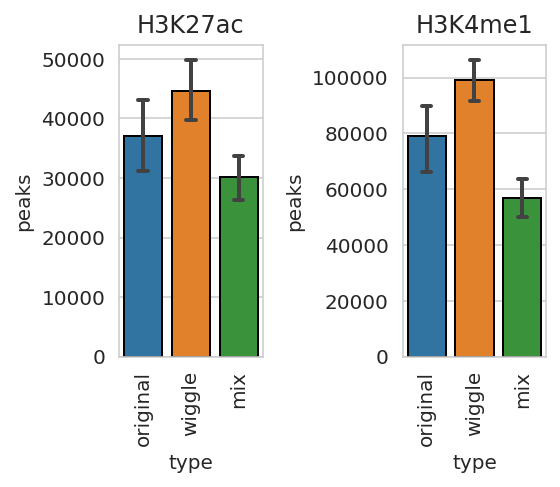

In [59]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                      (all_wiggle_mix_peaks['tool'] == 'SPAN')],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


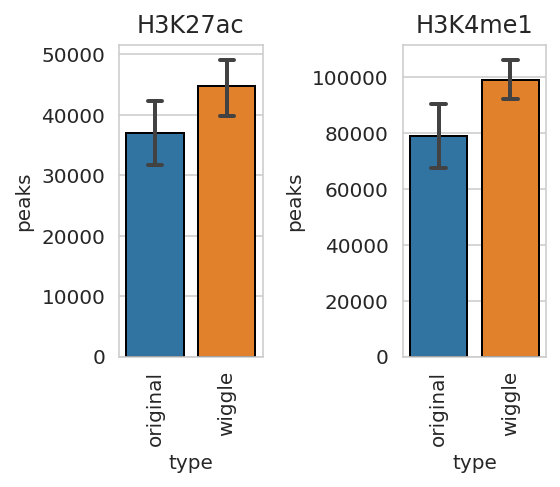

In [60]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) &
                                                      (all_wiggle_mix_peaks['tool'] == 'SPAN') &
                                                      (all_wiggle_mix_peaks['type'].isin(['original', 'wiggle']))],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [61]:
print('Load lengths')
ts = []
for ds, m, c, r, ty, file, tool in tqdm(zip(
        all_wiggle_mix_peaks['dataset'],
        all_wiggle_mix_peaks['modification'],
        all_wiggle_mix_peaks['cell'],
        all_wiggle_mix_peaks['replicate'],
        all_wiggle_mix_peaks['type'], all_wiggle_mix_peaks['file'], all_wiggle_mix_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = ds
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length dataset modification     cell replicate      type         tool
789752     1286     NaN      H3K4me1     HSMM      rep1    wiggle        MACS2
506416     4199  ENCODE      H3K4me1     NHLF      rep1  original        SICER
905596      311     NaN      H3K4me1    Huvec      rep1       mix        MACS2
893346      375     NaN      H3K4me1     K562      rep1    wiggle        MACS2
1040025     320     NaN      H3K4me1     NHLF      rep1       mix  MACS2 broad
1129462     221     NaN      H3K4me1     K562      rep1       mix  MACS2 broad
627348      373  ENCODE      H3K4me1  GM12878      rep1  original         SPAN
1114084     347     NaN      H3K27ac     NHLF      rep1    wiggle  MACS2 broad
1223495     294     NaN      H3K4me1    Huvec      rep1       mix  MACS2 broad
588364     1264  ENCODE      H3K4me1    HepG2      rep1  original         SPAN

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


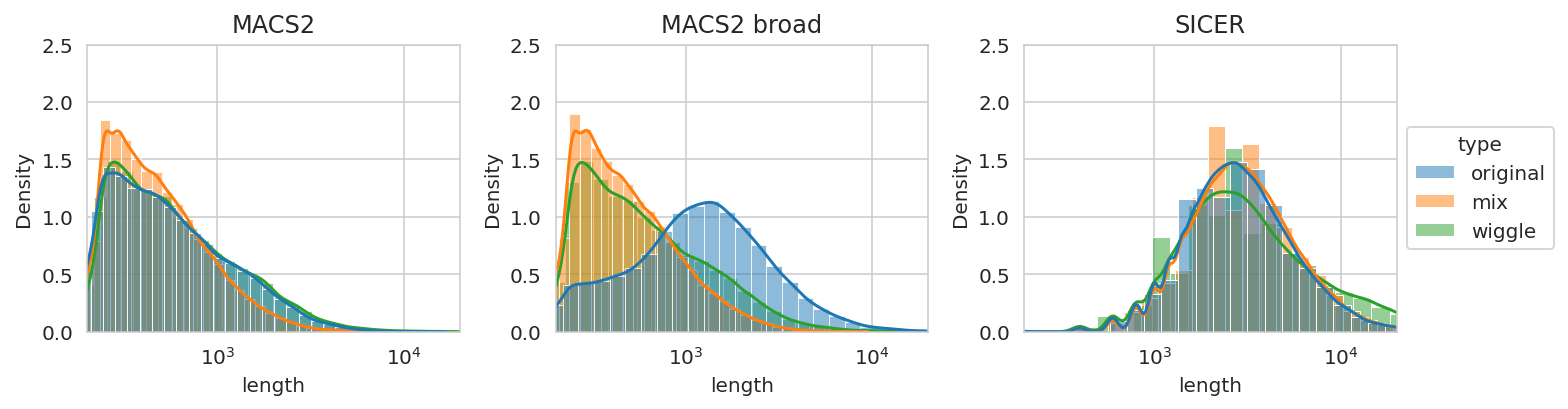

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


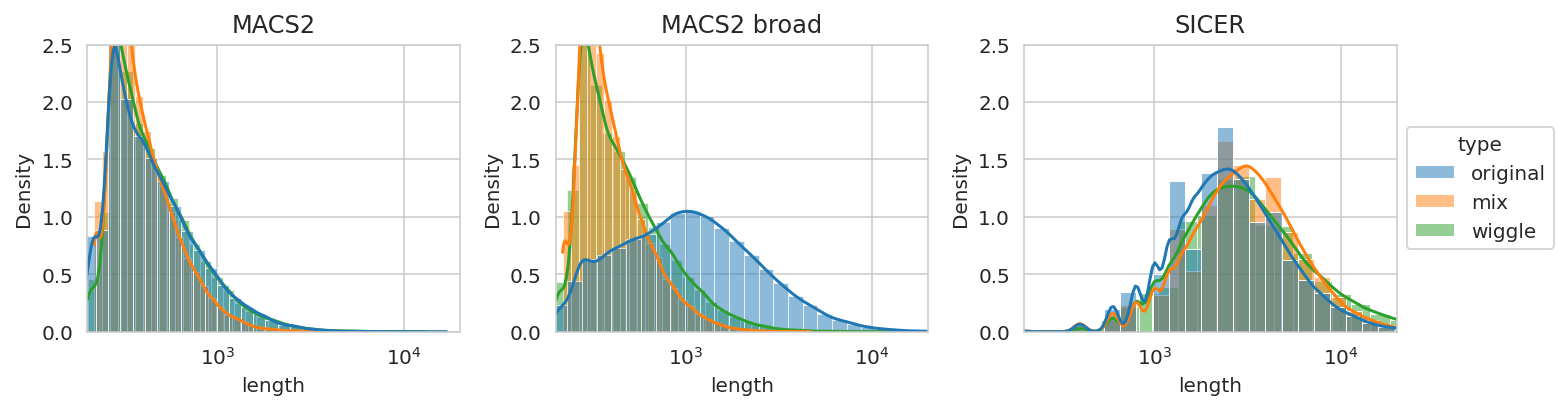

In [62]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(11, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='type', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


wiggle
H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


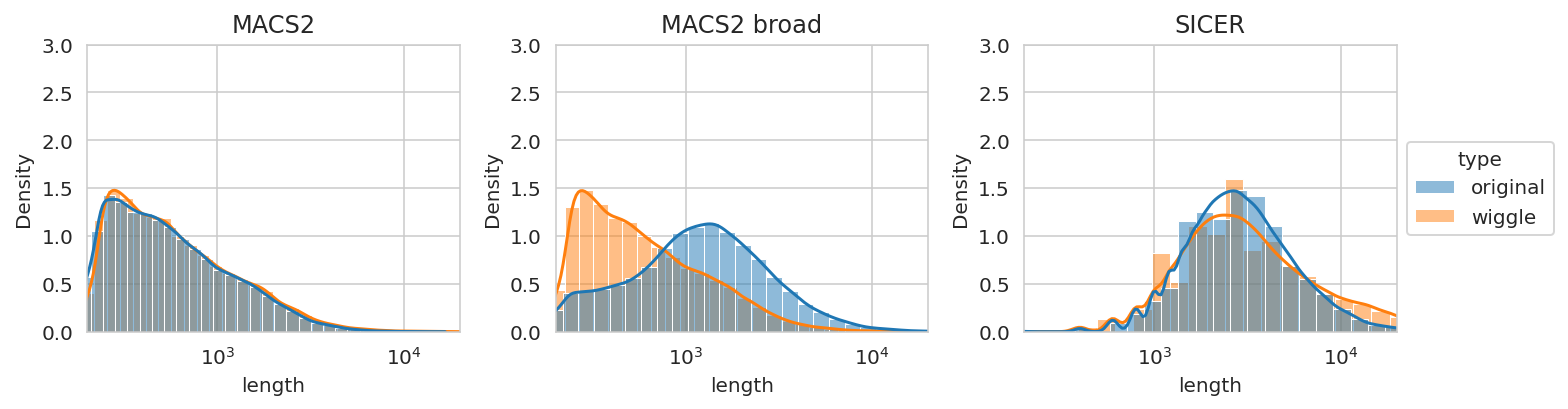

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


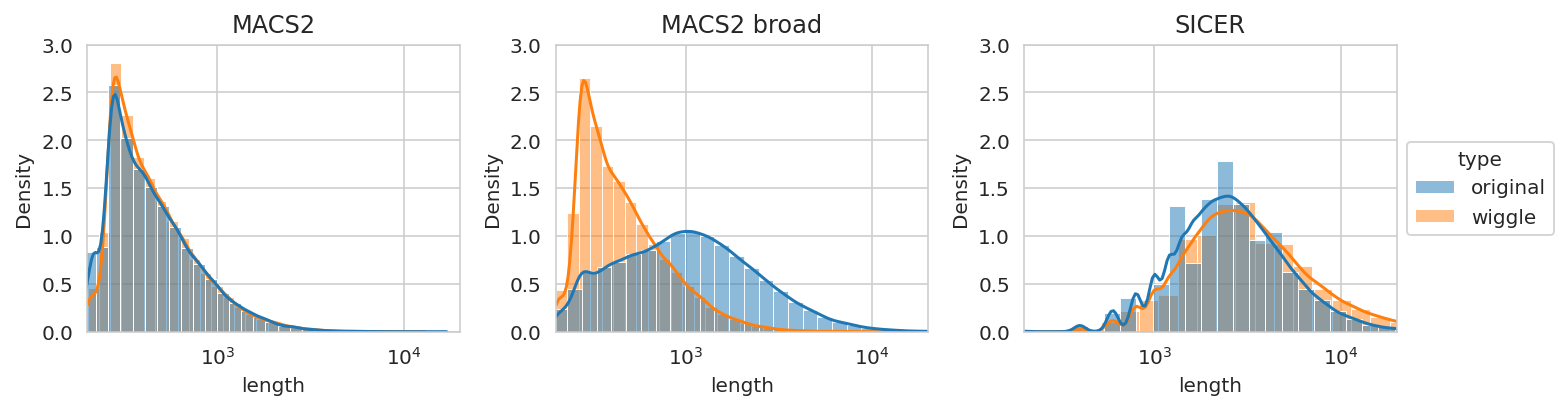

mix
H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


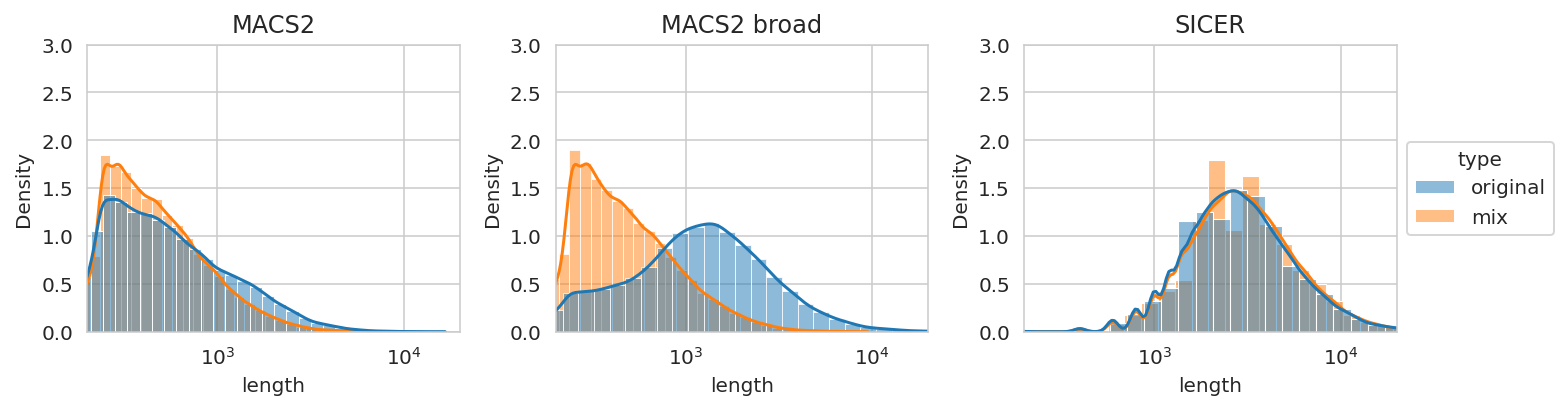

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


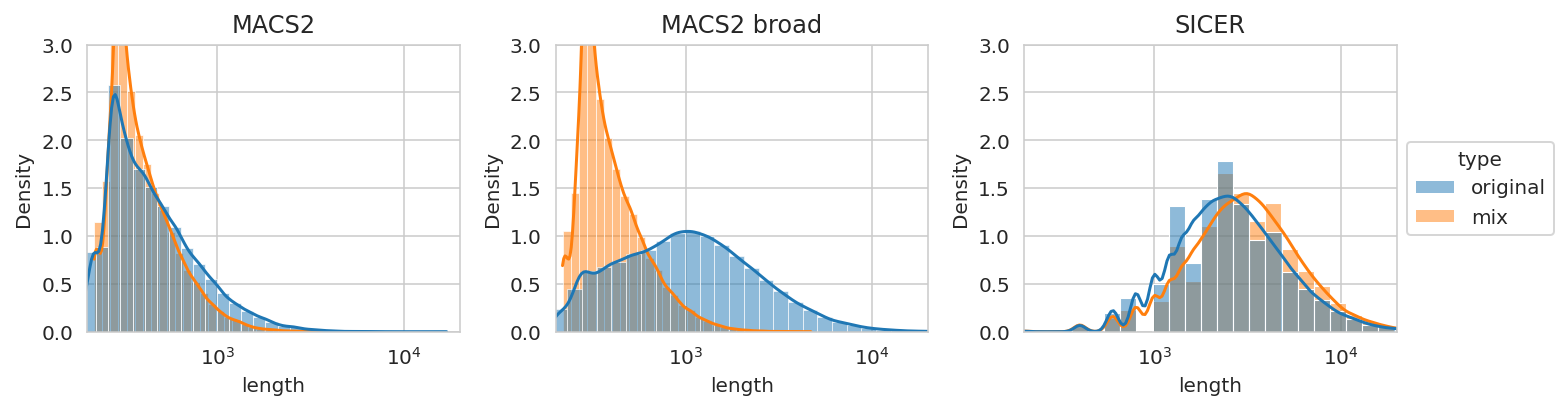

In [63]:
for ty in ['wiggle', 'mix']:
    print(ty)
    for m in ['H3K27ac', 'H3K4me1']:
        print(m)
        plt.figure(figsize=(11, 3))
        axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
        for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
            ax = axs[i]
            g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool) & (t['type'].isin(['original', ty]))],
                                     x='length', hue='type', ax=ax,
                                     stat='density', common_bins=False, common_norm=False,
                                     bins=30, kde=True, log_scale=True, alpha=0.5,
                                     )
            g_results.set(xscale='log')
            g_results.set_ylim(0, 3)
            g_results.set_xlim(200, 2e4)
            ax.title.set_text(f'{tool}')
            if i < 2:
                ax.legend().set_visible(False)
            else:
                sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.tight_layout()
        plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


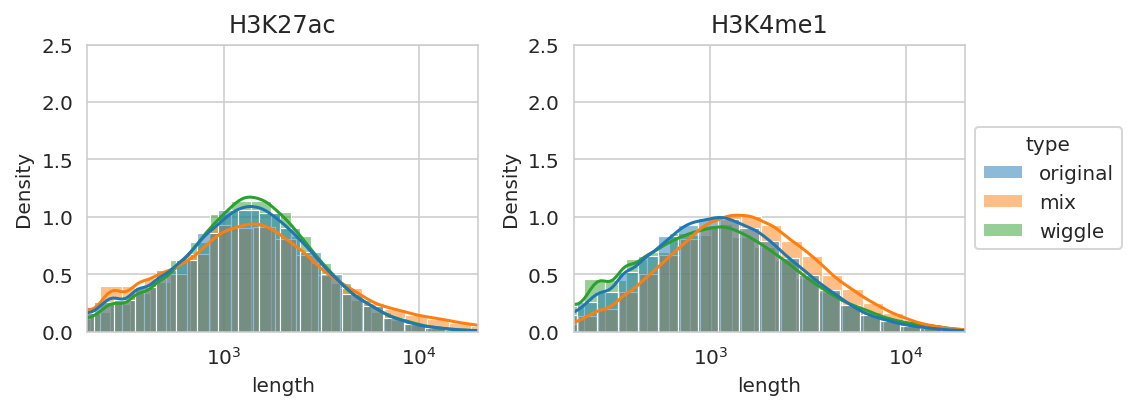

In [64]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


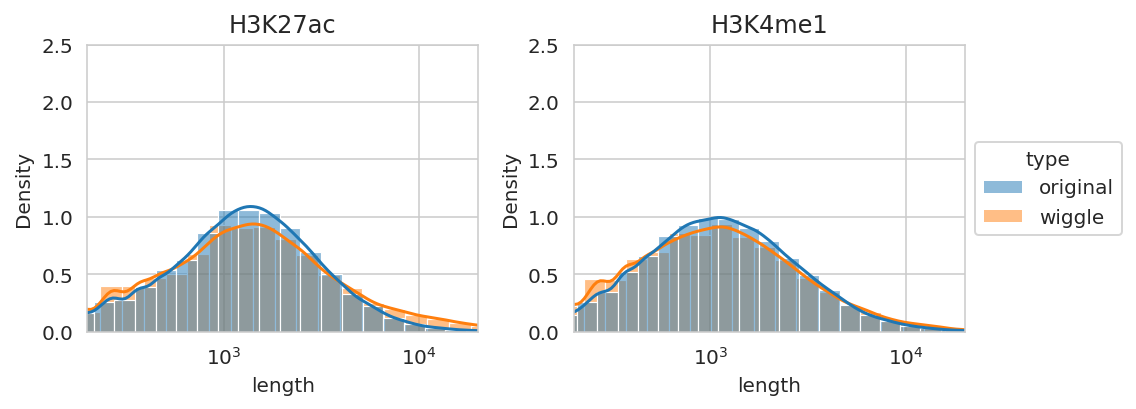

In [65]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & 
                                    (t['tool'] == 'SPAN') & 
                                    (t['type'].isin(['original', 'wiggle']))],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


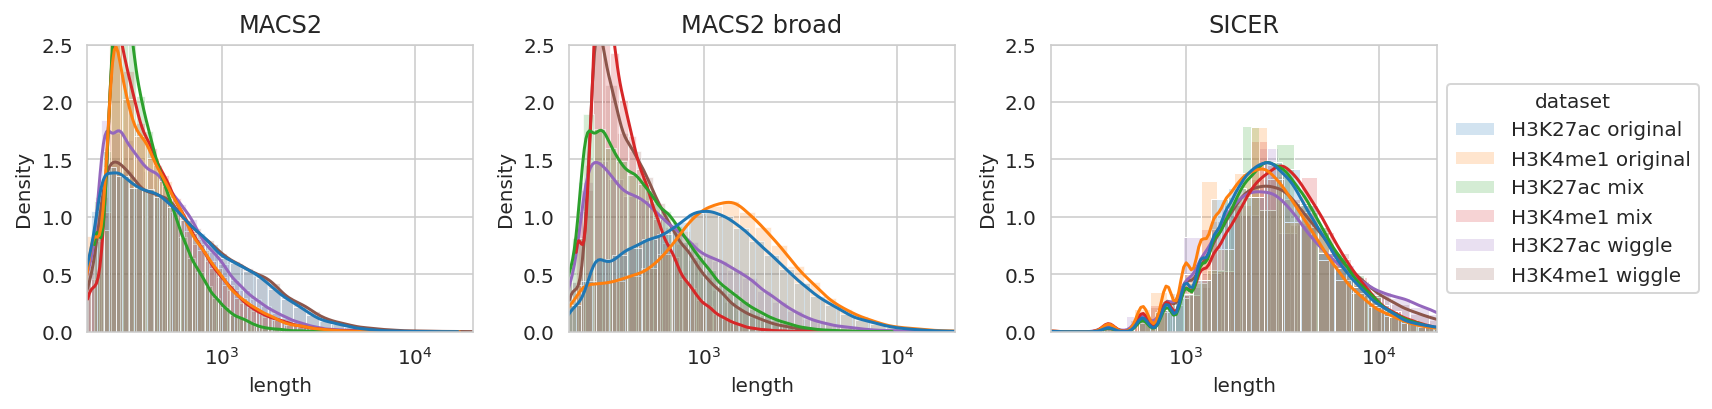

In [66]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


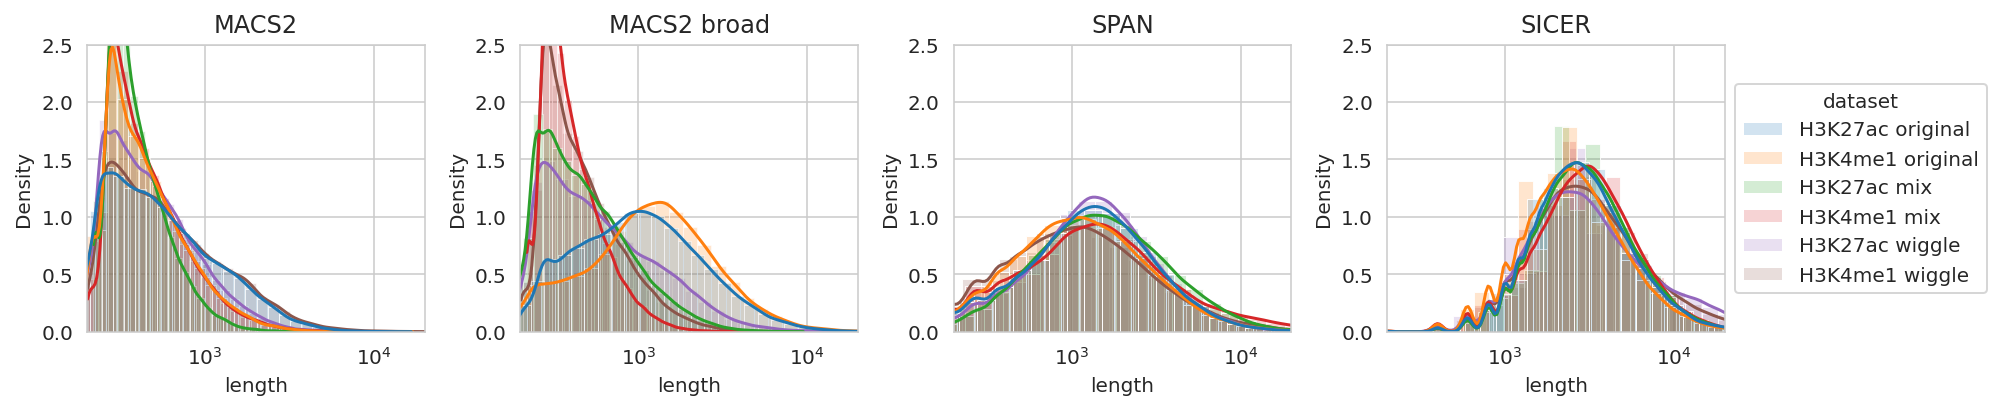

In [67]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SPAN', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [68]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'type', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'type', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

dataset modification     cell replicate    type   tool     length
170  H3K4me1 wiggle      H3K4me1  GM12878      rep1  wiggle  SICER  4152.3600
131     H3K4me1 mix      H3K4me1     NHLF      rep1     mix   SPAN  2891.1168
178  H3K4me1 wiggle      H3K4me1     HSMM      rep1  wiggle  SICER  4034.9600

wiggle
H3K27ac
H3K4me1


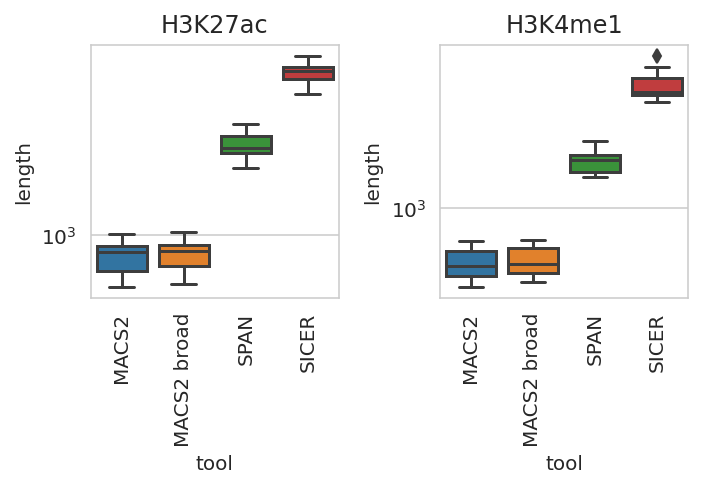

mix
H3K27ac
H3K4me1


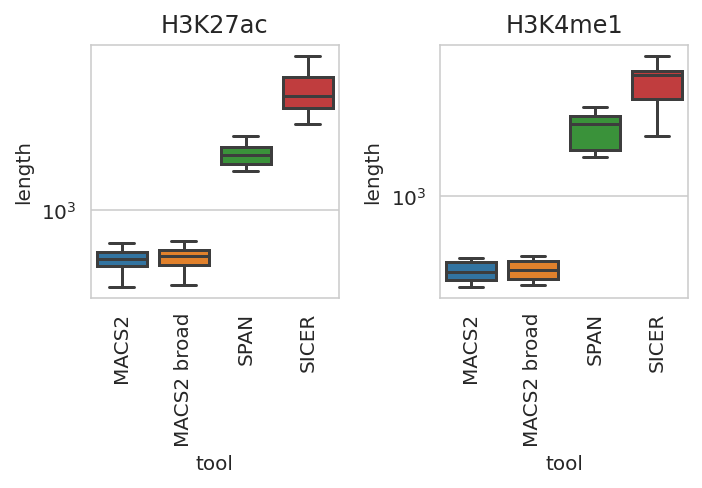

In [69]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(5, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.boxplot(data=t_aggr[
            (t_aggr['modification'] == m) &
            (t_aggr['type']==ty)],
                                x='tool', y='length', ax=ax,
                                # capsize=.1, errwidth=2, edgecolor="black",
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        ax.set(yscale='log')
        # if i < 1:
        #     ax.legend().set_visible(False)
        # else:
        #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, )
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

## Prepare union peaks

In [70]:
all_wiggle_mix_roadmap_peaks = pd.concat([
    df_peaks[(df_peaks['replicate'] != 'rep2') &
             df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], 
    wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_roadmap_peaks['dataset'] = [ds if ty == 'original' else ty for ds, ty in zip(all_wiggle_mix_roadmap_peaks['dataset'], all_wiggle_mix_roadmap_peaks['type'])]
all_wiggle_mix_roadmap_peaks.sample(3)

file modification   cell  \
9    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac   HSMM   
182  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   K562   
1    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac  HepG2   

    replicate  peaks   tool dataset          name      type  
9        rep1  57283  MACS2  ENCODE         MACS2  original  
182      rep1  37200  SICER  wiggle  SICER wiggle    wiggle  
1        rep1  48652  MACS2  ENCODE         MACS2  original

In [72]:
# Remove outliers
display(all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['peaks'] < 20_000) | 
                                     (all_wiggle_mix_roadmap_peaks['peaks'] > 100_000)])
all_wiggle_mix_roadmap_peaks = all_wiggle_mix_roadmap_peaks[
    (all_wiggle_mix_roadmap_peaks['peaks'] >= 20_000) & 
    (all_wiggle_mix_roadmap_peaks['peaks'] <= 100_000)].copy()

Empty DataFrame
Columns: [file, modification, cell, replicate, peaks, tool, dataset, name, type]
Index: []

In [73]:
! mkdir -p {WD}/union

for m, ds in tqdm(product(['H3K27ac', 'H3K4me1'], ['ENCODE', 'wiggle', 'mix', 'Roadmap'])):
    print('---')
    print(m, ds)
    tmdt = all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                        (all_wiggle_mix_roadmap_peaks['dataset'] == ds)]
    if len(tmdt) == 0:
        continue
    for _, (c, r) in tmdt[['cell', 'replicate']].drop_duplicates().iterrows():
        t = tmdt[(tmdt['cell'] == c) & (tmdt['replicate'] == r)]
        if len(t) == 0:
            continue
        print(c, r)
        # Prepare total overlap
        union_path = f'{WD}/union/{m}_{c}_{r}_{ds}.bed'
        if os.path.exists(union_path):
            continue
        try:
            files = t[t['tool'] == 'SPAN']['file']
            t_span = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2']['file']
            t_macs2 = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2 broad']['file']
            t_macs2broad = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'SICER']['file']
            t_sicer = sorted_file(files.values[0]) if len(files) == 1 else ''
            tf = tempfile.mktemp()
            ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
            ! bedtools merge -i {tf} > {union_path}
            print(union_path)
        except Exception as e:
            print(e)
            break
            pass

0it [00:00, ?it/s]

---
H3K27ac ENCODE
HepG2 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep1_ENCODE.bed
K562 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_K562_rep1_ENCODE.bed
Huvec rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_Huvec_rep1_ENCODE.bed
HSMM rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HSMM_rep1_ENCODE.bed
GM12878 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_GM12878_rep1_ENCODE.bed
HMEC rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HMEC_rep1_ENCODE.bed
NHLF rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_NHLF_rep1_ENCODE.bed
NHEK rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_NHEK_rep1_ENCODE.bed
H1 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_H1_rep1_ENCODE.bed
---
H3K27ac wiggle
HSMM rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HSMM_rep1_wiggle.bed
Huvec rep1
/home/jetbrains/data/2023_GSE26320_

In [74]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

In [75]:
def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [76]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
encode_bws['dataset'] = 'ENCODE'
encode_bws.sample(3)

  0%|          | 0/103 [00:00<?, ?it/s]

file modification     cell  \
24  /home/jetbrains/data/2023_GSE26320/bw/GSM64649...      Control     NHLF   
61  /home/jetbrains/data/2023_GSE26320/bw/GSM64631...      H3K27ac  GM12878   
25  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...     H3K36me3  GM12878   

   replicate dataset  
24      rep2  ENCODE  
61      rep2  ENCODE  
25      rep1  ENCODE

In [77]:
immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
immune_bws['dataset'] = 'Roadmap'
immune_bws.sample(3)

  0%|          | 0/17 [00:00<?, ?it/s]

file modification   cell  \
7  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...      H3K27ac  TCell   
0  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...     H3K36me3  BCell   
1  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...     H3K27me3  BCell   

  replicate  dataset  
7            Roadmap  
0            Roadmap  
1            Roadmap

In [80]:
mix_wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
mix_wiggle_bws['dataset'] = ['wiggle' if 'wiggle.bw' in f else 'mix' for f in mix_wiggle_bws['file']] 
mix_wiggle_bws.sample(3)

  0%|          | 0/32 [00:00<?, ?it/s]

file modification   cell  \
11  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   K562   
17  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   HSMM   
6   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  Huvec   

   replicate dataset  
11      rep1  wiggle  
17      rep1     mix  
6       rep1  wiggle

In [81]:
df_bws = pd.concat([encode_bws, immune_bws, mix_wiggle_bws]).reset_index(drop=True)
df_bws.sample(3)

file modification   cell  \
13  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...     H3K36me3  HepG2   
33  /home/jetbrains/data/2023_GSE26320/bw/GSM64643...      Control  Huvec   
8   /home/jetbrains/data/2023_GSE26320/bw/GSM64648...      H3K4me1   NHLF   

   replicate dataset  
13      rep1  ENCODE  
33      rep2  ENCODE  
8       rep1  ENCODE

## Compute roughness of coverage withing peaks

In [82]:
from math import ceil
import pyBigWig

rows = []
bin = 100

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    if not os.path.exists(union_path):
        print('-')
        continue
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            for chr, start, end in zip(t[0], t[1], t[2]):
                if chr in CHROM_SIZES:
                    # Normalize by total coverage
                    stats = [c / total_coverage for c in bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                    rows.append((dt, m, c, r, f'{chr}:{start}-{end}',  len(stats), np.mean(stats), np.std(stats), np.var(stats)))
    except Exception as e:
        print(e)
        break
        pass  # Ignore

df_roughness = pd.DataFrame(rows, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'bins', 'mean', 'std', 'var'])
del rows
df_roughness.sample(5)

0it [00:00, ?it/s]

ENCODE H3K27ac HepG2 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646355_HepG2_H3K27ac_rep1.bw
Total coverage 79.22861050548816
ENCODE H3K27ac K562 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_K562_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646434_K562_H3K27ac_rep1.bw
Total coverage 79.31672214434862


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='var', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
df_roughness_aggr = df_roughness[
    ['datatype', 'modification', 'cell', 'replicate', 'var', 'std']
].groupby(['datatype', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_roughness_aggr.sample(3)

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness_aggr[df_roughness_aggr['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['type']=='wiggle') &
                             (all_wiggle_mix_roadmap_peaks['modification'] == 'H3K4me1') & 
                             (all_wiggle_mix_roadmap_peaks['peaks'] < 20_000)]

## Compute signal/control ratio within peaks

In [ ]:
from math import ceil
import pyBigWig

ratios = []

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    control_dt = 'Roadmap' if dt == 'Roadmap' else 'ENCODE'
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        bwc_path = df_bws[(df_bws['dataset'] == control_dt) &
                          (df_bws['modification'] == 'Control') & (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
        print(bwc_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total signal coverage', total_coverage)
            with pyBigWig.open(bwc_path) as bwc:
                # Resort top scored peaks by density and start with the most dense ones
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print('Total control coverage', total_coveragec)

                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in CHROM_SIZES:
                        # Normalize by total coverage
                        signal = bw.stats(chr, start, end, exact=True, type='sum')[0] / total_coverage
                        noise = bwc.stats(chr, start, end, exact=True, type='sum')[0] / total_coveragec
                        ratios.append((dt, m, c, r, f'{chr}:{start}-{end}', (signal + 1e-10) / (noise + 1e-10)))
    except:
        pass  # Ignore

df_signal_to_control = pd.DataFrame(ratios, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'signal_to_control'])
del ratios
df_signal_to_control.sample(5)

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_signal_to_control[df_signal_to_control['modification'] == m], x='modification', y='signal_to_control', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Signal-to-noise ratio

In [ ]:
# TODO

# Jaccard vs original peaks

In [ ]:
bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'type',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for ds, m, c, r, tool in tqdm(
        [('ENCODE', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], GSE26320_CELLS, GSE26320_REPS, TOOLS)] +
        [('Roadmap', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)]
):
    print(ds, m, c, r, tool)
    t = all_wiggle_mix_roadmap_peaks[
        # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                     (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                     (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                     (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                     (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                     (all_wiggle_mix_roadmap_peaks['type'] == 'original')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    for ty in ['wiggle', 'mix']:
        t = all_wiggle_mix_roadmap_peaks[
            # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                         (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                         (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                         (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                         (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                         (all_wiggle_mix_roadmap_peaks['type'] == ty)]
        if len(t) == 0:
            print(ty, '--')
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = int(bedl(file).sum())
        !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
        overlap1 = lines(tf)
        !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
        overlap2 = lines(tf)
        !bedtools intersect -a {original_file} -b {file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        bench_df.loc[len(bench_df)] = \
            (ds, m, c, r, tool, ty,
             original_peaks, original_peaks_len,
             peaks, peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


In [ ]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


In [ ]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='type', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(6, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=bench_df[(bench_df['type'] == ty) & (bench_df['modification'] == m)],
                                x='name', hue='type', y='jaccard', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['wiggle', 'mix'],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

## Coverage roughness (std) in peaks region example

In [ ]:
xs = [3,6,20,13,7,15,12,15,7,2]
print(sum(xs), np.var(xs))

ys = [3,8,17,14,8,13,12,16,6,3]
print(sum(ys), np.var(ys))

In [ ]:
diff_bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'peaks', 'peakslen', 'averagelen'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for ds, m, c, r in tqdm(
        [('ENCODE', m, c, r) for m, c, r in product(MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)] +
        [('Roadmap', m, c, r) for m, c, r in product(MODIFICATIONS, IMMUNE_CELLS, [''])]
):
    # Process single tool information
    span_file = None
    for tool in TOOLS:
        print(ds, m, c, r, tool)
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = bedl(file).sum()
        average_len = d(peaks_len,  peaks)
        diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, tool, peaks, peaks_len, average_len) 
        if tool == 'SPAN':
            span_file = file
            
    # Processing SPAN difference
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -e -f 0.5 -F 0.5 -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = bedl(tf).sum()
            average_len = d(peaks_len,  peaks)
            diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, name, peaks, peaks_len, average_len)
    
    # Processing exclusive peaks        
    for tool in TOOLS:
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        other_tool_files = []
        for ot in TOOLS:
            if ot == tool:
                continue
            t = df_peaks[
                (df_peaks['dataset'] == ds) &
                (df_peaks['modification'] == m) &
                (df_peaks['cell'] == c) &
                (df_peaks['replicate'] == r) &
                (df_peaks['tool'] == ot)]
            if len(t) == 0:
                continue
            other_tool_files.append(sorted_file(t['file'].values[0]))
        other_tool_files_str = ' '.join(other_tool_files)

        ! bedtools multiinter -i {other_tool_files_str} > {tf}
        ! bedtools merge -i {tf} > {tf2}
        ! bedtools intersect -a {peaks_file} -b {tf2} -e -f 0.5 -F 0.5 -wa -v > {tf}
        peaks = lines(tf)
        peaks_len = bedl(tf).sum()
        average_len = d(peaks_len,  peaks)
        diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, f'{tool} only', peaks, peaks_len, average_len)

display(diff_bench_df.sample(3))

In [ ]:
diff_bench_df.to_csv(os.path.expanduser('~/data/datasets.csv'), index=False)

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.barplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) &
                                               (diff_bench_df['modification']==m) &
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    if i == 0:
        ax.set_ylabel('Peaks')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.barplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) &
                                               (diff_bench_df['modification']==m) &
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='peakslen',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    if i == 0:
        ax.set_ylabel('Basepairs')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) & 
                                               (diff_bench_df['modification']==m) & 
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='averagelen',
                            ax=ax,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('Average length')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    
plt.tight_layout()
plt.show()

## Compute signal / control coverage RPKM

In [ ]:
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

def load_rpkms(path, bw, bwc, total_coverage, total_coveragec, n=1000):
    if lines(path) == 0:
        return []
    t = pd.read_csv(path, sep='\t', header=None)
    t = t.sample(min(len(t), n))
    
    for chr, start, end in zip(t[0], t[1], t[2]):
        if chr in CHROM_SIZES:
            # Normalize by total coverage
            signal = bw.stats(chr, start, end, exact=False, type='sum')[0] / total_coverage
            noise = bwc.stats(chr, start, end, exact=False, type='sum')[0] / total_coveragec
            yield f'{chr}:{start}-{end}', d(signal, (end - start) / 1e3), d(noise, (end - start) / 1e3)

def rpkms_to_df(rpkm_gen, ds, mod, cell, rep, name):
    positions = []
    rpkms = []
    rpkmcs = []
    for p, r, rc in rpkm_gen:
        positions.append(p)
        rpkms.append(r)
        rpkmcs.append(rc)
    t = pd.DataFrame(data={'position': positions * 3, 
                            'RPKM': rpkms + rpkmcs + [d(r, rc) for r, rc in zip(rpkms, rpkmcs)], 
                            'type': ['signal'] * len(positions) + ['control'] * len(positions) + ['signal_to_control'] * len(positions)})
    t['dataset'] = ds
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['name'] = name
    return t

ts = []

for ds, m, c, r in tqdm(
        [('ENCODE', m, c, r) for m, c, r in product(MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)] +
        [('Roadmap', m, c, r) for m, c, r in product(MODIFICATIONS, IMMUNE_CELLS, [''])]
):
    try:
        bw_path = df_bws[(df_bws['dataset'] == ds) &
                         (df_bws['modification'] == m) &
                         (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        bwc_path = df_bws[(df_bws['dataset'] == ds) &
                          (df_bws['modification'] == 'Control') &
                          (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
    
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            with pyBigWig.open(bwc_path) as bwc:
                print(ds, m, c, r, 'Total signal coverage', total_coverage)
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print(ds, m, c, r, 'Total control coverage', total_coveragec)
                print('Process single tool information')
                span_file = None
                for tool in TOOLS:
                    # print(ds, m, c, r, tool)
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    file = sorted_file(t['file'].values[0])
                    ts.append(rpkms_to_df(load_rpkms(file, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, tool))
                    if tool == 'SPAN':
                        span_file = file

                print('Processing SPAN difference')
                for tool in TOOLS:
                    if tool == 'SPAN':
                        continue
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    peaks_file = sorted_file(t['file'].values[0])
                    for name, args in [
                        (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                        (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
                    ]:
                        ! bedtools intersect {args} -e -f 0.5 -F 0.5 -wa -v > {tf}
                        ts.append(rpkms_to_df(load_rpkms(tf, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, name))

                print('Processing exclusive peaks')        
                for tool in TOOLS:
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    peaks_file = sorted_file(t['file'].values[0])
                    other_tool_files = []
                    for ot in TOOLS:
                        if ot == tool:
                            continue
                        t = df_peaks[
                            (df_peaks['dataset'] == ds) &
                            (df_peaks['modification'] == m) &
                            (df_peaks['cell'] == c) &
                            (df_peaks['replicate'] == r) &
                            (df_peaks['tool'] == ot)]
                        if len(t) == 0:
                            continue
                        other_tool_files.append(sorted_file(t['file'].values[0]))
                    other_tool_files_str = ' '.join(other_tool_files)

                    ! bedtools multiinter -i {other_tool_files_str} > {tf}
                    ! bedtools merge -i {tf} > {tf2}
                    ! bedtools intersect -a {peaks_file} -b {tf2} -e -f 0.5 -F 0.5 -wa -v > {tf}
                    ts.append(rpkms_to_df(load_rpkms(tf, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, f'{tool} only'))
    except:
        continue

diff_bench_coverage_df = pd.concat(ts).reset_index(drop=True)
del ts
display(diff_bench_coverage_df.sample(3))

In [ ]:
plt.figure(figsize=(24, 10))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_coverage_df[(diff_bench_coverage_df['type'] != 'signal_to_control') & 
                                                        (diff_bench_coverage_df['dataset'] == ds) &
                                                        (diff_bench_coverage_df['modification']==m)],
                            x='name', y='RPKM', hue='type',
                            ax=ax,
                            showfliers=False,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ],
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('RPKM')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(24, 10))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_coverage_df[(diff_bench_coverage_df['type'] == 'signal_to_control') & 
                                                        (diff_bench_coverage_df['dataset'] == ds) &
                                                        (diff_bench_coverage_df['modification']==m) &
                                                        (diff_bench_coverage_df['RPKM']<1000)],
                            x='name', y='RPKM', 
                            ax=ax,
                            showfliers=False,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ],
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('Signal / control')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# END